<a href="https://colab.research.google.com/github/caetano-dev/PixFraudDetection/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Academic Project Context: Financial Transaction Analysis for Money Laundering Detection using Graph Methods

This is an undergraduate academic final project that involves analyzing large-scale financial transaction data to identify potential money laundering activities, focusing on the accounts. The core approach utilizes graph-based techniques applied to temporal snapshots of transaction networks and in the future will use GNNs.

***

## Data Used

The project processes transaction data from CSV files (e.g., `LI-Large_Trans.csv`, `HI-Small_Trans.csv`). Each transaction record typically includes:
* Timestamp
* From/To Bank and Account identifiers
* Amount sent/received
* Currency sent/received
* Payment Type
* A binary flag indicating if the transaction is part of a known laundering attempt (`is_laundering`).

Additionally, account details (like bank, entity ID, entity name) are loaded from separate files. Known money laundering patterns are also parsed from a text file to identify laundering attempts.

The large dataset is indeed very large, so we need to keep that in mind. Everything is being run on Google Colab, with 10GB of RAM max.

***

## Dataset Characteristics and Money Laundering Models

The dataset is generated by **AMLworld**, a synthetic data generator designed to create realistic financial transactions for anti-money laundering (AML) research. A key advantage of this synthetic dataset is its **perfect ground truth labeling**; unlike real-world data where many illicit activities go undetected, every transaction that is part of a laundering scheme is accurately flagged.

The AMLworld generator models the entire money laundering cycle, which consists of three main stages:

1.  **Placement**: The introduction of illicit funds into the financial system from criminal activities like smuggling, extortion, etc.
2.  **Layering**: The process of obscuring the origin of the illicit funds by creating complex series of transactions.
3.  **Integration**: The final stage where the laundered funds are reintroduced into the legitimate economy, for example, by paying salaries or purchasing supplies.

For the **layering stage**, the dataset specifically models eight key transaction patterns that are strong indicators of money laundering. These patterns involve a set of accounts that are all owned or controlled by the laundering entity.

The specific patterns are:

* **Fan-out**: One account sends funds to multiple other accounts.
* **Fan-in**: Multiple accounts send funds to a single account.
* **Gather-scatter**: A combination of a fan-in and a fan-out pattern centered on the same account.
* **Scatter-gather**: Funds from a source account are passed through several intermediate accounts before being consolidated into a single destination account.
* **Simple Cycle**: A series of transactions where funds start at one account and eventually return to it through other accounts.
* **Random**: A pattern similar to a cycle, but the funds do not return to the original account, instead following a random walk among controlled accounts.
* **Bipartite**: Funds are moved from one set of accounts to a different set of accounts.
* **Stack**: An extension of the bipartite pattern that adds an additional layer of accounts.

In addition to these structured patterns, the generator also models laundering that occurs more "naturally" during the **integration phase**, such as a criminal entity using illicit funds for seemingly legitimate transactions like payroll or business expenses.

This table has some additional statistics about the six datasets:

```
..                                  SMALL           MEDIUM           LARGE
..                                  HI     LI        HI      LI       HI       LI
.. Date Range HI + LI (2022)         Sep 1-10         Sep 1-16        Aug 1 - Nov 5
.. # of Days Spanned                 10     10        16      16       97       97
.. # of Bank Accounts               515K   705K     2077K   2028K    2116K    2064K
.. # of Transactions                  5M     7M       32M     31M      180M    176M
.. # of Laundering Transactions     5.1K   4.0K       35K     16K      223K    100K
.. Laundering Rate (1 per N Trans)  981   1942       905    1948       807     1750
```


***

## Preprocessing and Filtering

Raw transaction data is preprocessed using DuckDB for efficient loading and initial filtering. This involves:
* Reading large CSV files with specified column types (initially all `VARCHAR`).
* Parsing timestamps into datetime objects.
* Casting numeric fields (amounts) to `DOUBLE` and boolean flags (`is_laundering`) to `INTEGER`.
* Applying filters to select transactions based on `payment_type` (primarily 'ACH') and `currency_sent`/`currency_received` (e.g., 'US Dollar'). This filtered data is saved as Parquet files (`1_filtered_normal_transactions.parquet`, `2_filtered_laundering_transactions.parquet`).
* Account data is filtered to include only accounts involved in the selected transactions (`3_filtered_accounts.parquet`).
* There are no fees in the transactions.

Example of the filtered data:
```
Normal transactions
            timestamp from_bank from_account to_bank to_account  \
0 2022-09-01 00:17:00       011    800059120   01217  8006AD4E0   
1 2022-09-01 00:29:00     03618    800929EA0  001277  800929EF0   
2 2022-09-01 00:08:00     00394    80093BDB0  021414  80092A6C0   
3 2022-09-01 00:23:00     01231    800B69730  021414  80093CED0   
4 2022-09-01 00:19:00     02860    800BA6B40  011222  800BBE6F0   

   amount_received currency_received  amount_sent currency_sent payment_type  \
0         60562.00         US Dollar     60562.00     US Dollar          ACH   
1             0.05         US Dollar         0.05     US Dollar          ACH   
2         64335.00         US Dollar     64335.00     US Dollar          ACH   
3           217.00         US Dollar       217.00     US Dollar          ACH   
4          3400.37         US Dollar      3400.37     US Dollar          ACH   

   is_laundering  
0              0  
1              0  
2              0  
3              0  
4              0  
Laundering transactions
            timestamp from_bank from_account to_bank to_account  \
0 2022-09-03 11:23:00     01835    800F963A0    0224  801C56FF0   
1 2022-09-06 17:16:00     01835    800F963A0  022086  800CD0BE0   
2 2022-09-01 10:28:00       003    80033F3B0     011  8001DC570   
3 2022-09-02 11:51:00     01768    8007F5C20   01231  800379FA0   
4 2022-09-02 19:00:00       003    8001B8080     001  800161140   

   amount_received currency_received  amount_sent currency_sent payment_type  \
0          7648.13         US Dollar      7648.13     US Dollar          ACH   
1         18261.63         US Dollar     18261.63     US Dollar          ACH   
2          4730.57         US Dollar      4730.57     US Dollar          ACH   
3          4723.36         US Dollar      4723.36     US Dollar          ACH   
4          4070.87         US Dollar      4070.87     US Dollar          ACH   

   is_laundering  attempt_id                          attempt_type  
0              1         3.0  GATHER-SCATTER:  Max 3-degree Fan-In  
1              1         3.0  GATHER-SCATTER:  Max 3-degree Fan-In  
2              1         4.0                  RANDOM:  Max 10 hops  
3              1         4.0                  RANDOM:  Max 10 hops  
4              1         4.0                  RANDOM:  Max 10 hops  
Bank accounts
                  bank_name bank_id account_id_hex  entity_id  \
0   Fieldstone Savings Bank  311684      8054A74B0  800C891B0   
1   First Bank of Cleveland  116473      80B71CA30  8004D20A0   
2  Savings Bank of Lacrosse  325898      8096E33C0  800EA5340   
3            Greece Bank #8     600      800439AC0  800874500   
4   National Bank of Denver    8318      8044289C0  80039D5C0   

                 entity_name  
0          Corporation #7880  
1         Partnership #52150  
2         Partnership #12326  
3         Corporation #28311  
4  Sole Proprietorship #6938
```

Sample of number of nodes per day

```
LI Small

-- 3-day windows, stride=1d --
[000] 2022-09-01 → 2022-09-04: nodes=97,912, edges=98,073, pos_edges=246, pos_nodes=452
[001] 2022-09-02 → 2022-09-05: nodes=80,131, edges=72,711, pos_edges=274, pos_nodes=490
[002] 2022-09-03 → 2022-09-06: nodes=51,107, edges=52,385, pos_edges=330, pos_nodes=564
[003] 2022-09-04 → 2022-09-07: nodes=50,524, edges=64,159, pos_edges=345, pos_nodes=602
[004] 2022-09-05 → 2022-09-08: nodes=50,915, edges=76,837, pos_edges=370, pos_nodes=655
[005] 2022-09-06 → 2022-09-09: nodes=50,807, edges=77,066, pos_edges=368, pos_nodes=649
[006] 2022-09-07 → 2022-09-10: nodes=74,129, edges=92,174, pos_edges=365, pos_nodes=645
[007] 2022-09-08 → 2022-09-11: nodes=73,876, edges=79,628, pos_edges=348, pos_nodes=608
[008] 2022-09-09 → 2022-09-12: nodes=68,933, edges=53,939, pos_edges=237, pos_nodes=407
[009] 2022-09-10 → 2022-09-13: nodes=21,249, edges=13,542, pos_edges=143, pos_nodes=238
[010] 2022-09-11 → 2022-09-14: nodes=88, edges=73, pos_edges=63, pos_nodes=88
[011] 2022-09-12 → 2022-09-15: nodes=57, edges=48, pos_edges=43, pos_nodes=57
[012] 2022-09-13 → 2022-09-16: nodes=44, edges=34, pos_edges=33, pos_nodes=44
[013] 2022-09-14 → 2022-09-17: nodes=21, edges=16, pos_edges=16, pos_nodes=21
[014] 2022-09-15 → 2022-09-18: nodes=12, edges=9, pos_edges=9, pos_nodes=12
[015] 2022-09-16 → 2022-09-19: nodes=6, edges=4, pos_edges=4, pos_nodes=6

-- 7-day windows, stride=1d --
[000] 2022-09-01 → 2022-09-08: nodes=113,515, edges=188,269, pos_edges=709, pos_nodes=1,231
[001] 2022-09-02 → 2022-09-09: nodes=97,189, edges=175,269, pos_edges=782, pos_nodes=1,335
[002] 2022-09-03 → 2022-09-10: nodes=91,451, edges=169,867, pos_edges=807, pos_nodes=1,367
[003] 2022-09-04 → 2022-09-11: nodes=91,372, edges=169,824, pos_edges=811, pos_nodes=1,370
[004] 2022-09-05 → 2022-09-12: nodes=87,301, edges=156,497, pos_edges=745, pos_nodes=1,249
[005] 2022-09-06 → 2022-09-13: nodes=82,956, edges=131,024, pos_edges=620, pos_nodes=1,037
[006] 2022-09-07 → 2022-09-14: nodes=78,897, edges=105,738, pos_edges=529, pos_nodes=877
[007] 2022-09-08 → 2022-09-15: nodes=73,927, edges=79,708, pos_edges=418, pos_nodes=683
[008] 2022-09-09 → 2022-09-16: nodes=68,966, edges=53,992, pos_edges=285, pos_nodes=457
[009] 2022-09-10 → 2022-09-17: nodes=21,280, edges=13,580, pos_edges=180, pos_nodes=276
[010] 2022-09-11 → 2022-09-18: nodes=105, edges=89, pos_edges=79, pos_nodes=105
[011] 2022-09-12 → 2022-09-19: nodes=66, edges=57, pos_edges=52, pos_nodes=66
[012] 2022-09-13 → 2022-09-20: nodes=48, edges=38, pos_edges=37, pos_nodes=48
[013] 2022-09-14 → 2022-09-21: nodes=21, edges=16, pos_edges=16, pos_nodes=21
[014] 2022-09-15 → 2022-09-22: nodes=12, edges=9, pos_edges=9, pos_nodes=12
[015] 2022-09-16 → 2022-09-23: nodes=6, edges=4, pos_edges=4, pos_nodes=6

HI Small

-- 3-day windows, stride=1d --
[000] 2022-09-01 → 2022-09-04: nodes=98,303, edges=98,159, pos_edges=332, pos_nodes=581
[001] 2022-09-02 → 2022-09-05: nodes=80,543, edges=72,819, pos_edges=382, pos_nodes=646
[002] 2022-09-03 → 2022-09-06: nodes=51,467, edges=52,470, pos_edges=415, pos_nodes=671
[003] 2022-09-04 → 2022-09-07: nodes=50,932, edges=64,278, pos_edges=464, pos_nodes=743
[004] 2022-09-05 → 2022-09-08: nodes=51,307, edges=76,930, pos_edges=463, pos_nodes=748
[005] 2022-09-06 → 2022-09-09: nodes=51,225, edges=77,171, pos_edges=473, pos_nodes=780
[006] 2022-09-07 → 2022-09-10: nodes=74,531, edges=92,262, pos_edges=453, pos_nodes=738
[007] 2022-09-08 → 2022-09-11: nodes=74,377, edges=79,767, pos_edges=487, pos_nodes=800
[008] 2022-09-09 → 2022-09-12: nodes=69,376, edges=54,112, pos_edges=410, pos_nodes=645
[009] 2022-09-10 → 2022-09-13: nodes=21,588, edges=13,731, pos_edges=332, pos_nodes=490
[010] 2022-09-11 → 2022-09-14: nodes=281, edges=204, pos_edges=194, pos_nodes=264
[011] 2022-09-12 → 2022-09-15: nodes=183, edges=138, pos_edges=133, pos_nodes=174
[012] 2022-09-13 → 2022-09-16: nodes=92, edges=68, pos_edges=67, pos_nodes=90
[013] 2022-09-14 → 2022-09-17: nodes=57, edges=43, pos_edges=43, pos_nodes=57
[014] 2022-09-15 → 2022-09-18: nodes=26, edges=18, pos_edges=18, pos_nodes=26
[015] 2022-09-16 → 2022-09-19: nodes=21, edges=15, pos_edges=15, pos_nodes=21
[016] 2022-09-17 → 2022-09-20: nodes=10, edges=7, pos_edges=7, pos_nodes=10
[017] 2022-09-18 → 2022-09-21: nodes=7, edges=5, pos_edges=5, pos_nodes=7

-- 7-day windows, stride=1d --
[000] 2022-09-01 → 2022-09-08: nodes=114,555, edges=188,492, pos_edges=932, pos_nodes=1,477
[001] 2022-09-02 → 2022-09-09: nodes=98,243, edges=175,497, pos_edges=1,010, pos_nodes=1,596
[002] 2022-09-03 → 2022-09-10: nodes=92,475, edges=170,100, pos_edges=1,040, pos_nodes=1,626
[003] 2022-09-04 → 2022-09-11: nodes=92,467, edges=170,100, pos_edges=1,087, pos_nodes=1,683
[004] 2022-09-05 → 2022-09-12: nodes=88,331, edges=156,790, pos_edges=1,038, pos_nodes=1,581
[005] 2022-09-06 → 2022-09-13: nodes=83,913, edges=131,361, pos_edges=957, pos_nodes=1,432
[006] 2022-09-07 → 2022-09-14: nodes=79,686, edges=106,026, pos_edges=817, pos_nodes=1,203
[007] 2022-09-08 → 2022-09-15: nodes=74,635, edges=79,998, pos_edges=708, pos_nodes=1,045
[008] 2022-09-09 → 2022-09-16: nodes=69,530, edges=54,258, pos_edges=551, pos_nodes=794
[009] 2022-09-10 → 2022-09-17: nodes=21,667, edges=13,807, pos_edges=407, pos_nodes=568
[010] 2022-09-11 → 2022-09-18: nodes=326, edges=249, pos_edges=239, pos_nodes=309
[011] 2022-09-12 → 2022-09-19: nodes=207, edges=161, pos_edges=156, pos_nodes=198
[012] 2022-09-13 → 2022-09-20: nodes=107, edges=83, pos_edges=82, pos_nodes=105
[013] 2022-09-14 → 2022-09-21: nodes=65, edges=50, pos_edges=50, pos_nodes=65
[014] 2022-09-15 → 2022-09-22: nodes=31, edges=23, pos_edges=23, pos_nodes=31
[015] 2022-09-16 → 2022-09-23: nodes=21, edges=15, pos_edges=15, pos_nodes=21
[016] 2022-09-17 → 2022-09-24: nodes=10, edges=7, pos_edges=7, pos_nodes=10
[017] 2022-09-18 → 2022-09-25: nodes=7, edges=5, pos_edges=5, pos_nodes=7

LI Large

(sample)

Loaded: 7,267,159 tx; accounts: 539,648

-- 3-day windows, stride=1d --
[000] 2022-08-01 → 2022-08-04: nodes=207,640, edges=267,125, pos_edges=547, pos_nodes=1,076
[001] 2022-08-02 → 2022-08-05: nodes=151,212, edges=228,848, pos_edges=575, pos_nodes=1,130
[002] 2022-08-03 → 2022-08-06: nodes=235,965, edges=288,320, pos_edges=609, pos_nodes=1,205
[003] 2022-08-04 → 2022-08-07: nodes=235,245, edges=251,421, pos_edges=625, pos_nodes=1,239
[004] 2022-08-05 → 2022-08-08: nodes=234,675, edges=214,420, pos_edges=588, pos_nodes=1,162
[005] 2022-08-06 → 2022-08-09: nodes=149,821, edges=154,504, pos_edges=573, pos_nodes=1,132
[006] 2022-08-07 → 2022-08-10: nodes=149,993, edges=191,251, pos_edges=552, pos_nodes=1,093
[007] 2022-08-08 → 2022-08-11: nodes=149,909, edges=227,415, pos_edges=585, pos_nodes=1,152

-- 7-day windows, stride=1d --
[000] 2022-08-01 → 2022-08-08: nodes=333,688, edges=557,764, pos_edges=1,339, pos_nodes=2,607
[001] 2022-08-02 → 2022-08-09: nodes=285,980, edges=519,419, pos_edges=1,360, pos_nodes=2,634
[002] 2022-08-03 → 2022-08-10: nodes=285,537, edges=518,706, pos_edges=1,370, pos_nodes=2,665
[003] 2022-08-04 → 2022-08-11: nodes=284,772, edges=518,054, pos_edges=1,377, pos_nodes=2,684
[004] 2022-08-05 → 2022-08-12: nodes=283,307, edges=516,371, pos_edges=1,375, pos_nodes=2,668
[005] 2022-08-06 → 2022-08-13: nodes=266,298, edges=499,356, pos_edges=1,382, pos_nodes=2,679
[006] 2022-08-07 → 2022-08-14: nodes=266,184, edges=500,034, pos_edges=1,392, pos_nodes=2,689
[007] 2022-08-08 → 2022-08-15: nodes=266,516, edges=499,767, pos_edges=1,427, pos_nodes=2,758

HI Large

(sample)

Loaded: 7,236,519 tx; accounts: 555,586

-- 3-day windows, stride=1d --
[000] 2022-08-01 → 2022-08-04: nodes=205,495, edges=262,907, pos_edges=756, pos_nodes=1,418
[001] 2022-08-02 → 2022-08-05: nodes=149,252, edges=225,315, pos_edges=820, pos_nodes=1,543
[002] 2022-08-03 → 2022-08-06: nodes=233,455, edges=284,687, pos_edges=903, pos_nodes=1,694
[003] 2022-08-04 → 2022-08-07: nodes=233,562, edges=248,901, pos_edges=933, pos_nodes=1,708
[004] 2022-08-05 → 2022-08-08: nodes=233,430, edges=213,262, pos_edges=953, pos_nodes=1,725
[005] 2022-08-06 → 2022-08-09: nodes=149,488, edges=154,169, pos_edges=956, pos_nodes=1,723
[006] 2022-08-07 → 2022-08-10: nodes=149,856, edges=190,405, pos_edges=1,031, pos_nodes=1,876
[007] 2022-08-08 → 2022-08-11: nodes=149,365, edges=225,845, pos_edges=1,101, pos_nodes=1,993

-- 7-day windows, stride=1d --
[000] 2022-08-01 → 2022-08-08: nodes=330,720, edges=551,335, pos_edges=2,022, pos_nodes=3,587
[001] 2022-08-02 → 2022-08-09: nodes=283,562, edges=514,176, pos_edges=2,096, pos_nodes=3,684
[002] 2022-08-03 → 2022-08-10: nodes=283,948, edges=514,135, pos_edges=2,234, pos_nodes=3,908
[003] 2022-08-04 → 2022-08-11: nodes=283,829, edges=514,273, pos_edges=2,367, pos_nodes=4,090
[004] 2022-08-05 → 2022-08-12: nodes=283,547, edges=514,650, pos_edges=2,464, pos_nodes=4,228
[005] 2022-08-06 → 2022-08-13: nodes=267,438, edges=498,876, pos_edges=2,588, pos_nodes=4,422
[006] 2022-08-07 → 2022-08-14: nodes=268,065, edges=499,426, pos_edges=2,740, pos_nodes=4,678
[007] 2022-08-08 → 2022-08-15: nodes=268,287, edges=499,523, pos_edges=2,892, pos_nodes=4,901
```

***

## Graph Construction

For analysis, the filtered transaction data is transformed into a graph representation using graph-tool, igraph, and leidenalg. This process involves:

    Aggregating transactions within defined temporal windows (e.g., 3-day, 7-day windows with a 1-day stride).

    Creating nodes representing financial accounts.

    Creating edges between accounts if a transaction occurred between them within the window.

    Aggregating edge properties: w_count (number of transactions), w_amount (sum of received amounts in cents), and w_amount_log (log-scaled received amount).

    Adding vertex properties: name (account ID), bank_id, entity_id, and is_laundering_involved.

    Computing vertex-level aggregate properties: in_amount_sum, out_amount_sum, in_deg, out_deg, in_tx_count, out_tx_count.

Both directed and undirected graphs are constructed. For now, the focus is on graph analysis without AI, but GNNs will be implemented in the future.

***

## Graph Analysis Methods

Several graph-based techniques are applied within each time window:

    Centrality Baselines: Standard node centrality measures including PageRank, HITS, in/out degree, and transaction counts/amounts.

    K-Core: Computes the coreness of nodes in both directed and undirected graphs.

    Personalized PageRank (PPR): Run on the directed graph using known laundering accounts from an earlier time period as seeds to avoid look-ahead bias.

    Pattern-Based Features: A custom scoring model that combines several structural heuristics to identify nodes participating in common laundering patterns. It considers metrics like fan-in/fan-out ratios, local subgraph tree-likeness (for scatter-gather patterns), hub scores, and transaction velocity.

    Ensemble Methods: Combines multiple individual scores (e.g., PageRank, in-degree, pattern features) using weighted averages to create more robust composite scores like ensemble_ultimate and ensemble_seeded.

    Community Detection: The Louvain and Leiden algorithms are applied to the undirected graph. The system performs a detailed comparative analysis of the top communities from each method, evaluating their size, density, laundering node percentage, financial volume, and entity/bank diversity. Specific communities can be exported to GraphML for visual analysis.
***

## Hyperparameter Optimization & Automation

A significant part of the project is dedicated to automating experimentation and finding the best model parameters.

    Batch Processing Framework: A high-level function (run_batch_analysis) automates the entire analysis pipeline across multiple datasets (e.g., LI_Large, HI_Small) and all specified currencies. It handles directory checks, error handling, and generates a final summary report.

    Automated Parameter Recommendation: A diagnostics script (analyze_dataset_characteristics) performs an initial analysis of a dataset's temporal patterns, graph density, and laundering attempt structures. Based on this, it provides data-driven recommendations for key hyperparameters like window_days, ppr_alpha, ppr_hops, and leiden_resolution.

    Configuration Comparison: The framework supports running multiple experiments with different parameters. A dedicated script then loads the results from these runs, systematically compares their performance (e.g., median Average Precision), and generates summary tables and visualizations to identify the single best combination of methods and hyperparameters.

## Evaluation

The performance of different scoring methods in identifying laundering accounts is evaluated within each time window:

    Metrics: Average Precision (AP), Precision@K (e.g., p_at_1.0pct), and Lift over Baseline (Precision@K / prevalence) are calculated.

    Attempt Coverage: A custom metric (attcov_at_Kpct) measures the fraction of known laundering attempts that are identified by the top K% of ranked accounts or communities.

    Heuristic Community Scoring: Communities are scored based on a combination of structural properties including tree-likeness, sparsity, hub-soreness, and total amount, with a size boost factor to identify suspicious clusters.

    Baselines: A random baseline is included for comparison.

    Results Storage: Per-window metrics are saved to a CSV file (window_metrics.csv). A summary of median metrics across all windows is also generated.

***

## Diagnostics

Additional diagnostic steps are performed to understand the nature of the raw data and the impact of filtering:
* Analysis of daily counts and prevalence of normal vs. laundering transactions in the raw data.
* Investigation of payment types and currency combinations present in normal transactions after a specific date cutoff.
* Comparison of transaction counts under strict filtering vs. more relaxed criteria (e.g., including other payment types, or filtering by currency on either leg of the transaction).

***

## Overall Goal

The project aims to assess the effectiveness of various graph-based features and community structures in identifying known money laundering activities within dynamic transaction networks. It seeks to provide insights into which methods perform best under different data conditions and compare them to a future GNN-based approach.


In [ ]:
import os
import re
import duckdb
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
DRIVE_DIR = '/content/drive/MyDrive/AML'

# HI large
#PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/HI_Large')
#TX_CSV = os.path.join(DRIVE_DIR, 'HI-Large_Trans.csv')
#PATTERNS_TXT = os.path.join(DRIVE_DIR, 'HI-Large_Patterns.txt')
#ACCOUNTS_CSV = os.path.join(DRIVE_DIR, 'HI-Large_Accounts.csv')

# HI small
PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/HI_small')
TX_CSV = os.path.join(DRIVE_DIR, 'HI-Small_Trans.csv')
PATTERNS_TXT = os.path.join(DRIVE_DIR, 'HI-Small_Patterns.txt')
ACCOUNTS_CSV = os.path.join(DRIVE_DIR, 'HI-Small_Accounts.csv')

# LI large
# PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/LI_Large')
#TX_CSV = os.path.join(DRIVE_DIR, 'LI-Large_Trans.csv')
#PATTERNS_TXT = os.path.join(DRIVE_DIR, 'LI-Large_Patterns.txt')
#ACCOUNTS_CSV = os.path.join(DRIVE_DIR, 'LI-Large_Accounts.csv')

# LI small
#PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/LI_Small')
#TX_CSV = os.path.join(DRIVE_DIR, 'LI-Small_Trans.csv')
#PATTERNS_TXT = os.path.join(DRIVE_DIR, 'LI-Small_Patterns.txt')
#ACCOUNTS_CSV = os.path.join(DRIVE_DIR, 'LI-Small_Accounts.csv')

os.makedirs(PROCESSED_DIR, exist_ok=True)

if not os.path.exists(TX_CSV):
    raise FileNotFoundError(f"Transaction file not found: {TX_CSV}")
else:
    print(f"Found data folder: {DRIVE_DIR}")
    print("-" * 50)

standard_columns = [
    'timestamp', 'from_bank', 'from_account', 'to_bank', 'to_account',
    'amount_received', 'currency_received', 'amount_sent', 'currency_sent',
    'payment_type', 'is_laundering'
]

column_types = {
    'timestamp': 'VARCHAR',
    'from_bank': 'VARCHAR',
    'from_account': 'VARCHAR',
    'to_bank': 'VARCHAR',
    'to_account': 'VARCHAR',
    'amount_received': 'VARCHAR',
    'currency_received': 'VARCHAR',
    'amount_sent': 'VARCHAR',
    'currency_sent': 'VARCHAR',
    'payment_type': 'VARCHAR',
    'is_laundering': 'VARCHAR'
}

def parse_patterns_file(file_path):
    attempts = []
    current_attempt = None
    attempt_counter = 0

    with open(file_path, 'r') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            if line.startswith('BEGIN LAUNDERING ATTEMPT'):
                attempt_counter += 1
                m = re.search(r'BEGIN LAUNDERING ATTEMPT\s*-\s*(.+)$', line)
                attempt_type = m.group(1).strip() if m else 'UNKNOWN'
                current_attempt = {
                    'attempt_id': attempt_counter,
                    'attempt_type': attempt_type,
                    'transactions': []
                }
            elif line.startswith('END LAUNDERING ATTEMPT'):
                if current_attempt:
                    attempts.append(current_attempt)
                current_attempt = None
            elif current_attempt:
                parts = [p.strip() for p in line.split(',')]
                if len(parts) >= 11:
                    tx = dict(zip(standard_columns, parts[:11]))
                    tx['attempt_id'] = current_attempt['attempt_id']
                    tx['attempt_type'] = current_attempt['attempt_type']
                    current_attempt['transactions'].append(tx)

    all_transactions = [tx for attempt in attempts for tx in attempt['transactions']]
    return pd.DataFrame(all_transactions, columns=standard_columns + ['attempt_id', 'attempt_type'])

CURRENCIES = [
    "US Dollar",
    "Euro",
    "Yuan",
    "Shekel",
    "Canadian Dollar",
    "UK Pound",
    "Ruble",
    "Australian Dollar",
    "Swiss Franc",
    "Yen",
    "Mexican Peso",
    "Rupee",
    "Brazil Real",
    "Saudi Riyal"
]

con = duckdb.connect(database=':memory:')
con.execute("PRAGMA threads=8")

read_tx_csv_sql = f"""
  SELECT * FROM read_csv_auto(
    '{TX_CSV}',
    delim=',',
    header=false,
    columns={column_types},
    all_varchar=true
  )
"""

ts_parse_sql = """
CASE
  WHEN length(trim(timestamp)) = 16 THEN strptime(trim(timestamp), '%Y/%m/%d %H:%M')
  WHEN length(trim(timestamp)) = 19 THEN strptime(trim(timestamp), '%Y/%m/%d %H:%M:%S')
  ELSE NULL
END
"""

typed_tx_sql = f"""
WITH raw AS ({read_tx_csv_sql})
SELECT
  {ts_parse_sql}::TIMESTAMP AS timestamp,
  trim(from_bank) AS from_bank,
  trim(from_account) AS from_account,
  trim(to_bank) AS to_bank,
  trim(to_account) AS to_account,
  try_cast(nullif(trim(amount_received), '') AS DOUBLE) AS amount_received,
  trim(currency_received) AS currency_received,
  try_cast(nullif(trim(amount_sent), '') AS DOUBLE) AS amount_sent,
  trim(currency_sent) AS currency_sent,
  trim(payment_type) AS payment_type,
  coalesce(try_cast(nullif(trim(is_laundering), '') AS INTEGER), 0) AS is_laundering
FROM raw
WHERE trim(from_account) <> trim(to_account)
"""

def currency_filter_sql(currency_name):
    return f"""
    upper(trim(currency_sent)) = upper('{currency_name}') AND
    upper(trim(currency_received)) = upper('{currency_name}') AND
    upper(trim(payment_type)) = 'ACH'
    """

patterns_df = parse_patterns_file(PATTERNS_TXT)
if patterns_df.empty:
    patterns_df = pd.DataFrame(columns=standard_columns + ['attempt_id', 'attempt_type'])
con.register('patterns_df', patterns_df)

for currency in CURRENCIES:
    cur_dirname = currency.replace(' ', '_')
    OUT_DIR = os.path.join(PROCESSED_DIR, cur_dirname)
    os.makedirs(OUT_DIR, exist_ok=True)

    OUT_STEP1 = os.path.join(OUT_DIR, '1_filtered_normal_transactions.parquet')
    OUT_STEP2 = os.path.join(OUT_DIR, '2_filtered_laundering_transactions.parquet')
    OUT_STEP3 = os.path.join(OUT_DIR, '3_filtered_accounts.parquet')

    filt_sql = currency_filter_sql(currency)

    # Step 1: normal transactions for this currency
    con.execute(f"""
      COPY (
        WITH typed AS ({typed_tx_sql})
        SELECT
          timestamp, from_bank, from_account, to_bank, to_account,
          amount_received, currency_received, amount_sent, currency_sent,
          payment_type, is_laundering
        FROM typed
        WHERE timestamp IS NOT NULL
          AND {filt_sql}
          AND is_laundering = 0
      ) TO '{OUT_STEP1}' (FORMAT PARQUET, COMPRESSION ZSTD)
    """)

    step1_rows = con.execute(f"SELECT COUNT(*) FROM read_parquet('{OUT_STEP1}')").fetchone()[0]
    print(f"[{currency}] Step 1: Saved normal transactions to '{OUT_STEP1}' (rows={step1_rows:,})")

    # Step 2: laundering transactions (from patterns + missing from CSV) for this currency
    con.execute(f"""
      COPY (
        WITH
          pat_raw AS (
            SELECT
              timestamp, from_bank, from_account, to_bank, to_account,
              amount_received, currency_received, amount_sent, currency_sent,
              payment_type, is_laundering,
              attempt_id,
              attempt_type
            FROM patterns_df
          ),
          pat_typed AS (
            SELECT
              {ts_parse_sql}::TIMESTAMP AS timestamp,
              trim(from_bank) AS from_bank,
              trim(from_account) AS from_account,
              trim(to_bank) AS to_bank,
              trim(to_account) AS to_account,
              try_cast(nullif(trim(amount_received), '') AS DOUBLE) AS amount_received,
              trim(currency_received) AS currency_received,
              try_cast(nullif(trim(amount_sent), '') AS DOUBLE) AS amount_sent,
              trim(currency_sent) AS currency_sent,
              trim(payment_type) AS payment_type,
              coalesce(try_cast(nullif(trim(is_laundering), '') AS INTEGER), 0) AS is_laundering,
              try_cast(attempt_id AS BIGINT) AS attempt_id,
              trim(attempt_type) AS attempt_type
            FROM pat_raw
            WHERE trim(from_account) <> trim(to_account)
          ),
          pat_filt AS (
            SELECT
              timestamp, from_bank, from_account, to_bank, to_account,
              amount_received, currency_received, amount_sent, currency_sent,
              payment_type, is_laundering, attempt_id, attempt_type,
              CAST(round(amount_sent * 100) AS BIGINT) AS amount_sent_c,
              CAST(round(amount_received * 100) AS BIGINT) AS amount_received_c
            FROM pat_typed
            WHERE timestamp IS NOT NULL
              AND {filt_sql}
              AND is_laundering = 1
          ),
          raw_pos AS (
            WITH typed AS ({typed_tx_sql})
            SELECT
              timestamp, from_bank, from_account, to_bank, to_account,
              amount_received, currency_received, amount_sent, currency_sent,
              payment_type, is_laundering,
              CAST(round(amount_sent * 100) AS BIGINT) AS amount_sent_c,
              CAST(round(amount_received * 100) AS BIGINT) AS amount_received_c
            FROM typed
            WHERE timestamp IS NOT NULL
              AND {filt_sql}
              AND is_laundering = 1
          ),
          missing AS (
            SELECT raw_pos.*
            FROM raw_pos
            LEFT JOIN pat_filt
              ON raw_pos.timestamp = pat_filt.timestamp
              AND raw_pos.from_bank = pat_filt.from_bank
              AND raw_pos.from_account = pat_filt.from_account
              AND raw_pos.to_bank = pat_filt.to_bank
              AND raw_pos.to_account = pat_filt.to_account
              AND raw_pos.amount_received_c = pat_filt.amount_received_c
              AND raw_pos.amount_sent_c = pat_filt.amount_sent_c
            WHERE pat_filt.timestamp IS NULL
          ),
          unioned AS (
            SELECT
              timestamp, from_bank, from_account, to_bank, to_account,
              amount_received, currency_received, amount_sent, currency_sent,
              payment_type, is_laundering,
              attempt_id, attempt_type
            FROM pat_filt
            UNION ALL
            SELECT
              timestamp, from_bank, from_account, to_bank, to_account,
              amount_received, currency_received, amount_sent, currency_sent,
              payment_type, is_laundering,
              NULL::INTEGER AS attempt_id, 'UNLISTED' AS attempt_type
            FROM missing
          )
        SELECT * FROM unioned
      ) TO '{OUT_STEP2}' (FORMAT PARQUET, COMPRESSION ZSTD)
    """)

    base_count = con.execute("""
      WITH x as (SELECT attempt_type FROM read_parquet(?) WHERE attempt_type <> 'UNLISTED')
      SELECT COUNT(*) FROM x
    """, [OUT_STEP2]).fetchone()[0]
    added_count = con.execute("""
      WITH x as (SELECT attempt_type FROM read_parquet(?) WHERE attempt_type = 'UNLISTED')
      SELECT COUNT(*) FROM x
    """, [OUT_STEP2]).fetchone()[0]
    total_count = con.execute(f"SELECT COUNT(*) FROM read_parquet('{OUT_STEP2}')").fetchone()[0]
    print(f"[{currency}] Step 2: Saved laundering transactions to '{OUT_STEP2}' (patterns={base_count:,}, added_from_csv={added_count:,}, total={total_count:,})")

    # Step 3: Filter accounts involved in either step1 or step2 for this currency
    con.execute(f"""
      COPY (
        WITH all_tx AS (
          SELECT
            timestamp, from_bank, from_account, to_bank, to_account,
            amount_received, currency_received, amount_sent, currency_sent,
            payment_type, is_laundering,
            NULL::INTEGER AS attempt_id, NULL::VARCHAR AS attempt_type
          FROM read_parquet('{OUT_STEP1}')
          UNION ALL
          SELECT
            timestamp, from_bank, from_account, to_bank, to_account,
            amount_received, currency_received, amount_sent, currency_sent,
            payment_type, is_laundering,
            attempt_id, attempt_type
          FROM read_parquet('{OUT_STEP2}')
        ),
        involved AS (
          SELECT DISTINCT from_account AS account FROM all_tx WHERE from_account IS NOT NULL
          UNION
          SELECT DISTINCT to_account AS account FROM all_tx WHERE to_account IS NOT NULL
        ),
        accounts AS (
          SELECT * FROM read_csv_auto(
            '{ACCOUNTS_CSV}',
            delim=',',
            header=false,
            columns={{'bank_name': 'VARCHAR', 'bank_id': 'VARCHAR', 'account_id_hex': 'VARCHAR', 'entity_id': 'VARCHAR', 'entity_name': 'VARCHAR'}},
            all_varchar=true
          )
        )
        SELECT a.*
        FROM accounts a
        INNER JOIN involved i
          ON trim(a.account_id_hex) = trim(i.account)
      ) TO '{OUT_STEP3}' (FORMAT PARQUET, COMPRESSION ZSTD)
    """)

    step3_rows = con.execute(f"SELECT COUNT(*) FROM read_parquet('{OUT_STEP3}')").fetchone()[0]
    print(f"[{currency}] Step 3: Saved filtered account details to '{OUT_STEP3}' (rows={step3_rows:,})")

con.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found data folder: /content/drive/MyDrive/AML
--------------------------------------------------


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[US Dollar] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/US_Dollar/1_filtered_normal_transactions.parquet' (rows=199,869)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[US Dollar] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/US_Dollar/2_filtered_laundering_transactions.parquet' (patterns=1,178, added_from_csv=485, total=1,663)
[US Dollar] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/US_Dollar/3_filtered_accounts.parquet' (rows=93,100)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Euro] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Euro/1_filtered_normal_transactions.parquet' (rows=125,171)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Euro] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Euro/2_filtered_laundering_transactions.parquet' (patterns=883, added_from_csv=320, total=1,203)
[Euro] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Euro/3_filtered_accounts.parquet' (rows=57,219)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Yuan] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Yuan/1_filtered_normal_transactions.parquet' (rows=21,783)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Yuan] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Yuan/2_filtered_laundering_transactions.parquet' (patterns=107, added_from_csv=55, total=162)
[Yuan] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Yuan/3_filtered_accounts.parquet' (rows=10,087)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Shekel] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Shekel/1_filtered_normal_transactions.parquet' (rows=20,365)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Shekel] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Shekel/2_filtered_laundering_transactions.parquet' (patterns=25, added_from_csv=56, total=81)
[Shekel] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Shekel/3_filtered_accounts.parquet' (rows=9,373)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Canadian Dollar] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Canadian_Dollar/1_filtered_normal_transactions.parquet' (rows=15,622)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Canadian Dollar] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Canadian_Dollar/2_filtered_laundering_transactions.parquet' (patterns=76, added_from_csv=37, total=113)
[Canadian Dollar] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Canadian_Dollar/3_filtered_accounts.parquet' (rows=6,937)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[UK Pound] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/UK_Pound/1_filtered_normal_transactions.parquet' (rows=19,087)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[UK Pound] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/UK_Pound/2_filtered_laundering_transactions.parquet' (patterns=71, added_from_csv=35, total=106)
[UK Pound] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/UK_Pound/3_filtered_accounts.parquet' (rows=8,556)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Ruble] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Ruble/1_filtered_normal_transactions.parquet' (rows=16,339)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Ruble] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Ruble/2_filtered_laundering_transactions.parquet' (patterns=72, added_from_csv=43, total=115)
[Ruble] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Ruble/3_filtered_accounts.parquet' (rows=7,407)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Australian Dollar] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Australian_Dollar/1_filtered_normal_transactions.parquet' (rows=14,420)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Australian Dollar] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Australian_Dollar/2_filtered_laundering_transactions.parquet' (patterns=69, added_from_csv=42, total=111)
[Australian Dollar] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Australian_Dollar/3_filtered_accounts.parquet' (rows=6,709)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Swiss Franc] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Swiss_Franc/1_filtered_normal_transactions.parquet' (rows=25,152)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Swiss Franc] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Swiss_Franc/2_filtered_laundering_transactions.parquet' (patterns=114, added_from_csv=50, total=164)
[Swiss Franc] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Swiss_Franc/3_filtered_accounts.parquet' (rows=11,538)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Yen] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Yen/1_filtered_normal_transactions.parquet' (rows=16,460)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Yen] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Yen/2_filtered_laundering_transactions.parquet' (patterns=89, added_from_csv=43, total=132)
[Yen] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Yen/3_filtered_accounts.parquet' (rows=7,693)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Mexican Peso] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Mexican_Peso/1_filtered_normal_transactions.parquet' (rows=11,452)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Mexican Peso] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Mexican_Peso/2_filtered_laundering_transactions.parquet' (patterns=53, added_from_csv=26, total=79)
[Mexican Peso] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Mexican_Peso/3_filtered_accounts.parquet' (rows=5,321)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Rupee] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Rupee/1_filtered_normal_transactions.parquet' (rows=20,738)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Rupee] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Rupee/2_filtered_laundering_transactions.parquet' (patterns=111, added_from_csv=34, total=145)
[Rupee] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Rupee/3_filtered_accounts.parquet' (rows=9,384)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Brazil Real] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Brazil_Real/1_filtered_normal_transactions.parquet' (rows=7,803)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Brazil Real] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Brazil_Real/2_filtered_laundering_transactions.parquet' (patterns=21, added_from_csv=24, total=45)
[Brazil Real] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Brazil_Real/3_filtered_accounts.parquet' (rows=3,411)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Saudi Riyal] Step 1: Saved normal transactions to '/content/drive/MyDrive/AML/processed/HI_small/Saudi_Riyal/1_filtered_normal_transactions.parquet' (rows=9,114)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Saudi Riyal] Step 2: Saved laundering transactions to '/content/drive/MyDrive/AML/processed/HI_small/Saudi_Riyal/2_filtered_laundering_transactions.parquet' (patterns=328, added_from_csv=25, total=353)
[Saudi Riyal] Step 3: Saved filtered account details to '/content/drive/MyDrive/AML/processed/HI_small/Saudi_Riyal/3_filtered_accounts.parquet' (rows=4,093)


In [ ]:
import os
from pathlib import Path
import os
import re
import duckdb
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
DRIVE_DIR = '/content/drive/MyDrive/AML'

#PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/')

# HI small
#PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/small')

# LI small
DRIVE_BASE = Path('/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar')
PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/LI_Small')

os.makedirs(PROCESSED_DIR, exist_ok=True)

print("Normal transactions")
df = pd.read_parquet(DRIVE_BASE / '1_filtered_normal_transactions.parquet')
print(df.head())
print("Laundering transactions")
df = pd.read_parquet(DRIVE_BASE / '2_filtered_laundering_transactions.parquet')
print(df.head())
print("Bank accounts")
df = pd.read_parquet(DRIVE_BASE / '3_filtered_accounts.parquet')
print(df.head())

Mounted at /content/drive
Normal transactions
            timestamp from_bank from_account to_bank to_account  \
0 2022-09-01 00:17:00       011    800059120   01217  8006AD4E0   
1 2022-09-01 00:29:00     03618    800929EA0  001277  800929EF0   
2 2022-09-01 00:08:00     00394    80093BDB0  021414  80092A6C0   
3 2022-09-01 00:23:00     01231    800B69730  021414  80093CED0   
4 2022-09-01 00:19:00     02860    800BA6B40  011222  800BBE6F0   

   amount_received currency_received  amount_sent currency_sent payment_type  \
0         60562.00         US Dollar     60562.00     US Dollar          ACH   
1             0.05         US Dollar         0.05     US Dollar          ACH   
2         64335.00         US Dollar     64335.00     US Dollar          ACH   
3           217.00         US Dollar       217.00     US Dollar          ACH   
4          3400.37         US Dollar      3400.37     US Dollar          ACH   

   is_laundering  
0              0  
1              0  
2            

In [1]:
!pip install python-igraph leidenalg fastparquet
!pip install -q condacolab
import condacolab

condacolab.install_from_url("https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh")
!mamba install -q graph-tool
import graph_tool.all as gt, igraph as ig, leidenalg as la

!pip install scipy

  Using cached python_igraph-0.11.9-py3-none-any.whl.metadata (3.1 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached fastparquet-2024.11.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached igraph-0.11.9-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
Using cached python_igraph-0.11.9-py3-none-any.whl (9.2 kB)
Using cached igraph-0.11.9-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.4 MB)
Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
Using cached fastparquet-2024.11.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 149.9 MB/s eta 0:00:00
Using cached texttable-1.7

In [ ]:
import numpy as np
import pandas as pd
import datetime
from pathlib import Path
from datetime import timedelta
from collections import OrderedDict
from scipy.interpolate import NearestNDInterpolator
import gc

from google.colab import drive
import graph_tool.all as gt
import igraph as ig
import leidenalg as la
from sklearn.metrics import average_precision_score

import sys
from io import StringIO

class Tee:
    """Write to both stdout and a string buffer simultaneously"""
    def __init__(self, *files):
        self.files = files

    def write(self, data):
        for f in self.files:
            f.write(data)
            f.flush()

    def flush(self):
        for f in self.files:
            f.flush()

def to_cents(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors='coerce').mul(100).round().astype('Int64')

def init_base_props(G: gt.Graph):
    # Vertex props
    G.vp['name']    = G.new_vertex_property('string')
    G.vp['bank_id'] = G.new_vertex_property('string')
    G.vp['entity_id'] = G.new_vertex_property('string')
    G.vp['entity_name'] = G.new_vertex_property('string')
    G.vp['is_laundering_involved'] = G.new_vertex_property('int32_t', vals=0)
    # Edge props for aggregated graphs
    G.ep['w_count'] = G.new_edge_property('int64_t', vals=0)
    G.ep['w_amount'] = G.new_edge_property('int64_t', vals=0)
    if G.is_directed():
      G.ep['w_amount_sent'] = G.new_edge_property('int64_t', vals=0)
    G.ep['w_amount_log'] = G.new_edge_property('double', vals=0.0)

def init_agg_vertex_props(G: gt.Graph):
    G.vp['in_amount_sum'] = G.new_vertex_property('int64_t', vals=0)
    G.vp['out_amount_sum'] = G.new_vertex_property('int64_t', vals=0)
    G.vp['in_deg'] = G.new_vertex_property('int32_t', vals=0)
    G.vp['out_deg'] = G.new_vertex_property('int32_t', vals=0)
    G.vp['in_tx_count'] = G.new_vertex_property('int64_t', vals=0)
    G.vp['out_tx_count'] = G.new_vertex_property('int64_t', vals=0)
    G.vp['in_out_amount_ratio'] = G.new_vertex_property('double', vals=0.0)

def window_stats(df_slice: pd.DataFrame, exclude_nodes: set | None = None):
    """
    Fast degeneracy check using df_slice only.
    Returns:
      total_nodes, pos_nodes, neg_nodes, eval_nodes, eval_pos_nodes, eval_neg_nodes
    """
    if df_slice is None or len(df_slice) == 0:
        return 0, 0, 0, 0, 0, 0

    u = df_slice['from_account'].astype(str).to_numpy(copy=False)
    v = df_slice['to_account'].astype(str).to_numpy(copy=False)
    all_nodes = pd.unique(np.concatenate([u, v]))

    pos_mask = (df_slice['is_laundering'] == 1)
    if pos_mask.any():
        up = df_slice.loc[pos_mask, 'from_account'].astype(str).to_numpy(copy=False)
        vp = df_slice.loc[pos_mask, 'to_account'].astype(str).to_numpy(copy=False)
        pos_nodes = pd.unique(np.concatenate([up, vp]))
    else:
        pos_nodes = np.array([], dtype=all_nodes.dtype)

    total = int(all_nodes.size)
    pos = int(pos_nodes.size)
    neg = total - pos

    if exclude_nodes:
        excl = set(exclude_nodes)
        eval_nodes_set = set(all_nodes) - excl
        eval_pos_set   = set(pos_nodes) - excl
        eval_nodes = len(eval_nodes_set)
        eval_pos_nodes = len(eval_pos_set)
        eval_neg_nodes = eval_nodes - eval_pos_nodes
    else:
        eval_nodes = total
        eval_pos_nodes = pos
        eval_neg_nodes = neg

    return total, pos, neg, eval_nodes, eval_pos_nodes, eval_neg_nodes

def load_processed(proc):
    print("Loading processed data...")
    p_norm = proc / '1_filtered_normal_transactions.parquet'
    p_pos  = proc / '2_filtered_laundering_transactions.parquet'
    p_acct = proc / '3_filtered_accounts.parquet'
    df_n = pd.read_parquet(p_norm)
    df_p = pd.read_parquet(p_pos)
    df = pd.concat([df_n, df_p], ignore_index=True)

    # Ensure timestamp is datetime and handle potential errors
    if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df = df.dropna(subset=['timestamp'])
    df.sort_values('timestamp', inplace=True)

    # Clean and engineer fields
    df['is_laundering'] = pd.to_numeric(df['is_laundering'], errors='coerce').fillna(0).astype('int8')
    df['amount_sent_c'] = to_cents(df['amount_sent'])
    df['amount_received_c'] = to_cents(df['amount_received'])
    df['same_bank'] = (df['from_bank'].astype(str) == df['to_bank'].astype(str))
    # Ensure string ids
    df['from_account'] = df['from_account'].astype(str)
    df['to_account'] = df['to_account'].astype(str)

    acct = pd.read_parquet(p_acct).drop_duplicates(subset=['account_id_hex'])
    acct['account_id_hex'] = acct['account_id_hex'].astype(str)
    acct.set_index('account_id_hex', inplace=True)
    return df, acct

def build_all_light(proc):
    df, acct = load_processed(proc)
    tmin, tmax = (df['timestamp'].min(), df['timestamp'].max())
    print(f"Loaded: {len(df):,} tx; accounts: {len(acct):,}")
    print(f"Time range: {tmin} → {tmax}")
    return df, acct, tmin, tmax

def iter_window_indices(ts, start, end, window_days=3, stride_days=1):
    cur = np.datetime64(start)
    end64 = np.datetime64(end)
    step = np.timedelta64(stride_days, 'D')
    wdur = np.timedelta64(window_days, 'D')
    while cur < end64:
        ws, we = cur, cur + wdur
        i0 = ts.searchsorted(ws, side='left')
        i1 = ts.searchsorted(we, side='left')
        yield i0, i1, pd.Timestamp(ws), pd.Timestamp(we)
        cur = cur + step

def aggregate_graphs(df_slice: pd.DataFrame, acct: pd.DataFrame, mode='both', include_reciprocated=False):
    """
    mode: 'both' | 'directed' | 'undirected'
    Returns: (H_und, H_dir) where one can be None depending on mode.
    """
    # Empty fallback
    if df_slice is None or len(df_slice) == 0:
        H_und = gt.Graph(directed=False); init_base_props(H_und); init_agg_vertex_props(H_und)
        H_dir = gt.Graph(directed=True);  init_base_props(H_dir); init_agg_vertex_props(H_dir)
        return (H_und if mode in ('both', 'undirected') else None,
                H_dir if mode in ('both', 'directed') else None)

    # Raw arrays
    u_str = df_slice['from_account'].astype(str).to_numpy(copy=False)
    v_str = df_slice['to_account'].astype(str).to_numpy(copy=False)
    recv  = pd.to_numeric(df_slice['amount_received_c'], errors='coerce').fillna(0).astype(np.int64).to_numpy(copy=False)
    sent  = pd.to_numeric(df_slice['amount_sent_c'],   errors='coerce').fillna(0).astype(np.int64).to_numpy(copy=False)

    # Factorize once
    all_ids = np.concatenate([u_str, v_str])
    codes, uniques = pd.factorize(all_ids, sort=False)
    n = len(uniques)
    u = codes[:len(u_str)].astype(np.int64, copy=False)
    v = codes[len(u_str):].astype(np.int64, copy=False)
    names_list = [str(x) for x in uniques]

    # Seeds for node labels (laundering involvement)
    pos_mask = (df_slice['is_laundering'] == 1).to_numpy(dtype=bool, copy=False)
    arr_involv = np.zeros(n, dtype=np.int32)
    if pos_mask.any():
        pos_codes = np.unique(np.concatenate([u[pos_mask], v[pos_mask]]))
        arr_involv[pos_codes] = 1

    sub_acct = acct.reindex(names_list)  # account metadata aligned to names_list order

    # Helper to assign vertex properties
    def set_vertex_props(G):
        name = G.vp['name']; bank = G.vp['bank_id']; entid = G.vp['entity_id']; entname = G.vp['entity_name']
        for i in range(n):
            vi = G.vertex(i)
            name[vi] = names_list[i]
            r = sub_acct.iloc[i]  # aligned by reindex
            bank_val   = r['bank_id'] if pd.notna(r.get('bank_id')) else ''
            entid_val  = r['entity_id'] if pd.notna(r.get('entity_id')) else ''
            entname_val= r['entity_name'] if pd.notna(r.get('entity_name')) else ''
            bank[vi] = str(bank_val); entid[vi] = str(entid_val); entname[vi] = str(entname_val)

    H_und = H_dir = None
    agg_dir = agg_und = None

    need_dir = (mode in ('both', 'directed'))
    need_und = (mode in ('both', 'undirected'))

    # Directed aggregation if needed or if we want to derive undirected from it
    if need_dir or mode == 'both':
        tmp = pd.DataFrame({'u': u, 'v': v, 'w_recv': recv, 'w_sent': sent})
        agg_dir = (tmp.groupby(['u','v'], sort=False, observed=False)
                    .agg(w_amount_recv=('w_recv','sum'),
                         w_amount_sent=('w_sent','sum'),
                         w_count=('u','size'))
                    .reset_index())
        agg_dir['w_amount'] = agg_dir['w_amount_recv']
        agg_dir['w_amount_log'] = np.log1p(agg_dir['w_amount']).astype(np.float64)
        if include_reciprocated and need_dir:
            edge_idx = pd.MultiIndex.from_frame(agg_dir[['u','v']])
            rev_idx  = pd.MultiIndex.from_frame(agg_dir[['v','u']])
            agg_dir['reciprocated'] = edge_idx.isin(rev_idx).astype(np.int8)

    # Undirected aggregation
    if need_und:
        if agg_dir is not None:
            a = np.minimum(agg_dir['u'].to_numpy(np.int64), agg_dir['v'].to_numpy(np.int64))
            b = np.maximum(agg_dir['u'].to_numpy(np.int64), agg_dir['v'].to_numpy(np.int64))
            tmp_ud = pd.DataFrame({'a': a, 'b': b,
                                   'w_amount': agg_dir['w_amount'].to_numpy(np.int64),
                                   'w_count':  agg_dir['w_count'].to_numpy(np.int64)})
            agg_und = (tmp_ud.groupby(['a','b'], sort=False, observed=False)
                             .agg(w_amount=('w_amount','sum'),
                                  w_count=('w_count','sum')).reset_index())
            agg_und['w_amount_log'] = np.log1p(agg_und['w_amount']).astype(np.float64)
        else:
            # No directed agg computed (mode == 'undirected'): do direct undirected groupby
            a = np.minimum(u, v); b = np.maximum(u, v)
            tmp_ud = pd.DataFrame({'a': a, 'b': b, 'amt': recv})
            sum_df = tmp_ud.groupby(['a','b'], sort=False, observed=False)['amt'].sum().rename('w_amount')
            cnt_df = tmp_ud.groupby(['a','b'], sort=False, observed=False).size().rename('w_count')
            agg_und = pd.concat([sum_df, cnt_df], axis=1).reset_index()
            agg_und['w_amount_log'] = np.log1p(agg_und['w_amount']).astype(np.float64)

    # Build graphs requested
    if need_und:
        H_und = gt.Graph(directed=False); init_base_props(H_und); init_agg_vertex_props(H_und); H_und.add_vertex(n)
        set_vertex_props(H_und)
        H_und.vp['is_laundering_involved'].a = arr_involv
        # Add edges
        edge_tbl_und = np.column_stack([
            agg_und['a'].to_numpy(np.int64),
            agg_und['b'].to_numpy(np.int64),
            agg_und['w_count'].to_numpy(np.int64),
            agg_und['w_amount'].to_numpy(np.int64),
            agg_und['w_amount_log'].to_numpy(np.float64),
        ])
        H_und.add_edge_list(edge_tbl_und, eprops=[H_und.ep['w_count'], H_und.ep['w_amount'], H_und.ep['w_amount_log']])
        # Vertex aggregates (undirected: in == out)
        a_idx = agg_und['a'].to_numpy(np.int64); b_idx = agg_und['b'].to_numpy(np.int64)
        amt   = agg_und['w_amount'].to_numpy(np.int64)
        cnt   = agg_und['w_count'].to_numpy(np.int64)
        deg_u = np.zeros(n, dtype=np.int32); amt_u = np.zeros(n, dtype=np.int64); tx_u = np.zeros(n, dtype=np.int64)
        np.add.at(deg_u, a_idx, 1); np.add.at(deg_u, b_idx, 1)
        np.add.at(amt_u, a_idx, amt); np.add.at(amt_u, b_idx, amt)
        np.add.at(tx_u,  a_idx, cnt); np.add.at(tx_u,  b_idx, cnt)
        H_und.vp['in_deg'].a = deg_u; H_und.vp['out_deg'].a = deg_u
        H_und.vp['in_amount_sum'].a = amt_u; H_und.vp['out_amount_sum'].a = amt_u
        H_und.vp['in_tx_count'].a = tx_u; H_und.vp['out_tx_count'].a = tx_u
        H_und.vp['in_out_amount_ratio'].a = np.ones(n, dtype=np.float64)

    if need_dir:
        H_dir = gt.Graph(directed=True); init_base_props(H_dir); init_agg_vertex_props(H_dir); H_dir.add_vertex(n)
        set_vertex_props(H_dir)
        H_dir.vp['is_laundering_involved'].a = arr_involv
        # Add edges
        cols = [
            agg_dir['u'].to_numpy(np.int64),
            agg_dir['v'].to_numpy(np.int64),
            agg_dir['w_count'].to_numpy(np.int64),
            agg_dir['w_amount'].to_numpy(np.int64),
            agg_dir['w_amount_sent'].to_numpy(np.int64),
            agg_dir['w_amount_log'].to_numpy(np.float64),
        ]
        edge_tbl_dir = np.column_stack(cols)
        eprops_dir = [H_dir.ep['w_count'], H_dir.ep['w_amount'], H_dir.ep['w_amount_sent'], H_dir.ep['w_amount_log']]
        if include_reciprocated and 'reciprocated' in agg_dir.columns:
            edge_tbl_dir = np.column_stack([edge_tbl_dir, agg_dir['reciprocated'].to_numpy(np.int8)])
            H_dir.ep['reciprocated'] = H_dir.new_edge_property('int8_t', vals=0)
            eprops_dir.append(H_dir.ep['reciprocated'])
        H_dir.add_edge_list(edge_tbl_dir, eprops=eprops_dir)
        # Vertex aggregates (directed)
        u_idx = agg_dir['u'].to_numpy(np.int64); v_idx = agg_dir['v'].to_numpy(np.int64)
        recv_d  = agg_dir['w_amount_recv'].to_numpy(np.int64)
        sent_d  = agg_dir['w_amount_sent'].to_numpy(np.int64)
        cnt_d   = agg_dir['w_count'].to_numpy(np.int64)
        in_amt  = np.zeros(n, dtype=np.int64); out_amt = np.zeros(n, dtype=np.int64)
        in_tx   = np.zeros(n, dtype=np.int64); out_tx  = np.zeros(n, dtype=np.int64)
        in_deg  = np.zeros(n, dtype=np.int32); out_deg = np.zeros(n, dtype=np.int32)
        np.add.at(in_amt,  v_idx, recv_d); np.add.at(out_amt, u_idx, sent_d)
        np.add.at(in_tx,   v_idx, cnt_d);  np.add.at(out_tx,  u_idx, cnt_d)
        np.add.at(in_deg,  v_idx, 1);      np.add.at(out_deg, u_idx, 1)
        H_dir.vp['in_amount_sum'].a  = in_amt;  H_dir.vp['out_amount_sum'].a = out_amt
        H_dir.vp['in_tx_count'].a    = in_tx;   H_dir.vp['out_tx_count'].a   = out_tx
        H_dir.vp['in_deg'].a         = in_deg;  H_dir.vp['out_deg'].a        = out_deg
        H_dir.vp['in_out_amount_ratio'].a = (in_amt + 1.0) / (out_amt + 1.0)

    return H_und, H_dir

def to_igraph(H: gt.Graph, use_weight=False, weight_name='w_amount_log', include_amount=True, include_amount_sent=False):
    n = H.num_vertices()

    attrs = []
    if use_weight and (weight_name in H.ep):
        attrs.append(H.ep[weight_name])
    if include_amount and ('w_amount' in H.ep):
        attrs.append(H.ep['w_amount'])
    if include_amount_sent and H.is_directed() and ('w_amount_sent' in H.ep):
        attrs.append(H.ep['w_amount_sent'])

    if attrs:
        ed = H.get_edges(eprops=attrs)
        edges = [(int(a), int(b)) for a, b in ed[:, :2].astype(int)]
        col = 2
        w = amt = amt_sent = None
        if use_weight and (weight_name in H.ep):
            w = [float(x) for x in ed[:, col].astype(float)]; col += 1
        if include_amount and ('w_amount' in H.ep):
            amt = [float(x) for x in ed[:, col].astype(float)]; col += 1
        if include_amount_sent and H.is_directed() and ('w_amount_sent' in H.ep):
            amt_sent = [float(x) for x in ed[:, col].astype(float)]; col += 1
    else:
        ed = H.get_edges()
        edges = [(int(a), int(b)) for a, b in ed.astype(int)]
        w = amt = amt_sent = None

    g = ig.Graph(n=n, edges=edges, directed=H.is_directed())
    if w is not None:
        g.es['weight'] = w
    if amt is not None:
        g.es['amount'] = amt
    if amt_sent is not None:
        g.es['amount_sent'] = amt_sent

    g.vs['name'] = [H.vp['name'][H.vertex(i)] for i in range(n)]
    return g

def get_attempt_nodes_map_df(df_slice: pd.DataFrame) -> dict:
    if df_slice is None or len(df_slice) == 0:
        return {}
    pos = df_slice['is_laundering'] == 1
    dfp = df_slice.loc[pos, ['attempt_id', 'from_account', 'to_account']].dropna(subset=['attempt_id'])
    if dfp.empty:
        return {}
    dfp['attempt_id'] = dfp['attempt_id'].astype(str)
    g = dfp.groupby('attempt_id')
    att_nodes = {}
    for att_id, grp in g:
        att_nodes[att_id] = set(grp['from_account'].astype(str)).union(set(grp['to_account'].astype(str)))
    return att_nodes

def precision_at_k(y_true, y_score, k_frac=0.01):
    y_true = np.asarray(y_true); y_score = np.asarray(y_score)
    n = max(1, int(len(y_true) * k_frac))
    idx = np.argsort(-y_score)[:n]
    return float(y_true[idx].mean())

def get_node_names(G: gt.Graph):
    return [G.vp['name'][v] for v in G.vertices()]

def vprop_to_dict(G: gt.Graph, prop_name: str):
    prop = G.vp[prop_name]
    name = G.vp['name']
    return {name[v]: prop[v] for v in G.vertices()}

def eval_scores(nodes, y_true_dict, score_dict, k_fracs=(0.005, 0.01, 0.02), exclude_nodes=None):
    if exclude_nodes is None: exclude_nodes = set()
    eval_nodes = [n for n in nodes if n not in exclude_nodes]
    y_true = np.array([int(y_true_dict.get(n, 0)) for n in eval_nodes], dtype=int)
    res = {}
    for name, s in score_dict.items():
        scores = np.array([float(s.get(n, 0.0)) for n in eval_nodes], dtype=float)
        ap = average_precision_score(y_true, scores) if SKLEARN_OK and len(set(y_true)) > 1 else None
        metrics = {'ap': ap}
        metrics['_eval_nodes'] = len(eval_nodes)
        eval_pos_count = int(np.sum(y_true))
        metrics['_eval_pos'] = eval_pos_count

        for k in k_fracs:
            metrics[f"p_at_{pct_key(k)}"] = precision_at_k(y_true, scores, k)
        order = np.argsort(-scores)
        metrics['_ranked_nodes'] = [eval_nodes[i] for i in order]
        res[name] = metrics
    return res

def run_centrality_baselines(H_dir: gt.Graph):
    scores = {}
    w = H_dir.ep.get('w_amount_log', None)
    try:
        pr = gt.pagerank(H_dir, damping=0.9, weight=w)
        names = H_dir.vp['name']
        scores['pagerank_wlog'] = {names[v]: float(pr[v]) for v in H_dir.vertices()}
    except Exception:
        scores['pagerank_wlog'] = {}

    if RUN_HITS:
        try:
            hubs, auth = gt.hits(H_dir, weight=w)
            names = H_dir.vp['name']
            scores['hits_hub'] = {names[v]: float(hubs[v]) for v in H_dir.vertices()}
            scores['hits_auth'] = {names[v]: float(auth[v]) for v in H_dir.vertices()}
        except Exception:
            scores['hits_hub'] = {}; scores['hits_auth'] = {}
    else:
        scores['hits_hub'] = {}; scores['hits_auth'] = {}

    for k_prop, name in [
        ('in_deg', 'in_deg'), ('out_deg', 'out_deg'),
        ('in_tx_count', 'in_tx'), ('out_tx_count', 'out_tx'),
        ('in_amount_sum', 'in_amt'), ('out_amount_sum', 'out_amt'),
    ]:
        try:
            scores[name] = vprop_to_dict(H_dir, k_prop)
        except Exception:
            scores[name] = {}
    try:
        in_amt = H_dir.vp['in_amount_sum']; out_amt = H_dir.vp['out_amount_sum']; names = H_dir.vp['name']
        scores['collector'] = {names[v]: float(in_amt[v]) / (float(out_amt[v]) + 1.0) for v in H_dir.vertices()}
        scores['distributor'] = {names[v]: float(out_amt[v]) / (float(in_amt[v]) + 1.0) for v in H_dir.vertices()}
    except Exception:
        scores['collector'] = {}; scores['distributor'] = {}
    return scores

def run_kcore_baselines(H_und: gt.Graph, H_dir: gt.Graph):
    scores = {}

    # Undirected coreness
    try:
        g_und = to_igraph(H_und, use_weight=False, include_amount=False, include_amount_sent=False)
        c_und = g_und.coreness(mode="ALL")
        names_und = g_und.vs['name']
        scores['kcore_und'] = {names_und[i]: int(c_und[i]) for i in range(len(names_und))}
    except Exception:
        scores['kcore_und'] = {}

    # Directed in/out coreness
    try:
        g_dir = to_igraph(H_dir, use_weight=False, include_amount=False, include_amount_sent=False)
        names_dir = g_dir.vs['name']

        try:
            c_in = g_dir.coreness(mode="in")
            scores['kcore_in'] = {names_dir[i]: int(c_in[i]) for i in range(len(names_dir))}
        except Exception:
            scores['kcore_in'] = {}

        try:
            c_out = g_dir.coreness(mode="out")
            scores['kcore_out'] = {names_dir[i]: int(c_out[i]) for i in range(len(names_dir))}
        except Exception:
            scores['kcore_out'] = {}
    except Exception:
        scores['kcore_in'] = {}
        scores['kcore_out'] = {}

    return scores

def compute_pattern_features(H_dir: gt.Graph, H_und: gt.Graph):
    names = [H_dir.vp['name'][v] for v in H_dir.vertices()]
    n = len(names)

    if n == 0:
        return {}

    in_deg = H_dir.vp['in_deg'].a.astype(float)
    out_deg = H_dir.vp['out_deg'].a.astype(float)
    in_tx = H_dir.vp['in_tx_count'].a.astype(float)
    out_tx = H_dir.vp['out_tx_count'].a.astype(float)

    fan_out = out_deg / (in_deg + 1.0)
    fan_out_norm = fan_out / (fan_out.max() + 1e-6) if fan_out.max() > 0 else np.zeros_like(fan_out)

    fan_in = in_deg / (out_deg + 1.0)
    fan_in_norm = fan_in / (fan_in.max() + 1e-6) if fan_in.max() > 0 else np.zeros_like(fan_in)

    g_dir = to_igraph(H_dir, use_weight=False, include_amount=False)

    hub_scores = np.zeros(n)
    try:
        knn_result = g_dir.knn()
        knn = knn_result[0]
        knn_array = np.array(knn, dtype=float)
        knn_mean = np.mean(knn_array)

        if knn_mean > 0.1:
            hub_scores = knn_array / knn_mean
            hub_norm = hub_scores / (hub_scores.max() + 1e-6) if hub_scores.max() > 0 else hub_scores
        else:
            total_deg = in_deg + out_deg
            hub_norm = (total_deg - total_deg.mean()) / (total_deg.std() + 1e-6)
            hub_norm = np.clip(hub_norm, 0, None)
            hub_norm = hub_norm / (hub_norm.max() + 1e-6) if hub_norm.max() > 0 else hub_norm
    except (AttributeError, IndexError, ValueError, TypeError) as e:
        total_deg = in_deg + out_deg
        if total_deg.std() > 0:
            hub_norm = (total_deg - total_deg.mean()) / total_deg.std()
            hub_norm = np.clip(hub_norm, 0, None)
            hub_norm = hub_norm / (hub_norm.max() + 1e-6) if hub_norm.max() > 0 else hub_norm
        else:
            hub_norm = np.zeros(n)

    g_und = to_igraph(H_und, use_weight=False, include_amount=False)
    tree_scores = np.zeros(n)

    SAMPLE_THRESHOLD = 10000
    if n > SAMPLE_THRESHOLD:
        sample_size = min(SAMPLE_THRESHOLD, n)
        sample_indices = np.random.choice(n, size=sample_size, replace=False)

        valid_count = 0
        for i in sample_indices:
            try:
                neighbors = g_und.neighborhood(i, order=2)
                if len(neighbors) > 2:
                    subg = g_und.induced_subgraph(neighbors)
                    nodes_local = subg.vcount()
                    edges_local = subg.ecount()
                    if nodes_local > 1:
                        ideal_edges = nodes_local - 1
                        tree_scores[i] = np.exp(-abs(edges_local - ideal_edges) / nodes_local)
                        if tree_scores[i] > 0:
                            valid_count += 1
            except:
                tree_scores[i] = 0.0

        if sample_size < n:
            total_deg = in_deg + out_deg

            all_indices = np.arange(n)
            non_sampled_mask = np.ones(n, dtype=bool)
            non_sampled_mask[sample_indices] = False
            non_sampled_indices = all_indices[non_sampled_mask]

            valid_mask = tree_scores[sample_indices] > 0
            if valid_mask.sum() > 3:
                try:
                    sample_features = np.column_stack([
                        in_deg[sample_indices][valid_mask],
                        out_deg[sample_indices][valid_mask],
                        total_deg[sample_indices][valid_mask]
                    ])
                    sample_scores = tree_scores[sample_indices][valid_mask]

                    interp = NearestNDInterpolator(sample_features, sample_scores)

                    if len(non_sampled_indices) > 0:
                        non_sampled_features = np.column_stack([
                            in_deg[non_sampled_indices],
                            out_deg[non_sampled_indices],
                            total_deg[non_sampled_indices]
                        ])
                        tree_scores[non_sampled_indices] = interp(non_sampled_features)
                except Exception:
                    max_sampled = tree_scores[sample_indices].max()
                    if max_sampled > 0:
                        mean_sampled_deg = total_deg[sample_indices].mean()
                        deg_ratios = total_deg[non_sampled_indices] / (mean_sampled_deg + 1.0)
                        tree_scores[non_sampled_indices] = max_sampled * np.exp(-np.abs(deg_ratios - 1.0))
            else:
              if valid_count > 0:
                  mean_valid = tree_scores[sample_indices][valid_mask].mean()
                  tree_scores[non_sampled_indices] = mean_valid * 0.5
    else:
        for i in range(n):
            try:
                neighbors = g_und.neighborhood(i, order=2)
                if len(neighbors) > 2:
                    subg = g_und.induced_subgraph(neighbors)
                    nodes_local = subg.vcount()
                    edges_local = subg.ecount()
                    if nodes_local > 1:
                        ideal_edges = nodes_local - 1
                        tree_scores[i] = np.exp(-abs(edges_local - ideal_edges) / nodes_local)
            except:
                tree_scores[i] = 0.0

    tree_scores = np.asarray(tree_scores, dtype=float)
    tree_norm = tree_scores / (tree_scores.max() + 1e-6) if tree_scores.max() > 0 else np.zeros(n)

    tx_velocity = (in_tx + out_tx) / (in_deg + out_deg + 1.0)
    tx_vel_norm = tx_velocity / (tx_velocity.max() + 1e-6) if tx_velocity.max() > 0 else np.zeros_like(tx_velocity)

    asymmetry = np.abs(in_deg - out_deg) / (in_deg + out_deg + 1.0)

    pattern_score = (
        0.25 * fan_out_norm +
        0.25 * fan_in_norm +
        0.20 * hub_norm +
        0.15 * tree_norm +
        0.10 * tx_vel_norm +
        0.05 * asymmetry
    )

    return {names[i]: float(pattern_score[i]) for i in range(n)}

def ensemble_scores(score_dict_list, weights=None):
    if not score_dict_list:
        return {}

    score_dict_list = [sd for sd in score_dict_list if sd]
    if not score_dict_list:
        return {}

    if weights is None:
        weights = [1.0 / len(score_dict_list)] * len(score_dict_list)

    weight_sum = sum(weights)
    if weight_sum > 0:
        weights = [w / weight_sum for w in weights]

    all_nodes = set()
    for sd in score_dict_list:
        all_nodes.update(sd.keys())

    normalized = []
    default_scores = []
    for sd in score_dict_list:
        if not sd:
            normalized.append({})
            default_scores.append(0.0)
            continue
        scores_arr = np.array(list(sd.values()))
        min_s, max_s = scores_arr.min(), scores_arr.max()
        if max_s > min_s:
            norm_sd = {k: (v - min_s) / (max_s - min_s) for k, v in sd.items()}
            default_scores.append(0.0)
        else:
            norm_sd = {k: 0.5 for k in sd.keys()}
            default_scores.append(0.5)
        normalized.append(norm_sd)

    ensemble = {}
    for node in all_nodes:
        score = sum(w * norm.get(node, default) for w, norm, default in zip(weights, normalized, default_scores))
        ensemble[node] = score

    return ensemble

def create_ensemble_methods(score_dict):
    ensembles = {}

    if all(k in score_dict for k in ['in_deg', 'pagerank_wlog', 'in_tx']):
        ensembles['ensemble_top3'] = ensemble_scores([
            score_dict['in_deg'],
            score_dict['pagerank_wlog'],
            score_dict['in_tx']
        ], weights=[0.40, 0.35, 0.25])

    diverse_keys = ['in_deg', 'pagerank_wlog', 'kcore_in', 'in_tx']
    if all(k in score_dict for k in diverse_keys):
        ensembles['ensemble_diverse'] = ensemble_scores([
            score_dict[k] for k in diverse_keys
        ], weights=[0.30, 0.30, 0.20, 0.20])

    if 'pattern_features' in score_dict:
        pattern_keys = ['in_deg', 'pagerank_wlog', 'pattern_features']
        if all(k in score_dict for k in pattern_keys):
            ensembles['ensemble_pattern'] = ensemble_scores([
                score_dict[k] for k in pattern_keys
            ], weights=[0.40, 0.35, 0.25])

    ultimate_keys = ['in_deg', 'pagerank_wlog', 'in_tx', 'kcore_in']
    if 'pattern_features' in score_dict:
        ultimate_keys.append('pattern_features')
    if all(k in score_dict for k in ultimate_keys):
        if len(ultimate_keys) == 5:
            weights = [0.25, 0.25, 0.20, 0.15, 0.15]
        else:
            weights = [0.30, 0.30, 0.20, 0.20]
        ensembles['ensemble_ultimate'] = ensemble_scores([
            score_dict[k] for k in ultimate_keys
        ], weights=weights)

    if 'seeded_pr' in score_dict and score_dict.get('seeded_pr'):
        seeded_keys = ['in_deg', 'pagerank_wlog', 'seeded_pr']
        if 'pattern_features' in score_dict:
            seeded_keys.append('pattern_features')
        if all(k in score_dict for k in seeded_keys):
            if len(seeded_keys) == 4:
                weights = [0.35, 0.30, 0.20, 0.15]
            else:
                weights = [0.45, 0.35, 0.20]
            ensembles['ensemble_seeded'] = ensemble_scores([
                score_dict[k] for k in seeded_keys
            ], weights=weights)

    return ensembles

def membership_to_comms(membership, names):
    k = max(membership) + 1 if membership else 0
    comms = [set() for _ in range(k)]
    for i, cid in enumerate(membership):
        comms[cid].add(names[i])
    return comms

def score_communities_for_laundering(g, membership, min_size=3, amount_attr='amount'):
    n = g.vcount()
    if n == 0:
        return {}

    memb = np.asarray(membership, dtype=np.int64)
    K = int(memb.max()) + 1 if memb.size else 0
    size_by_c = np.bincount(memb, minlength=K)

    E = np.array(g.get_edgelist(), dtype=np.int64)
    if E.size == 0:
        return {cid: 0.0 for cid in range(K)}

    has_amount = amount_attr in g.es.attributes()
    w = np.asarray(g.es[amount_attr], dtype=float) if has_amount else np.ones(E.shape[0], dtype=float)

    cid_u = memb[E[:, 0]]
    cid_v = memb[E[:, 1]]
    mask_intra = (cid_u == cid_v)

    e_intra = np.bincount(cid_u[mask_intra], minlength=K)
    amt_intra = np.bincount(cid_u[mask_intra], weights=w[mask_intra], minlength=K)

    degrees = np.array(g.degree())

    scores = {}
    for cid in range(K):
        n_c = int(size_by_c[cid])
        if n_c < min_size:
            scores[cid] = 0.0
            continue

        comm_nodes = np.where(memb == cid)[0]

        ideal_tree_edges = n_c - 1
        actual_edges = e_intra[cid]
        if actual_edges == 0:
            tree_score = 0.0
        else:
            tree_score = np.exp(-abs(actual_edges - ideal_tree_edges) / max(1, n_c))

        max_edges = n_c * (n_c - 1) / 2.0
        density = float(e_intra[cid]) / max_edges if max_edges > 0 else 0.0
        sparsity_score = 1.0 - density

        comm_degrees = degrees[comm_nodes]
        degree_std = np.std(comm_degrees) if len(comm_degrees) > 1 else 0.0
        degree_mean = np.mean(comm_degrees) if len(comm_degrees) > 0 else 0.0
        hub_score = min(1.0, degree_std / (degree_mean + 1.0))

        amount_score = min(1.0, float(np.log1p(amt_intra[cid]) / 20.0))

        optimal_size = 8
        size_score = np.exp(-abs(n_c - optimal_size) / 10.0)

        scores[cid] = (
            0.35 * tree_score +
            0.25 * sparsity_score +
            0.15 * hub_score +
            0.15 * amount_score +
            0.10 * size_score
        )

    return scores

def compute_global_community_metrics(comm_result, y_true_dict, min_size=3):
    """
    Compute global metrics for a community detection result.

    Returns dict with metrics for both Louvain and Leiden.
    """
    metrics = {}

    for method in ['louvain', 'leiden']:
        comms = comm_result[method]['comms']
        membership = comm_result[method]['membership']
        scores = comm_result[method]['scores']
        avg_score = comm_result[method]['avg']

        g_und = comm_result['graph']

        # Basic counts
        num_communities = len(comms)

        # Modularity
        has_weight = 'weight' in g_und.es.attributes()
        try:
            modularity = g_und.modularity(
                membership,
                weights='weight' if has_weight else None
            )
        except:
            modularity = np.nan

        # Size statistics
        sizes = [len(c) for c in comms]
        avg_size = np.mean(sizes) if sizes else 0
        max_size = max(sizes) if sizes else 0
        min_size_val = min(sizes) if sizes else 0
        std_size = np.std(sizes) if len(sizes) > 1 else 0

        # Communities above minimum size threshold
        num_large = sum(1 for s in sizes if s >= min_size)

        # Coverage (fraction of nodes in non-singleton communities)
        total_nodes = g_und.vcount()
        nodes_in_large = sum(s for s in sizes if s >= 2)
        coverage = nodes_in_large / total_nodes if total_nodes > 0 else 0

        # Singletons
        num_singletons = sum(1 for s in sizes if s == 1)

        # Communities with laundering involvement
        num_launder_comms = 0
        num_pure_launder_comms = 0  # All nodes are laundering
        total_launder_nodes = 0

        for comm_nodes in comms:
            launder_nodes = [n for n in comm_nodes if y_true_dict.get(n, 0)]
            if launder_nodes:
                num_launder_comms += 1
                total_launder_nodes += len(launder_nodes)
                if len(launder_nodes) == len(comm_nodes):
                    num_pure_launder_comms += 1

        frac_launder_comms = num_launder_comms / num_communities if num_communities > 0 else 0

        # Score statistics
        score_values = list(scores.values())
        avg_score_alt = np.mean(score_values) if score_values else 0  # Should match avg_score
        max_score = max(score_values) if score_values else 0
        min_score = min(score_values) if score_values else 0

        # Store metrics
        metrics[method] = {
            'num_communities': int(num_communities),
            'modularity': float(modularity) if not np.isnan(modularity) else None,
            'avg_community_score': float(avg_score),
            'max_community_score': float(max_score),
            'min_community_score': float(min_score),
            'avg_community_size': float(avg_size),
            'max_community_size': int(max_size),
            'min_community_size': int(min_size_val),
            'std_community_size': float(std_size),
            'num_large_communities': int(num_large),  # size >= min_size
            'num_singletons': int(num_singletons),
            'coverage': float(coverage),  # fraction in non-singleton communities
            'num_laundering_communities': int(num_launder_comms),
            'num_pure_laundering_communities': int(num_pure_launder_comms),
            'frac_laundering_communities': float(frac_launder_comms),
            'total_laundering_nodes_in_communities': int(total_launder_nodes),
        }

    return metrics

def compute_communities_fast(H_agg, resolution=0.2, seed=42):
    g_und = to_igraph(H_agg, use_weight=(COMMUNITY_WEIGHTED and ('w_amount_log' in H_agg.ep)), include_amount=True, include_amount_sent=False)
    names_und = g_und.vs['name']
    has_weight = 'weight' in g_und.es.attributes()
    has_amount = 'amount' in g_und.es.attributes()
    try:
        ig.random.seed(seed)
    except Exception:
        pass
    np.random.seed(seed)

    cl_louv = g_und.community_multilevel(weights=g_und.es['weight'] if has_weight else None)
    memb_louv = cl_louv.membership
    comms_louv = membership_to_comms(memb_louv, names_und)
    scores_louv = score_communities_for_laundering(
        g_und, memb_louv, min_size=3,
        amount_attr='amount' if has_amount else ('weight' if has_weight else None))
    avg_louv = float(np.mean(list(scores_louv.values()))) if scores_louv else 0.0

    part = la.RBConfigurationVertexPartition(
        g_und,
        weights='weight' if has_weight else None,
        resolution_parameter=resolution
    )
    opt = la.Optimiser()
    opt.set_rng_seed(seed)
    opt.optimise_partition(part)
    memb_leid = part.membership
    comms_leid = membership_to_comms(memb_leid, names_und)
    scores_leid = score_communities_for_laundering(
        g_und, memb_leid, min_size=3,
        amount_attr='amount' if has_amount else ('weight' if has_weight else None))
    avg_leid = float(np.mean(list(scores_leid.values()))) if scores_leid else 0.0

    ranked_cache = {}
    for tag, comms, scores in [('louvain', comms_louv, scores_louv), ('leiden', comms_leid, scores_leid)]:
        if scores:
            comm_order = sorted(scores.items(), key=lambda x: x[1], reverse=True)
            total_nodes = g_und.vcount()
            acc = set()
            for kf in K_FRACS:
                target = max(1, int(total_nodes * kf))
                acc.clear()
                for cid, _score in comm_order:
                    acc |= comms[cid]
                    if len(acc) >= target:
                        break
                ranked_cache[(tag, kf)] = list(acc)

    return {
        'louvain': {'comms': comms_louv, 'scores': scores_louv, 'avg': avg_louv, 'membership': memb_louv},
        'leiden':  {'comms': comms_leid, 'scores': scores_leid, 'avg': avg_leid, 'membership': memb_leid},
        'ranked_cache': ranked_cache,
        'graph': g_und
    }

# ============================================================================
# ENHANCED COMMUNITY ANALYSIS
# ============================================================================

def analyze_community_details(g_und, membership, H_dir, df_slice, acct,
                              top_k=10, min_size=3, output_dir=None):
    """
    Detailed analysis of detected communities.

    Args:
        g_und: igraph undirected graph
        membership: Community membership list
        H_dir: graph-tool directed graph (for node properties)
        df_slice: Transaction dataframe for this window
        acct: Account metadata
        top_k: Number of top communities to analyze in detail
        min_size: Minimum community size to consider
        output_dir: Where to save detailed reports

    Returns:
        Dict with detailed community information
    """
    import pandas as pd
    import numpy as np
    from collections import Counter

    n = g_und.vcount()
    names = g_und.vs['name']

    # Get communities
    comms = membership_to_comms(membership, names)

    # Score communities
    scores = score_communities_for_laundering(
        g_und, membership, min_size=min_size,
        amount_attr='amount' if 'amount' in g_und.es.attributes() else None
    )

    # Sort by score
    ranked_comms = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    # Get node properties from H_dir
    node_to_props = {}
    for v in H_dir.vertices():
        node_name = H_dir.vp['name'][v]
        node_to_props[node_name] = {
            'is_laundering': bool(H_dir.vp['is_laundering_involved'][v]),
            'in_deg': int(H_dir.vp['in_deg'][v]),
            'out_deg': int(H_dir.vp['out_deg'][v]),
            'in_amount': float(H_dir.vp['in_amount_sum'][v]) / 100,  # Convert cents to dollars
            'out_amount': float(H_dir.vp['out_amount_sum'][v]) / 100,
            'in_tx_count': int(H_dir.vp['in_tx_count'][v]),
            'out_tx_count': int(H_dir.vp['out_tx_count'][v]),
            'bank_id': H_dir.vp['bank_id'][v],
            'entity_id': H_dir.vp['entity_id'][v],
            'entity_name': H_dir.vp['entity_name'][v],
        }

    # Analyze top communities
    detailed_analysis = []
    community_members = []  # For CSV export

    print("\n" + "="*80)
    print(f"DETAILED COMMUNITY ANALYSIS (Top {top_k})")
    print("="*80)

    for rank, (cid, score) in enumerate(ranked_comms[:top_k], 1):
        if cid >= len(comms):
            continue

        comm_nodes = comms[cid]
        size = len(comm_nodes)

        if size < min_size:
            continue

        # Get subgraph for this community
        node_indices = [i for i, name in enumerate(names) if name in comm_nodes]
        subg = g_und.induced_subgraph(node_indices)

        # Community metrics
        internal_edges = subg.ecount()
        max_edges = size * (size - 1) / 2
        density = internal_edges / max_edges if max_edges > 0 else 0

        # Laundering involvement
        launder_nodes = [n for n in comm_nodes if node_to_props.get(n, {}).get('is_laundering', False)]
        launder_pct = len(launder_nodes) / size if size > 0 else 0

        # Transaction statistics
        total_in_amount = sum(node_to_props.get(n, {}).get('in_amount', 0) for n in comm_nodes)
        total_out_amount = sum(node_to_props.get(n, {}).get('out_amount', 0) for n in comm_nodes)
        total_tx = sum(node_to_props.get(n, {}).get('in_tx_count', 0) +
                      node_to_props.get(n, {}).get('out_tx_count', 0) for n in comm_nodes)

        # Entity diversity
        entities = [node_to_props.get(n, {}).get('entity_id', '') for n in comm_nodes]
        unique_entities = len(set(e for e in entities if e))

        # Bank diversity
        banks = [node_to_props.get(n, {}).get('bank_id', '') for n in comm_nodes]
        unique_banks = len(set(b for b in banks if b))

        # Degree statistics
        degrees = [node_to_props.get(n, {}).get('in_deg', 0) +
                  node_to_props.get(n, {}).get('out_deg', 0) for n in comm_nodes]
        avg_degree = np.mean(degrees) if degrees else 0
        max_degree = max(degrees) if degrees else 0

        # Hub detection (node with highest degree)
        hub_node = None
        if degrees:
            hub_idx = np.argmax(degrees)
            hub_node = list(comm_nodes)[hub_idx]

        # Attempt IDs (if available)
        attempt_ids = set()
        if 'attempt_id' in df_slice.columns:
            comm_tx = df_slice[
                (df_slice['from_account'].isin(comm_nodes)) |
                (df_slice['to_account'].isin(comm_nodes))
            ]
            if 'attempt_id' in comm_tx.columns:
                attempt_ids = set(comm_tx['attempt_id'].dropna().astype(str).unique())

        # Print summary
        print(f"\n{'─'*80}")
        print(f"Rank #{rank} | Community ID: {cid} | Score: {score:.3f}")
        print(f"{'─'*80}")
        print(f"📊 Size: {size} nodes | Density: {density:.3f} | Internal edges: {internal_edges}")
        print(f"🎯 Laundering: {len(launder_nodes)}/{size} nodes ({launder_pct*100:.1f}%)")
        print(f"💰 Total flow: ${total_in_amount:,.2f} in / ${total_out_amount:,.2f} out | {total_tx} transactions")
        print(f"🏢 Entities: {unique_entities} unique | Banks: {unique_banks} unique")
        print(f"📈 Degree: avg={avg_degree:.1f}, max={max_degree}")

        if hub_node:
            hub_props = node_to_props.get(hub_node, {})
            print(f"🌟 Hub node: {hub_node[:16]}... (deg={max_degree}, entity={hub_props.get('entity_name', 'N/A')[:30]})")

        if attempt_ids:
            print(f"🔍 Laundering attempts involved: {len(attempt_ids)} ({', '.join(list(attempt_ids)[:3])}{'...' if len(attempt_ids) > 3 else ''})")

        # Top nodes by degree
        node_degrees = [(n, node_to_props.get(n, {}).get('in_deg', 0) +
                        node_to_props.get(n, {}).get('out_deg', 0))
                       for n in comm_nodes]
        top_nodes = sorted(node_degrees, key=lambda x: x[1], reverse=True)[:5]

        print(f"\n  Top 5 nodes by degree:")
        for node, deg in top_nodes:
            props = node_to_props.get(node, {})
            launder_flag = "🚨" if props.get('is_laundering', False) else "  "
            print(f"    {launder_flag} {node[:20]:20s} | deg={deg:3d} | "
                  f"${props.get('in_amount', 0):>10,.0f} in | "
                  f"${props.get('out_amount', 0):>10,.0f} out | "
                  f"{props.get('entity_name', 'N/A')[:30]}")

        # Store detailed analysis
        comm_analysis = {
            'rank': rank,
            'community_id': cid,
            'score': score,
            'size': size,
            'density': density,
            'internal_edges': internal_edges,
            'laundering_nodes': len(launder_nodes),
            'laundering_pct': launder_pct,
            'total_in_amount': total_in_amount,
            'total_out_amount': total_out_amount,
            'total_transactions': total_tx,
            'unique_entities': unique_entities,
            'unique_banks': unique_banks,
            'avg_degree': avg_degree,
            'max_degree': max_degree,
            'hub_node': hub_node,
            'attempt_ids': list(attempt_ids),
            'num_attempts': len(attempt_ids)
        }
        detailed_analysis.append(comm_analysis)

        # Store member details for CSV
        for node in comm_nodes:
            props = node_to_props.get(node, {})
            community_members.append({
                'community_id': cid,
                'community_rank': rank,
                'community_score': score,
                'community_size': size,
                'account_id': node,
                'is_laundering': props.get('is_laundering', False),
                'in_degree': props.get('in_deg', 0),
                'out_degree': props.get('out_deg', 0),
                'in_amount': props.get('in_amount', 0),
                'out_amount': props.get('out_amount', 0),
                'in_tx_count': props.get('in_tx_count', 0),
                'out_tx_count': props.get('out_tx_count', 0),
                'bank_id': props.get('bank_id', ''),
                'entity_id': props.get('entity_id', ''),
                'entity_name': props.get('entity_name', ''),
                'is_hub': (node == hub_node)
            })

    # Save to files if output_dir specified
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

        # Save community summaries
        df_summary = pd.DataFrame(detailed_analysis)
        summary_file = output_dir / 'community_summary.csv'
        df_summary.to_csv(summary_file, index=False)
        print(f"\n💾 Community summary saved to: {summary_file}")

        # Save all members
        df_members = pd.DataFrame(community_members)
        members_file = output_dir / 'community_members.csv'
        df_members.to_csv(members_file, index=False)
        print(f"💾 Community members saved to: {members_file}")

        # Save laundering-only communities (for validation)
        if launder_nodes:
            df_launder = df_members[df_members['is_laundering'] == True]
            launder_file = output_dir / 'community_laundering_accounts.csv'
            df_launder.to_csv(launder_file, index=False)
            print(f"💾 Laundering accounts in communities saved to: {launder_file}")

    return {
        'summary': detailed_analysis,
        'members': community_members,
        'top_communities': ranked_comms[:top_k]
    }


def compare_community_methods(H_agg, H_dir, df_slice, acct, resolution=0.2, seed=42, output_dir=None):
    """
    Compare Louvain vs Leiden community detection with detailed analysis.
    """
    print("\n" + "="*80)
    print("COMMUNITY DETECTION COMPARISON: LOUVAIN vs LEIDEN")
    print("="*80)

    comm_results = compute_communities_fast(H_agg, resolution=resolution, seed=seed)
    g_und = comm_results['graph']

    # Run both algorithms
    comm_results = compute_communities_fast(H_agg, resolution=resolution, seed=seed)

    # Analyze Louvain
    print("\n" + "─"*80)
    print("LOUVAIN COMMUNITIES")
    print("─"*80)

    louvain_analysis = analyze_community_details(
        g_und,
        comm_results['louvain']['membership'],
        H_dir,
        df_slice,
        acct,
        top_k=10,
        output_dir=output_dir / 'louvain' if output_dir else None
    )

    # Analyze Leiden
    print("\n" + "─"*80)
    print("LEIDEN COMMUNITIES")
    print("─"*80)

    # Need to get membership list for Leiden
    comms_leiden = comm_results['leiden']['comms']
    names = g_und.vs['name']
    membership_leiden = [-1] * len(names)
    for cid, nodes in enumerate(comms_leiden):
        for node in nodes:
            idx = names.index(node) if node in names else -1
            if idx >= 0:
                membership_leiden[idx] = cid

    leiden_analysis = analyze_community_details(
        g_und,
        membership_leiden,
        H_dir,
        df_slice,
        acct,
        top_k=10,
        output_dir=output_dir / 'leiden' if output_dir else None
    )

    # Comparison statistics
    print("\n" + "="*80)
    print("COMPARISON SUMMARY")
    print("="*80)

    louv_summary = louvain_analysis['summary']
    leid_summary = leiden_analysis['summary']

    print(f"\nLouvain: {len(comm_results['louvain']['comms'])} communities")
    print(f"Leiden:  {len(comm_results['leiden']['comms'])} communities")

    if louv_summary and leid_summary:
        print(f"\nTop community comparison:")
        print(f"  Louvain top: size={louv_summary[0]['size']}, "
              f"laundering={louv_summary[0]['laundering_pct']*100:.1f}%, "
              f"score={louv_summary[0]['score']:.3f}")
        print(f"  Leiden top:  size={leid_summary[0]['size']}, "
              f"laundering={leid_summary[0]['laundering_pct']*100:.1f}%, "
              f"score={leid_summary[0]['score']:.3f}")

        # Average metrics for top 10
        louv_avg_launder = np.mean([c['laundering_pct'] for c in louv_summary[:10]])
        leid_avg_launder = np.mean([c['laundering_pct'] for c in leid_summary[:10]])

        print(f"\nAverage laundering % in top 10 communities:")
        print(f"  Louvain: {louv_avg_launder*100:.1f}%")
        print(f"  Leiden:  {leid_avg_launder*100:.1f}%")

    return {
        'louvain': louvain_analysis,
        'leiden': leiden_analysis,
        'comparison': {
            'louvain_num_communities': len(comm_results['louvain']['comms']),
            'leiden_num_communities': len(comm_results['leiden']['comms']),
        }
    }


def export_community_graph(g_und, membership, community_id, output_file):
    """
    Export a specific community as a GraphML file for visualization in Gephi/Cytoscape.
    """
    # Get nodes in this community
    node_indices = [i for i, cid in enumerate(membership) if cid == community_id]

    if not node_indices:
        print(f"No nodes found in community {community_id}")
        return

    # Create subgraph
    subg = g_und.induced_subgraph(node_indices)

    # Export
    subg.write_graphml(str(output_file))
    print(f"Community {community_id} exported to: {output_file}")


def get_seeded_pagerank_scores(H_agg_dir: gt.Graph, seed_nodes: set,
                                weight=None, alpha=0.85, hops=3, bidir=False,
                                max_nodes=50000, max_seeds=1000):
    """
    ✅ FIXED: All PPR parameters are now explicit function parameters.

    Args:
        H_agg_dir: Directed graph
        seed_nodes: Set of seed node names
        weight: Edge weight property name
        alpha: PPR damping factor (default: 0.85)
        hops: Neighborhood hops (default: 3)
        bidir: Bidirectional exploration (default: False)
        max_nodes: Max subgraph size (default: 50000)
        max_seeds: Max number of seeds (default: 1000)
    """
    if not seed_nodes:
        return {}

    # ✅ Use parameter, not global
    if max_seeds is not None and len(seed_nodes) > max_seeds:
        seed_nodes = set(list(sorted(seed_nodes))[:max_seeds])

    use_weight = (weight is not None) and (weight in H_agg_dir.ep)

    g = to_igraph(
        H_agg_dir,
        use_weight=use_weight,
        weight_name=weight if use_weight else 'w_amount_log',
        include_amount=False,
        include_amount_sent=False
    )

    seeds_idx = g.vs.select(name_in=list(seed_nodes)).indices
    if len(seeds_idx) == 0:
        return {}

    mode_out = ig.OUT
    keep = set()
    for lst in g.neighborhood(seeds_idx, order=hops, mode=mode_out):
        keep.update(lst)

    if bidir:
        for lst in g.neighborhood(seeds_idx, order=hops, mode=ig.IN):
            keep.update(lst)
    keep.update(seeds_idx)

    keep_idx = list(keep)
    if max_nodes is not None and len(keep_idx) > max_nodes:
        deg = g.degree(keep_idx, mode=ig.ALL)
        order = np.argsort(-np.asarray(deg))
        cap = max(1, max_nodes - len(seeds_idx))
        selected = set(seeds_idx) | {keep_idx[i] for i in order[:cap]}
        keep_idx = list(selected)

    sub = g.induced_subgraph(keep_idx)
    sub_names = sub.vs['name']
    sub_seeds_idx = sub.vs.select(name_in=list(seed_nodes)).indices
    if len(sub_seeds_idx) == 0:
        return {name: 0.0 for name in sub_names}

    reset = np.zeros(sub.vcount(), dtype=float)
    reset[sub_seeds_idx] = 1.0 / len(sub_seeds_idx)

    weights_key = 'weight' if (use_weight and ('weight' in sub.es.attributes())) else None
    pr = sub.personalized_pagerank(damping=alpha, reset=reset, weights=weights_key, directed=True)
    return {name: float(score) for name, score in zip(sub_names, pr)}

def attempt_coverage(nodes_ranked, attempt_nodes_map: dict, k_frac=0.01):
    if not attempt_nodes_map:
        return None
    N = len(nodes_ranked); k = max(1, int(N * k_frac))
    top = set(nodes_ranked[:k])
    covered = sum(1 for nodes in attempt_nodes_map.values() if top & nodes)
    return covered / max(1, len(attempt_nodes_map))

def pretty_metrics(results: dict):
    def is_num(x):
        return isinstance(x, (int, float, np.integer, np.floating))
    out = {}
    for method, metr in results.items():
        out[method] = {}
        for k, v in metr.items():
            if str(k).startswith('_'):
                continue
            if v is None:
                out[method][k] = None
            elif is_num(v):
                out[method][k] = round(float(v), 4)
            else:
                out[method][k] = v
    return out

def pct_key(kf: float) -> str:
    return f"{kf*100:.1f}pct"

def add_random_baseline(dfm: pd.DataFrame) -> pd.DataFrame:
    cols = list(dfm.columns)
    out_rows = []
    for (wd, ws, we), group in dfm.groupby(['window_days', 'ws', 'we']):
        r = group.iloc[0]
        base = {c: r.get(c, np.nan) for c in cols}
        base['method'] = 'random'
        eval_nodes = int(r.get('eval_nodes', r.get('nodes', 0)) or 0)
        eval_pos = int(r.get('eval_pos_nodes', r.get('pos_nodes', 0)) or 0)
        prev_eval = (eval_pos / eval_nodes) if eval_nodes else np.nan

        base['prevalence_eval'] = prev_eval
        base['ap'] = prev_eval
        for kf in K_FRACS:
            p_at_key = f"p_at_{pct_key(kf)}"
            attcov_key = f"attcov_at_{pct_key(kf)}"
            base[p_at_key] = prev_eval
            base[attcov_key] = kf

        base['eval_nodes'] = eval_nodes
        base['eval_pos_nodes'] = eval_pos

        out_rows.append(base)

    rand_df = pd.DataFrame(out_rows)
    for col in dfm.columns:
        if col not in rand_df.columns:
            rand_df[col] = np.nan
    rand_df = rand_df[cols]
    return pd.concat([dfm, rand_df], ignore_index=True)

def run_analysis(drive_base, window_days_list, stride_days, max_windows, leiden_resolution, louvain_seed, community_weighted, run_hits, run_kcore, run_pattern_features, run_ensembles, metrics_dir, results_csv, eval_exclude_seeds, k_fracs, seed_cutoff_frac, ppr_alpha, ppr_hops, ppr_bidir, ppr_max_nodes, ppr_max_seeds, sklearn_ok, analyze_communities_detailed=True):
    global WINDOW_DAYS_LIST, WINDOW_STRIDE_DAYS, MAX_WINDOWS_PER_SETTING, LEIDEN_RESOLUTION, LOUVAIN_SEED, COMMUNITY_WEIGHTED, RUN_HITS, RUN_KCORE, RUN_PATTERN_FEATURES, RUN_ENSEMBLES, METRICS_DIR, RESULTS_CSV, EVAL_EXCLUDE_SEEDS, K_FRACS, SEED_CUTOFF_FRAC, PPR_ALPHA, PPR_HOPS, PPR_BIDIR, PPR_MAX_NODES, PPR_MAX_SEEDS, SKLEARN_OK
    WINDOW_DAYS_LIST = window_days_list
    WINDOW_STRIDE_DAYS = stride_days
    MAX_WINDOWS_PER_SETTING = max_windows
    LEIDEN_RESOLUTION = leiden_resolution
    LOUVAIN_SEED = louvain_seed
    COMMUNITY_WEIGHTED = community_weighted
    RUN_HITS = run_hits
    RUN_KCORE = run_kcore
    RUN_PATTERN_FEATURES = run_pattern_features
    RUN_ENSEMBLES = run_ensembles
    METRICS_DIR = metrics_dir
    RESULTS_CSV = results_csv
    EVAL_EXCLUDE_SEEDS = eval_exclude_seeds
    K_FRACS = k_fracs
    SEED_CUTOFF_FRAC = seed_cutoff_frac
    PPR_ALPHA = ppr_alpha
    PPR_HOPS = ppr_hops
    PPR_BIDIR = ppr_bidir
    PPR_MAX_NODES = ppr_max_nodes
    PPR_MAX_SEEDS = ppr_max_seeds
    SKLEARN_OK = sklearn_ok

    proc = drive_base
    METRICS_DIR.mkdir(parents=True, exist_ok=True)

    output_buffer = StringIO()
    original_stdout = sys.stdout
    sys.stdout = Tee(original_stdout, output_buffer)

    df, acct, tmin, tmax = build_all_light(proc)
    ts = df['timestamp'].to_numpy()

    for window_days in WINDOW_DAYS_LIST:
        print(f"\n-- {window_days}-day windows, stride={WINDOW_STRIDE_DAYS}d --")
        for i, (i0, i1, ws, we) in enumerate(iter_window_indices(ts, tmin, tmax, window_days=window_days, stride_days=WINDOW_STRIDE_DAYS)):
            df_slice = df.iloc[i0:i1]
            if df_slice.empty:
                continue
            nodes_win = pd.unique(np.concatenate([df_slice['from_account'].to_numpy(), df_slice['to_account'].to_numpy()]))
            pos_e = int((df_slice['is_laundering'] == 1).sum())
            pos_nodes_win = len(pd.unique(np.concatenate([
                df_slice.loc[df_slice['is_laundering']==1, 'from_account'].to_numpy(),
                df_slice.loc[df_slice['is_laundering']==1, 'to_account'].to_numpy()
            ])))
            print(f"[{i:03d}] {ws:%Y-%m-%d} → {we:%Y-%m-%d}: nodes={len(nodes_win):,}, edges={len(df_slice):,}, pos_edges={pos_e:,}, pos_nodes={pos_nodes_win:,}")
            if MAX_WINDOWS_PER_SETTING is not None and i + 1 >= MAX_WINDOWS_PER_SETTING:
                break

    H_full, H_full_dir = aggregate_graphs(df, acct, mode='both')
    print(f"\nCommunity baselines on full period:")
    print(f"Aggregated graph: {H_full.num_vertices():,} nodes, {H_full.num_edges():,} edges")

    if analyze_communities_detailed:
        # Detailed community analysis
        comm_output_dir = METRICS_DIR / 'communities'
        comm_comparison = compare_community_methods(
            H_full, H_full_dir, df, acct,
            resolution=LEIDEN_RESOLUTION,
            seed=LOUVAIN_SEED,
            output_dir=comm_output_dir
        )
    else:
        # Original simple analysis
        comm_full = compute_communities_fast(H_full, resolution=LEIDEN_RESOLUTION, seed=LOUVAIN_SEED)

        print("Louvain communities (top 5 by heuristic score):")
        scores_louv = comm_full['louvain']['scores']
        comms_louv = comm_full['louvain']['comms']
        for cid, score in sorted(scores_louv.items(), key=lambda x: x[1], reverse=True)[:5]:
            size = len(comms_louv[cid]) if cid < len(comms_louv) else 0
            print(f"  LVN cid={cid:>4}  score={score:.3f}  size={size:>6}")

        print("Leiden communities (top 5 by heuristic score):")
        scores_leid = comm_full['leiden']['scores']
        comms_leid = comm_full['leiden']['comms']
        for cid, score in sorted(scores_leid.items(), key=lambda x: x[1], reverse=True)[:5]:
            size = len(comms_leid[cid]) if cid < len(comms_leid) else 0
            print(f"  LDN cid={cid:>4}  score={score:.3f}  size={size:>6}")
    if tmin is None or tmax is None:
        raise RuntimeError("Time range unavailable; cannot build seeds.")
    T = tmin + (tmax - tmin) * SEED_CUTOFF_FRAC
    df_seed = df[(df['timestamp'] >= tmin) & (df['timestamp'] < T)]
    seed_nodes_global = set(pd.unique(np.concatenate([
        df_seed.loc[df_seed['is_laundering']==1, 'from_account'].astype(str).to_numpy(),
        df_seed.loc[df_seed['is_laundering']==1, 'to_account'].astype(str).to_numpy()
    ])))
    print(f"Global seeds cutoff T={T} | seed_nodes={len(seed_nodes_global)}")
    print(f"PPR config: alpha={PPR_ALPHA}, hops={PPR_HOPS}, bidir={PPR_BIDIR}")

    rows = []
    print("\nProcessing windows (metrics + preview):")
    for window_days in WINDOW_DAYS_LIST:
        print(f"\n-- {window_days}-day windows --")
        skipped = 0
        count = 0

        for i0, i1, ws, we in iter_window_indices(ts, tmin, tmax, window_days, WINDOW_STRIDE_DAYS):
            df_slice = df.iloc[i0:i1]
            if df_slice.empty:
                continue

            eval_exclude = seed_nodes_global if (EVAL_EXCLUDE_SEEDS and ws >= T and seed_nodes_global) else set()

            total_nodes, total_pos_nodes, total_neg_nodes, eval_nodes_sp, eval_pos_sp, eval_neg_sp = window_stats(df_slice, exclude_nodes=eval_exclude)

            if eval_nodes_sp == 0 or eval_neg_sp <= 0:
                skipped += 1
                print(f"[{ws:%Y-%m-%d} → {we:%Y-%m-%d}] Skipping window (no negatives in eval set).")
                continue

            H_agg, H_agg_dir = aggregate_graphs(df_slice, acct, mode='both', include_reciprocated=False)

            nodes = get_node_names(H_agg_dir)
            y_true_dict = vprop_to_dict(H_agg_dir, 'is_laundering_involved')
            pos_nodes_graph = int(sum(int(y_true_dict.get(n, 0)) for n in nodes))
            att_nodes_map = get_attempt_nodes_map_df(df_slice)
            if eval_exclude:
                att_nodes_map_filtered = {
                    att_id: nodes_set
                    for att_id, nodes_set in att_nodes_map.items()
                    if nodes_set - eval_exclude
                }
            else:
                att_nodes_map_filtered = att_nodes_map

            score_dict = run_centrality_baselines(H_agg_dir)
            if RUN_KCORE:
                score_dict.update(run_kcore_baselines(H_agg, H_agg_dir))

            if RUN_PATTERN_FEATURES:
                try:
                    pattern_scores = compute_pattern_features(H_agg_dir, H_agg)
                    score_dict['pattern_features'] = pattern_scores
                except Exception as e:
                    print(f"  Warning: Pattern features failed: {e}")
                    score_dict['pattern_features'] = {}

            results = eval_scores(nodes, y_true_dict, score_dict, k_fracs=K_FRACS, exclude_nodes=eval_exclude)

            seeded_scores = None
            if ws >= T and seed_nodes_global and eval_nodes_sp > 0 and eval_neg_sp > 0:
                seeded_scores = get_seeded_pagerank_scores(
                    H_agg_dir,
                    seed_nodes_global,
                    weight='w_amount_log',
                    alpha=PPR_ALPHA,
                    hops=PPR_HOPS,
                    bidir=PPR_BIDIR,
                    max_nodes=PPR_MAX_NODES,
                    max_seeds=PPR_MAX_SEEDS
                )
                if seeded_scores:
                    print(f"  🔍 PPR Debug: alpha={PPR_ALPHA}, hops={PPR_HOPS}, bidir={PPR_BIDIR}")
                    print(f"     Computed {len(seeded_scores)} seeded_pr scores")
                    sample_scores = list(seeded_scores.values())[:5]
                    print(f"     Sample scores: {[f'{s:.6f}' for s in sample_scores]}")
                score_dict['seeded_pr'] = seeded_scores
                seeded_res = eval_scores(
                    nodes, y_true_dict, {'seeded_pr': seeded_scores},
                    k_fracs=K_FRACS, exclude_nodes=eval_exclude
                )
                results.update(seeded_res)

            if RUN_ENSEMBLES:
                try:
                    ensemble_methods = create_ensemble_methods(score_dict)
                    if ensemble_methods:
                        ensemble_res = eval_scores(
                            nodes, y_true_dict, ensemble_methods,
                            k_fracs=K_FRACS, exclude_nodes=eval_exclude
                        )
                        results.update(ensemble_res)
                except Exception as e:
                    print(f"  Warning: Ensemble creation failed: {e}")

            comm = compute_communities_fast(H_agg, resolution=LEIDEN_RESOLUTION, seed=LOUVAIN_SEED)
            comm_ranked_nodes_cache = comm['ranked_cache']
            avg_comm_score_louv = comm['louvain']['avg']
            avg_comm_score_leid = comm['leiden']['avg']

            print(f"[{ws:%Y-%m-%d} → {we:%Y-%m-%d}] nodes={H_agg.num_vertices():,}, edges={H_agg.num_edges():,}")

            top_methods = {}
            for method in ['in_deg', 'pagerank_wlog', 'pattern_features', 'ensemble_ultimate', 'ensemble_top3']:
                if method in results:
                    top_methods[method] = results[method]
            if top_methods:
                print("  Top methods:", pretty_metrics(top_methods))

            print(f"  Avg community score (Louvain): {avg_comm_score_louv:.4f} | (Leiden): {avg_comm_score_leid:.4f}")

            if seeded_scores is not None:
                eval_nodes_list = [n for n in nodes if n not in eval_exclude]
                y_true_eval = [int(y_true_dict.get(n, 0)) for n in eval_nodes_list]
                y_score_eval = [seeded_scores.get(n, 0.0) for n in eval_nodes_list]
                if SKLEARN_OK and len(set(y_true_eval)) > 1:
                    pr_auc_win = average_precision_score(y_true_eval, y_score_eval)
                    print(f"  PersonalizedPageRank PR-AUC: {pr_auc_win:.4f}")

            base = {
                'window_days': window_days, 'ws': ws, 'we': we,
                'nodes': int(H_agg_dir.num_vertices()), 'edges': int(H_agg_dir.num_edges()),
                'pos_nodes': pos_nodes_graph
            }
            for method, m in results.items():
                eval_nodes_count = int(m.get('_eval_nodes', len(nodes)))
                eval_pos_count = int(m.get('_eval_pos', sum(y_true_dict.get(n, 0) for n in nodes)))
                eval_neg_count = eval_nodes_count - eval_pos_count
                if eval_nodes_count <= 0 or eval_neg_count <= 0:
                    continue

                row = dict(base)
                row['method'] = method
                row['ap'] = m.get('ap', None)
                row['eval_nodes'] = eval_nodes_count
                row['eval_pos_nodes'] = eval_pos_count
                row['prevalence_eval'] = eval_pos_count / eval_nodes_count

                for kf in K_FRACS:
                    p_at_key = f"p_at_{pct_key(kf)}"
                    attcov_key = f"attcov_at_{pct_key(kf)}"
                    row[p_at_key] = m.get(p_at_key, None)
                    ranked_nodes = m.get('_ranked_nodes', [])
                    cov = attempt_coverage(ranked_nodes, att_nodes_map_filtered, k_frac=kf)
                    row[attcov_key] = cov
                rows.append(row)

            global_comm_metrics = compute_global_community_metrics(comm, y_true_dict, min_size=3)

            for tag in ['louvain', 'leiden']:
                if any((tag, kf) in comm_ranked_nodes_cache for kf in K_FRACS):
                    comm_scores = comm[tag]['scores']
                    comm_list = comm[tag]['comms']

                    node_scores = {}
                    comm_rank_order = sorted(comm_scores.items(), key=lambda x: x[1], reverse=True)

                    node_to_degree = {}
                    for v in H_agg_dir.vertices():
                        node_name = H_agg_dir.vp['name'][v]
                        node_to_degree[node_name] = float(H_agg_dir.vp['in_deg'][v])

                    max_degree = max(node_to_degree.values()) if node_to_degree else 1.0

                    for rank, (cid, comm_score) in enumerate(comm_rank_order):
                        base_score = comm_score
                        for node in (comm_list[cid] if cid < len(comm_list) else []):
                            degree_norm = node_to_degree.get(node, 0.0) / (max_degree + 1e-6)
                            node_scores[node] = base_score + 0.01 * degree_norm

                    if node_scores:
                        comm_eval = eval_scores(
                            nodes, y_true_dict,
                            {f'communities_unsup_{tag}': node_scores},
                            k_fracs=K_FRACS,
                            exclude_nodes=eval_exclude
                        )

                        metrics = comm_eval[f'communities_unsup_{tag}']

                        row = dict(base)
                        row['method'] = f'communities_unsup_{tag}'
                        row['ap'] = metrics.get('ap', None)
                        row['eval_nodes'] = metrics.get('_eval_nodes', len(nodes))
                        row['eval_pos_nodes'] = metrics.get('_eval_pos', 0)
                        row['prevalence_eval'] = row['eval_pos_nodes'] / row['eval_nodes'] if row['eval_nodes'] > 0 else np.nan

                        ranked_nodes = metrics.get('_ranked_nodes', [])

                        for kf in K_FRACS:
                            p_at_key = f"p_at_{pct_key(kf)}"
                            attcov_key = f"attcov_at_{pct_key(kf)}"

                            row[p_at_key] = metrics.get(p_at_key, None)

                            cov = attempt_coverage(ranked_nodes, att_nodes_map_filtered, k_frac=kf)
                            row[attcov_key] = cov

                        global_metrics = global_comm_metrics[tag]
                        row.update({
                            'comm_num_communities': global_metrics['num_communities'],
                            'comm_modularity': global_metrics['modularity'],
                            'comm_avg_score': global_metrics['avg_community_score'],
                            'comm_max_score': global_metrics['max_community_score'],
                            'comm_avg_size': global_metrics['avg_community_size'],
                            'comm_max_size': global_metrics['max_community_size'],
                            'comm_std_size': global_metrics['std_community_size'],
                            'comm_num_large': global_metrics['num_large_communities'],
                            'comm_num_singletons': global_metrics['num_singletons'],
                            'comm_coverage': global_metrics['coverage'],
                            'comm_num_laundering': global_metrics['num_laundering_communities'],
                            'comm_num_pure_laundering': global_metrics['num_pure_laundering_communities'],
                            'comm_frac_laundering': global_metrics['frac_laundering_communities'],
                        })

                        rows.append(row)

            count += 1
            if MAX_WINDOWS_PER_SETTING is not None and count >= MAX_WINDOWS_PER_SETTING:
                break

            del H_agg, H_agg_dir, score_dict, results, comm, seeded_scores, att_nodes_map, nodes, y_true_dict, att_nodes_map_filtered, comm_ranked_nodes_cache
            if 'pattern_scores' in locals():
                del pattern_scores
            if 'ensemble_methods' in locals():
                del ensemble_methods
            if 'comm_eval' in locals():
                del comm_eval
            if 'node_scores' in locals():
                del node_scores
            gc.collect()

        if skipped:
            print(f"Skipped {skipped} degenerate windows for {window_days}-day setting.")

    df_metrics = pd.DataFrame(rows)

    df_metrics = add_random_baseline(df_metrics)

    df_metrics['prevalence'] = df_metrics['pos_nodes'] / df_metrics['nodes']
    for kf in K_FRACS:
        p_at_key = f"p_at_{pct_key(kf)}"
        if p_at_key in df_metrics.columns:
            df_metrics[f'lift_{p_at_key}'] = df_metrics[p_at_key] / df_metrics['prevalence']
            df_metrics[f'lift_eval_{p_at_key}'] = df_metrics[p_at_key] / df_metrics['prevalence_eval']

    chk = (df_metrics.groupby(['window_days','ws','we'])
           .agg(nodes_nunique=('nodes','nunique'),
                pos_nodes_nunique=('pos_nodes','nunique'))
           .reset_index())
    bad = chk[(chk.nodes_nunique != 1) | (chk.pos_nodes_nunique != 1)]
    if not bad.empty:
        print("WARNING: nodes/pos_nodes inconsistent across methods:")
        print(bad.to_string(index=False))

    random_rows = df_metrics[df_metrics.method == 'random']
    col = f'lift_eval_p_at_{pct_key(0.01)}'
    if not random_rows.empty and col in random_rows.columns:
        random_lift_median = random_rows[col].median()
        if pd.notna(random_lift_median) and abs(random_lift_median - 1.0) > 0.05:
            print(f"WARNING: Random baseline {col} median = {random_lift_median:.3f}, expected ≈ 1.0")

    seeded_rows = df_metrics[df_metrics.method == 'seeded_pr']
    if not seeded_rows.empty:
        high_prev = seeded_rows[seeded_rows.prevalence_eval > 0.5]
        if not high_prev.empty:
            print(f"WARNING: {len(high_prev)} seeded_pr rows have prevalence_eval > 0.5 (potentially degenerate)")

    df_metrics.to_csv(RESULTS_CSV, index=False)
    print(f"\nSaved per-window metrics to {RESULTS_CSV}")

    if not df_metrics.empty:
        summary = (df_metrics
                   .groupby(['window_days', 'method'])
                   .agg(ap_median=('ap','median'),
                        p01_median=(f'p_at_{pct_key(0.01)}','median'),
                        lift_p01_median=(f'lift_p_at_{pct_key(0.01)}','median'),
                        lift_eval_p01_median=(f'lift_eval_p_at_{pct_key(0.01)}','median'),
                        attcov01_median=(f'attcov_at_{pct_key(0.01)}','median'),
                        prevalence_median=('prevalence','median'),
                        windows=('ws','count'))
                   .reset_index()
                   .sort_values(['window_days', 'ap_median'], ascending=[True, False]))

        print("\n" + "="*80)
        print("FINAL RESULTS SUMMARY (median across windows)")
        print("="*80)
        print(summary.to_string(index=False))

        print("\n" + "="*80)
        print("TOP PERFORMING METHODS")
        print("="*80)
        for wd in WINDOW_DAYS_LIST:
            wd_summary = summary[summary['window_days'] == wd].head(10)
            print(f"\n{wd}-day windows (Top 10):")
            print(wd_summary[['method', 'ap_median', 'p01_median', 'lift_eval_p01_median', 'attcov01_median']].to_string(index=False))

        comm_rows = df_metrics[df_metrics['method'].str.contains('communities_unsup', na=False)]
        if not comm_rows.empty:
            comm_summary = (comm_rows
                          .groupby(['window_days', 'method'])
                          .agg(
                              ap_median=('ap', 'median'),
                              modularity_median=('comm_modularity', 'median'),
                              num_communities_median=('comm_num_communities', 'median'),
                              avg_comm_score_median=('comm_avg_score', 'median'),
                              coverage_median=('comm_coverage', 'median'),
                              frac_laundering_median=('comm_frac_laundering', 'median'),
                              windows=('ws', 'count')
                          )
                          .reset_index()
                          .sort_values(['window_days', 'ap_median'], ascending=[True, False]))

            print("\n" + "="*80)
            print("COMMUNITY DETECTION SUMMARY")
            print("="*80)
            print(comm_summary.to_string(index=False))

    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)

    print("\n" + "="*80)
    print("FEATURE ABLATION ANALYSIS")
    print("="*80)

    methods_without_pattern = ['in_deg', 'pagerank_wlog', 'in_tx', 'ensemble_diverse']
    methods_with_pattern = ['pattern_features', 'ensemble_pattern', 'ensemble_ultimate']

    ablation_summary = summary[summary['window_days'] == 7]

    print("\nBaseline methods (no pattern features):")
    baseline_perf = ablation_summary[ablation_summary['method'].isin(methods_without_pattern)]
    print(baseline_perf[['method', 'ap_median', 'p01_median']].to_string(index=False))

    print("\nPattern-enhanced methods:")
    pattern_perf = ablation_summary[ablation_summary['method'].isin(methods_with_pattern)]
    print(pattern_perf[['method', 'ap_median', 'p01_median']].to_string(index=False))

    best_baseline = baseline_perf['ap_median'].max()
    best_pattern = pattern_perf['ap_median'].max()
    improvement = (best_pattern / best_baseline - 1) * 100

    print(f"\nPattern features improvement: {improvement:+.1f}%")
    if improvement < 5:
        print("⚠️  WARNING: Pattern features provide <5% improvement. May not be worth complexity.")

    best_methods = summary[summary['method'].isin([
        'ensemble_ultimate', 'ensemble_pattern', 'in_deg', 'pagerank_wlog', 'random'
    ])]

    print("\nBest Methods Comparison (7-day windows):")
    best_7day = best_methods[best_methods['window_days'] == 7][
        ['method', 'ap_median', 'p01_median', 'attcov01_median']
    ].sort_values('ap_median', ascending=False)

    best_7day_renamed = best_7day.rename(columns={
        'ap_median': 'AP',
        'p01_median': 'P@1%',
        'attcov01_median': 'Coverage@1%'
    })

    print(best_7day_renamed.to_string(index=False))

    print("\nKey Findings:")
    best_row = best_7day.iloc[0]
    baseline_row = best_7day[best_7day['method'] == 'random'].iloc[0]

    ap_improvement = (best_row['ap_median'] / baseline_row['ap_median'] - 1) * 100
    p_improvement = (best_row['p01_median'] / baseline_row['p01_median'] - 1) * 100

    print(f"1. Best method: {best_row['method']}")
    print(f"2. AP improvement over random: {ap_improvement:.1f}%")
    print(f"3. Precision@1% improvement: {p_improvement:.1f}%")
    print(f"4. Laundering schemes detected: {best_row['attcov01_median']*100:.1f}%")
    print(f"5. Investigation efficiency: {best_row['p01_median']/baseline_row['p01_median']:.1f}x lift")

    sys.stdout = original_stdout

    console_output = output_buffer.getvalue()
    output_buffer.close()

    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    LOG_FILE = METRICS_DIR / f"metrics_log_{timestamp}.txt"

    with open(LOG_FILE, 'w', encoding='utf-8') as f:
        f.write(console_output)

    print(f"\n{'='*80}")
    print(f"Console output saved to: {LOG_FILE}")
    print(f"Metrics CSV saved to: {RESULTS_CSV}")
    print(f"{'='*80}")

if __name__ == "__main__":
    drive.mount('/content/drive', force_remount=False)
    # LI Small

"""
    print("Running LI Small")
    run_analysis(
        drive_base=Path('/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar'),
        window_days_list=[3, 7],
        stride_days=1,
        max_windows=None,
        leiden_resolution=0.2,
        louvain_seed=42,
        community_weighted=True,
        run_hits=True,
        run_kcore=True,
        run_pattern_features=True,
        run_ensembles=True,
        metrics_dir=Path('/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics'),
        results_csv=Path('/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/window_metrics.csv'),
        eval_exclude_seeds=True,
        k_fracs=(0.005, 0.01, 0.02, 0.05),
        seed_cutoff_frac=0.3,
        ppr_alpha=0.85,
        ppr_hops=5,
        ppr_bidir=False,
        ppr_max_nodes=50000,
        ppr_max_seeds=1000,
        sklearn_ok=True
    )

"""
"""
configs_to_test = [
    # Baseline with new settings
    {'name': 'optimized_base', 'ppr_alpha': 0.80, 'ppr_hops': 5, 'ppr_bidir': True,
     'seed_cutoff_frac': 0.25, 'leiden_resolution': 0.2},

    # Variant 1: More seeds
    {'name': 'more_seeds', 'ppr_alpha': 0.80, 'ppr_hops': 5, 'ppr_bidir': True,
     'seed_cutoff_frac': 0.30, 'leiden_resolution': 0.2},

    # Variant 2: Higher alpha (more global)
    {'name': 'global_ppr', 'ppr_alpha': 0.85, 'ppr_hops': 5, 'ppr_bidir': True,
     'seed_cutoff_frac': 0.25, 'leiden_resolution': 0.2},

    # Variant 3: Tighter communities
    {'name': 'tight_comm', 'ppr_alpha': 0.80, 'ppr_hops': 5, 'ppr_bidir': True,
     'seed_cutoff_frac': 0.25, 'leiden_resolution': 0.5},
]

for config in configs_to_test:
    print(f"\n{'='*80}")
    print(f"Testing: {config['name']}")
    print(f"{'='*80}")

    run_analysis(
        drive_base=Path('/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar'),
        window_days_list=[7],
        ppr_alpha=config['ppr_alpha'],
        ppr_hops=config['ppr_hops'],
        ppr_bidir=config['ppr_bidir'],
        seed_cutoff_frac=config['seed_cutoff_frac'],
        leiden_resolution=config['leiden_resolution'],
        results_csv=Path(f'/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/window_metrics_{config["name"]}.csv'),
        # ... other params same as before

        stride_days=1,
        max_windows=None,
        louvain_seed=42,
        community_weighted=True,
        run_hits=True,
        run_kcore=True,
        run_pattern_features=True,
        run_ensembles=True,
        metrics_dir=Path('/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics'),
        eval_exclude_seeds=True,
        k_fracs=(0.005, 0.01, 0.02),
        ppr_max_seeds=1000,
        sklearn_ok=True,
        ppr_max_nodes=50000
    )
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'\nconfigs_to_test = [\n    # Baseline with new settings\n    {\'name\': \'optimized_base\', \'ppr_alpha\': 0.80, \'ppr_hops\': 5, \'ppr_bidir\': True,\n     \'seed_cutoff_frac\': 0.25, \'leiden_resolution\': 0.2},\n\n    # Variant 1: More seeds\n    {\'name\': \'more_seeds\', \'ppr_alpha\': 0.80, \'ppr_hops\': 5, \'ppr_bidir\': True,\n     \'seed_cutoff_frac\': 0.30, \'leiden_resolution\': 0.2},\n\n    # Variant 2: Higher alpha (more global)\n    {\'name\': \'global_ppr\', \'ppr_alpha\': 0.85, \'ppr_hops\': 5, \'ppr_bidir\': True,\n     \'seed_cutoff_frac\': 0.25, \'leiden_resolution\': 0.2},\n\n    # Variant 3: Tighter communities\n    {\'name\': \'tight_comm\', \'ppr_alpha\': 0.80, \'ppr_hops\': 5, \'ppr_bidir\': True,\n     \'seed_cutoff_frac\': 0.25, \'leiden_resolution\': 0.5},\n]\n\nfor config in configs_to_test:\n    print(f"\n{\'=\'*80}")\n    print(f"Testing: {config[\'name\']}")\n    print(f"{\'=\'*80}")\n\n    run_analysis(\n        drive_base=Path(\'/content/drive/MyDrive/

In [ ]:
def run_batch_analysis(base_path='/content/drive/MyDrive/AML/processed',
                      datasets=None,
                      currencies=None,
                      window_days_list=None,
                      **common_kwargs):
    """
    Run analysis across multiple datasets and currencies.

    Args:
        base_path: Base directory containing processed data
        datasets: List of dataset names (e.g., ['LI_Large', 'HI_Large'])
        currencies: List of currency names
        window_days_list: List of window sizes to analyze
        **common_kwargs: Additional parameters passed to run_analysis()
    """
    import traceback
    from datetime import datetime

    # Default datasets
    if datasets is None:
        datasets = ['LI_Large', 'HI_Large']

    # Default currencies
    if currencies is None:
        currencies = [
            'Australian_Dollar',
            'Brazil_Real',
            'Canadian_Dollar',
            'Euro',
            'Mexican_Peso',
            'Ruble',
            'Rupee',
            'Saudi_Riyal',
            'Shekel',
            'Swiss_Franc',
            'UK_Pound',
            'US_Dollar',
            'Yen',
            'Yuan'
        ]

    # Default window sizes
    if window_days_list is None:
        window_days_list = [3, 7]

    # Track results
    results = {
        'succeeded': [],
        'failed': [],
        'skipped': [],
        'start_time': datetime.now()
    }

    total_runs = len(datasets) * len(currencies)
    current_run = 0

    print("="*80)
    print("BATCH ANALYSIS CONFIGURATION")
    print("="*80)
    print(f"Datasets: {datasets}")
    print(f"Currencies: {len(currencies)} currencies")
    print(f"Window sizes: {window_days_list}")
    print(f"Total combinations: {total_runs}")
    print(f"Start time: {results['start_time']}")
    print("="*80)

    for dataset in datasets:
        for currency in currencies:
            current_run += 1

            # Build paths
            data_dir = Path(base_path) / dataset / currency
            metrics_dir = data_dir / 'metrics'
            results_csv = metrics_dir / 'window_metrics.csv'

            run_id = f"{dataset}/{currency}"

            print(f"\n{'='*80}")
            print(f"[{current_run}/{total_runs}] Processing: {run_id}")
            print(f"{'='*80}")

            # Check if data directory exists
            if not data_dir.exists():
                print(f"⏭️  SKIPPED: Directory not found: {data_dir}")
                results['skipped'].append({
                    'run_id': run_id,
                    'reason': 'Directory not found',
                    'path': str(data_dir)
                })
                continue

            # Check for required files
            required_files = [
                data_dir / '1_filtered_normal_transactions.parquet',
                data_dir / '2_filtered_laundering_transactions.parquet',
                data_dir / '3_filtered_accounts.parquet'
            ]

            missing_files = [f for f in required_files if not f.exists()]
            if missing_files:
                print(f"⏭️  SKIPPED: Missing required files:")
                for f in missing_files:
                    print(f"   - {f.name}")
                results['skipped'].append({
                    'run_id': run_id,
                    'reason': 'Missing files',
                    'missing': [f.name for f in missing_files]
                })
                continue

            # Prepare analysis parameters
            analysis_params = {
                'drive_base': data_dir,
                'window_days_list': window_days_list,
                'metrics_dir': metrics_dir,
                'results_csv': results_csv,
                **common_kwargs
            }

            # Run analysis
            try:
                print(f"🚀 Starting analysis...")
                print(f"   Data: {data_dir}")
                print(f"   Output: {results_csv}")

                run_start = datetime.now()

                run_analysis(**analysis_params)

                run_end = datetime.now()
                duration = (run_end - run_start).total_seconds()

                print(f"✅ SUCCESS: {run_id} (completed in {duration:.1f}s)")
                results['succeeded'].append({
                    'run_id': run_id,
                    'duration_seconds': duration,
                    'output_csv': str(results_csv)
                })

            except Exception as e:
                print(f"❌ FAILED: {run_id}")
                print(f"   Error: {str(e)}")
                print(f"   Traceback:")
                traceback.print_exc()

                results['failed'].append({
                    'run_id': run_id,
                    'error': str(e),
                    'traceback': traceback.format_exc()
                })

                # Continue with next run despite failure
                continue

            finally:
                # Clean up memory between runs
                gc.collect()

    # Print summary
    results['end_time'] = datetime.now()
    results['total_duration'] = (results['end_time'] - results['start_time']).total_seconds()

    print("\n" + "="*80)
    print("BATCH ANALYSIS SUMMARY")
    print("="*80)
    print(f"Total runs attempted: {total_runs}")
    print(f"✅ Succeeded: {len(results['succeeded'])}")
    print(f"❌ Failed: {len(results['failed'])}")
    print(f"⏭️  Skipped: {len(results['skipped'])}")
    print(f"Total duration: {results['total_duration']/60:.1f} minutes")
    print("="*80)

    if results['succeeded']:
        print("\n✅ SUCCESSFUL RUNS:")
        for r in results['succeeded']:
            print(f"   • {r['run_id']} ({r['duration_seconds']:.1f}s)")
            print(f"     → {r['output_csv']}")

    if results['failed']:
        print("\n❌ FAILED RUNS:")
        for r in results['failed']:
            print(f"   • {r['run_id']}")
            print(f"     Error: {r['error']}")

    if results['skipped']:
        print("\n⏭️  SKIPPED RUNS:")
        for r in results['skipped']:
            print(f"   • {r['run_id']}: {r['reason']}")

    # Save summary report
    summary_file = Path(base_path) / f"batch_summary_{results['start_time'].strftime('%Y%m%d_%H%M%S')}.txt"
    try:
        with open(summary_file, 'w') as f:
            f.write("="*80 + "\n")
            f.write("BATCH ANALYSIS SUMMARY\n")
            f.write("="*80 + "\n\n")
            f.write(f"Start time: {results['start_time']}\n")
            f.write(f"End time: {results['end_time']}\n")
            f.write(f"Total duration: {results['total_duration']/60:.1f} minutes\n\n")
            f.write(f"Total runs: {total_runs}\n")
            f.write(f"Succeeded: {len(results['succeeded'])}\n")
            f.write(f"Failed: {len(results['failed'])}\n")
            f.write(f"Skipped: {len(results['skipped'])}\n\n")

            if results['succeeded']:
                f.write("\nSUCCESSFUL RUNS:\n" + "-"*80 + "\n")
                for r in results['succeeded']:
                    f.write(f"{r['run_id']} ({r['duration_seconds']:.1f}s)\n")
                    f.write(f"  Output: {r['output_csv']}\n\n")

            if results['failed']:
                f.write("\nFAILED RUNS:\n" + "-"*80 + "\n")
                for r in results['failed']:
                    f.write(f"{r['run_id']}\n")
                    f.write(f"  Error: {r['error']}\n")
                    f.write(f"  Traceback:\n{r['traceback']}\n\n")

            if results['skipped']:
                f.write("\nSKIPPED RUNS:\n" + "-"*80 + "\n")
                for r in results['skipped']:
                    f.write(f"{r['run_id']}: {r['reason']}\n")

        print(f"\n📄 Summary report saved: {summary_file}")
    except Exception as e:
        print(f"⚠️  Warning: Could not save summary report: {e}")

    return results


if __name__ == "__main__":
    drive.mount('/content/drive', force_remount=False)

    # Run batch analysis for Large datasets
    results = run_batch_analysis(
        base_path='/content/drive/MyDrive/AML/processed',
        datasets=['LI_Large', 'HI_Large'],
        currencies=[
            'Australian_Dollar',
            'Brazil_Real',
            'Canadian_Dollar',
            'Euro',
            'Mexican_Peso',
            'Ruble',
            'Rupee',
            'Saudi_Riyal',
            'Shekel',
            'Swiss_Franc',
            'UK_Pound',
            'US_Dollar',
            'Yen',
            'Yuan'
        ],
        window_days_list=[3, 7],

        # Common parameters for all runs
        stride_days=1,
        max_windows=None,
        leiden_resolution=0.2,
        louvain_seed=42,
        community_weighted=True,
        run_hits=True,
        run_kcore=True,
        run_pattern_features=True,
        run_ensembles=True,
        eval_exclude_seeds=True,
        k_fracs=(0.005, 0.01, 0.02, 0.05),
        seed_cutoff_frac=0.2,
        ppr_alpha=0.85,
        ppr_hops=3,
        ppr_bidir=True,
        ppr_max_nodes=50000,
        ppr_max_seeds=1000,
        sklearn_ok=True,
        analyze_communities_detailed=True
    )

    print("\n🎉 Batch processing complete!")
    print(f"Success rate: {len(results['succeeded'])}/{len(results['succeeded']) + len(results['failed'])}")

KeyboardInterrupt: 

In [ ]:
# COMPARE CSVs
import pandas as pd
import os
import numpy as np

DRIVE_DIR = '/content/drive/MyDrive/AML'
PROCESSED_DIR = os.path.join(DRIVE_DIR, 'processed/LI_Small')
METRICS_DIR = os.path.join(PROCESSED_DIR, 'US_Dollar', 'metrics')
EXISTING_CSV = os.path.join(METRICS_DIR, 'compare_window_metrics.csv')
RESULTS_CSV_PATH = os.path.join(METRICS_DIR, 'window_metrics.csv')

if not os.path.exists(EXISTING_CSV):
    print(f"Error: Existing CSV file not found at {EXISTING_CSV}")
elif not os.path.exists(RESULTS_CSV_PATH):
    print(f"Error: Newly generated CSV file not found at {RESULTS_CSV_PATH}")
else:
    df_existing = pd.read_csv(EXISTING_CSV)
    df_new = pd.read_csv(RESULTS_CSV_PATH)

    print("--- Comparing Newly Generated Metrics with Existing ---")

    print("\nExisting CSV Columns:", df_existing.columns.tolist())
    print("New CSV Columns:", df_new.columns.tolist())


    # Identify common columns (excluding those that might differ by nature like timestamps)
    # Assuming 'window_days', 'method', 'ws', 'we' are keys for comparison
    id_cols = ['window_days', 'method', 'ws', 'we']
    # Use the actual columns from the new dataframe as the base for comparison
    metric_cols = [col for col in df_new.columns if col not in id_cols]


    # Merge the two dataframes on the identifier columns
    # Use suffixes only for columns present in both dataframes but not in id_cols
    common_metric_cols = list(set(df_existing.columns) & set(df_new.columns) - set(id_cols))

    # Rename columns before merging to ensure distinct names
    rename_existing = {col: f"{col}_existing" for col in common_metric_cols}
    rename_new = {col: f"{col}_new" for col in common_metric_cols}

    df_existing_renamed = df_existing.rename(columns=rename_existing)
    df_new_renamed = df_new.rename(columns=rename_new)

    # Include non-common columns from both dataframes in the merge
    all_cols_existing = list(id_cols) + list(rename_existing.values()) + [col for col in df_existing.columns if col not in id_cols and col not in common_metric_cols]
    all_cols_new = list(id_cols) + list(rename_new.values()) + [col for col in df_new.columns if col not in id_cols and col not in common_metric_cols]


    merged_df = pd.merge(
        df_existing_renamed[all_cols_existing],
        df_new_renamed[all_cols_new],
        on=id_cols,
        how='outer'
    )


    # Report rows present in one but not the other
    # Check for presence using columns that should exist after the outer merge
    # If a row is only in existing, its _new suffixed columns (for common metrics) will be NaN
    # If a row is only in new, its _existing suffixed columns (for common metrics) will be NaN
    # We can check for NaN in *any* of the common metric columns with suffixes to identify exclusive rows
    if common_metric_cols:
        check_col_existing = f"{common_metric_cols[0]}_existing"
        check_col_new = f"{common_metric_cols[0]}_new"
        rows_only_existing = merged_df[merged_df[check_col_new].isnull()].copy()
        rows_only_new = merged_df[merged_df[check_col_existing].isnull()].copy()
    else:
        # If no common metric columns, assume rows are unique if they don't have matches
         rows_only_existing = merged_df[merged_df[id_cols].duplicated(keep=False)].copy() # This check needs refinement
         rows_only_new = merged_df[merged_df[id_cols].duplicated(keep=False)].copy()


    if not rows_only_existing.empty:
        print("\n--- Rows only in Existing CSV ---")
        display(rows_only_existing[id_cols + [col for col in rows_only_existing.columns if '_existing' in col or (col in df_existing.columns and col not in id_cols)]])

    if not rows_only_new.empty:
        print("\n--- Rows only in New CSV ---")
        display(rows_only_new[id_cols + [col for col in rows_only_new.columns if '_new' in col or (col in df_new.columns and col not in id_cols)]])


    # Compare common rows
    if common_metric_cols:
        common_rows_df = merged_df.dropna(subset=[check_col_existing, check_col_new]).copy()
    else:
         common_rows_df = pd.DataFrame(columns = merged_df.columns) # Empty dataframe if no common metrics


    if not common_rows_df.empty:
        print("\n--- Comparison of Common Rows (Metrics) ---")
        diff_summary = []
        for col in common_metric_cols:
            col_existing = col + '_existing'
            col_new = col + '_new'

            # Handle potential NaN differences and floating point comparisons
            # Ensure both columns are numeric before comparison
            common_rows_df[col_existing] = pd.to_numeric(common_rows_df[col_existing], errors='coerce')
            common_rows_df[col_new] = pd.to_numeric(common_rows_df[col_new], errors='coerce')


            # Compare only rows where both values are not NaN
            comparable_rows = common_rows_df.dropna(subset=[col_existing, col_new])

            if not comparable_rows.empty:
                are_equal = np.isclose(comparable_rows[col_existing], comparable_rows[col_new], equal_nan=False, atol=1e-9) # Adjust atol as needed
                diff_count = (~are_equal).sum()

                if diff_count > 0:
                     # Show rows with differences for this metric
                    print(f"\nDifferences found in column: '{col}' ({diff_count} rows differ)")
                    display(comparable_rows[~are_equal][id_cols + [col_existing, col_new]])

                    # Calculate summary stats for differences
                    diff = comparable_rows.loc[~are_equal, col_new] - comparable_rows.loc[~are_equal, col_existing]
                    diff_summary.append({
                        'metric': col,
                        'diff_count': diff_count,
                        'mean_diff': diff.mean(),
                        'median_diff': diff.median(),
                        'max_abs_diff': diff.abs().max()
                    })

        if diff_summary:
            print("\n--- Summary of Metric Differences ---")
            display(pd.DataFrame(diff_summary))
        else:
            print("\nNo significant differences found in metric values for common rows.")

    elif rows_only_existing.empty and rows_only_new.empty:
         print("\nNo common rows to compare metrics.")

Error: Newly generated CSV file not found at /content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/window_metrics.csv


Mounted at /content/drive
csv path
/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/window_metrics.csv
MONEY LAUNDERING DETECTION - DATA SCIENCE ANALYSIS

Data path: /content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/window_metrics.csv
Output directory: /content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/analysis_plots


STARTING COMPREHENSIVE ANALYSIS
Loading data...
✓ Loaded 460 records
✓ Date range: 2022-09-01 00:00:00 to 2022-09-17 00:00:00
✓ Methods: 24
✓ Window configurations: 2

DATA SUMMARY

1. Dataset Overview
--------------------------------------------------------------------------------
Total records: 460
Methods analyzed: 24
Time windows: 2 configurations ([3 7])
Total unique windows: 20

2. Methods Evaluated
--------------------------------------------------------------------------------
 1. collector                      ( 20 records)
 2. communities_unsup_leiden       ( 20 records)
 3. communities_unsup_louvain      ( 20 records)


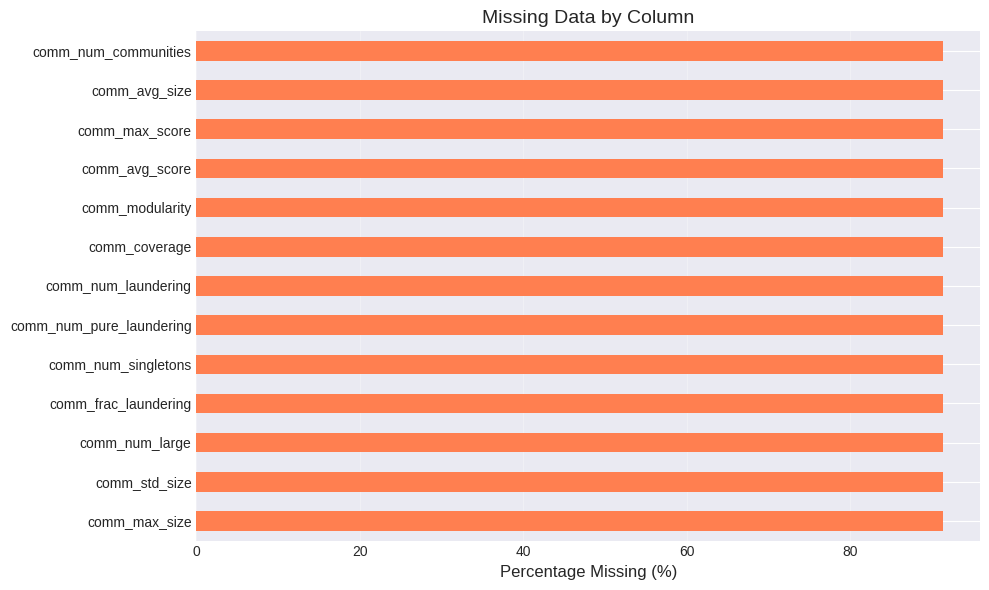


SECTION 1: PERFORMANCE ANALYSIS

METHOD PERFORMANCE ANALYSIS - AP

Top 10 Methods by Median AP:
--------------------------------------------------------------------------------
                              mean    median       std       min       max  count
method                                                                           
pagerank_wlog             0.024407  0.024145  0.004717  0.015815  0.031643     20
in_deg                    0.023815  0.023917  0.003953  0.016222  0.029766     20
ensemble_top3             0.023355  0.023910  0.002891  0.017355  0.027539     20
ensemble_diverse          0.023753  0.023529  0.003685  0.017272  0.029434     20
in_tx                     0.018767  0.018372  0.002940  0.015165  0.026310     20
out_deg                   0.018889  0.017345  0.006867  0.007094  0.034551     20
ensemble_ultimate         0.017765  0.017067  0.002749  0.013065  0.022349     20
in_amt                    0.016278  0.016934  0.004937  0.005903  0.024350     20
ou

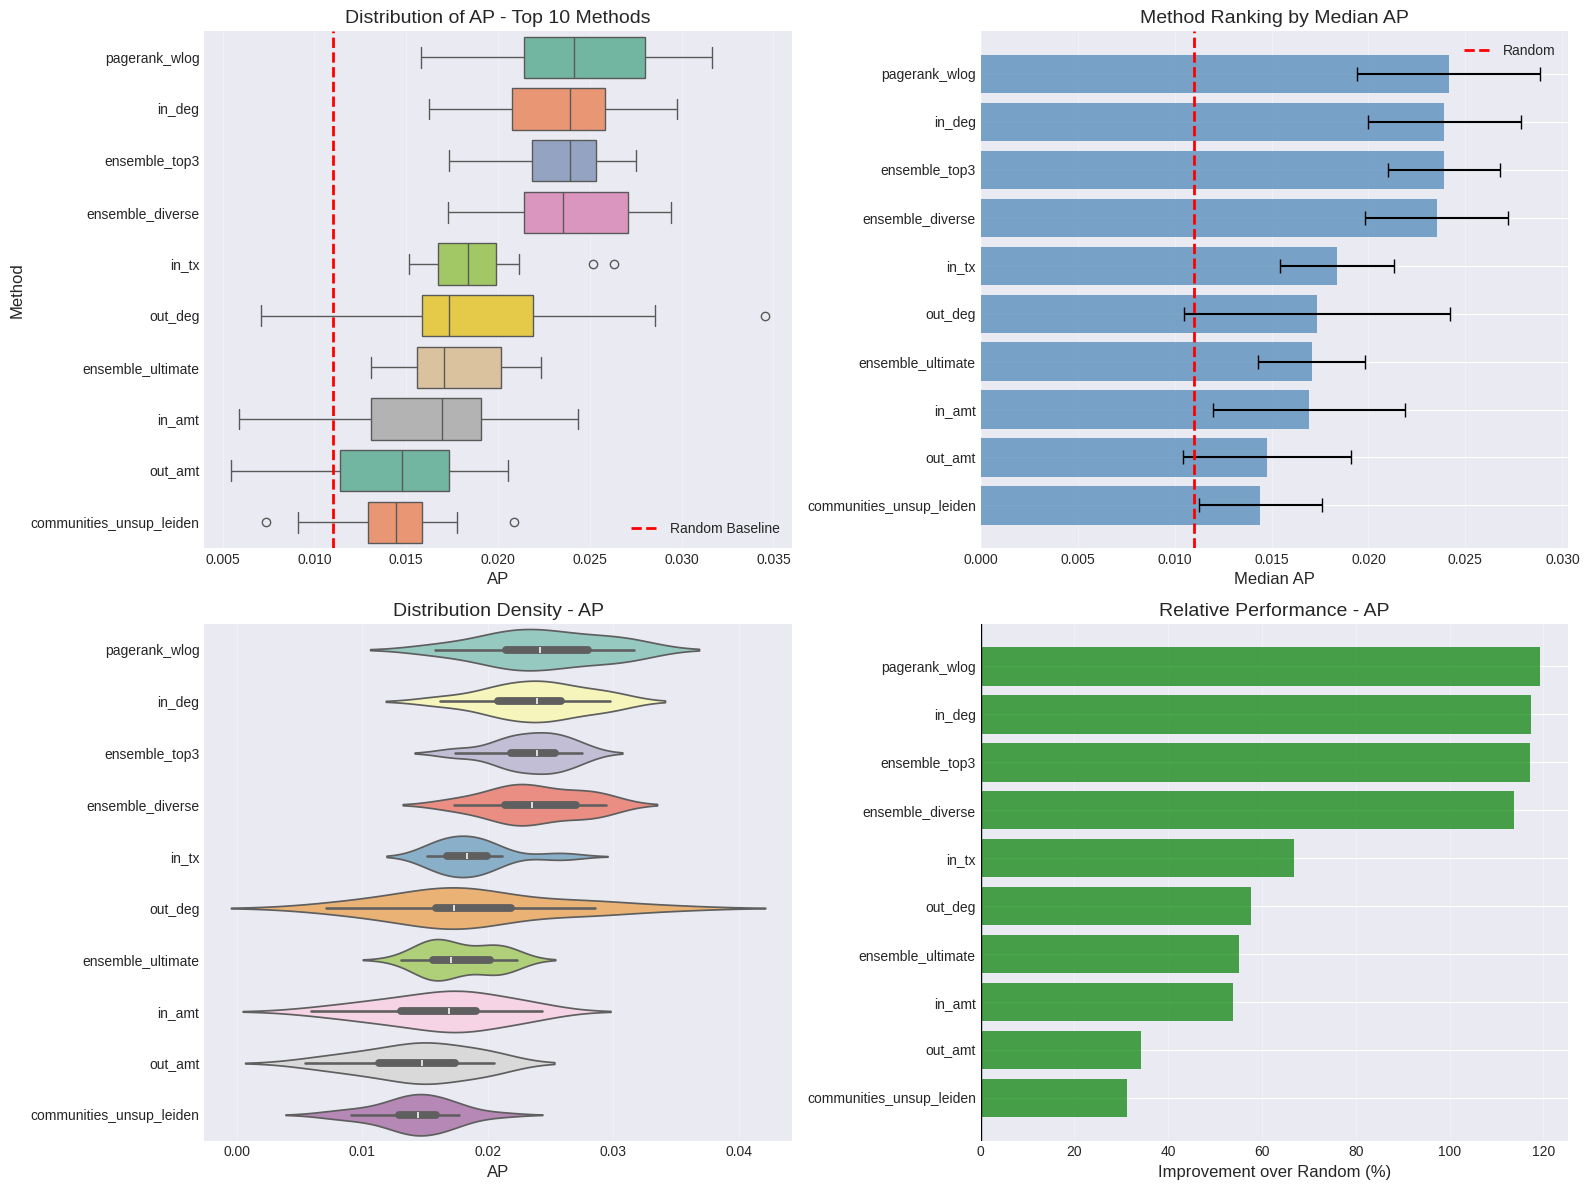


METHOD PERFORMANCE ANALYSIS - P_AT_1.0PCT

Top 10 Methods by Median P_AT_1.0PCT:
--------------------------------------------------------------------------------
                       mean    median       std       min       max  count
method                                                                    
ensemble_top3      0.073587  0.074911  0.007599  0.056974  0.088063     20
in_deg             0.074532  0.073212  0.007819  0.058939  0.094787     20
pagerank_wlog      0.070177  0.070622  0.005825  0.058939  0.079900     20
ensemble_diverse   0.070561  0.070568  0.006264  0.055980  0.079300     20
in_tx              0.067407  0.066777  0.009675  0.050220  0.085308     20
ensemble_ultimate  0.063664  0.065892  0.010339  0.036443  0.074150     20
kcore_in           0.051137  0.051505  0.020943  0.020408  0.099526     20
seeded_pr          0.054972  0.048673  0.029979  0.020408  0.109005     10
ensemble_seeded    0.045680  0.047950  0.008927  0.030612  0.056872     10
out_deg     

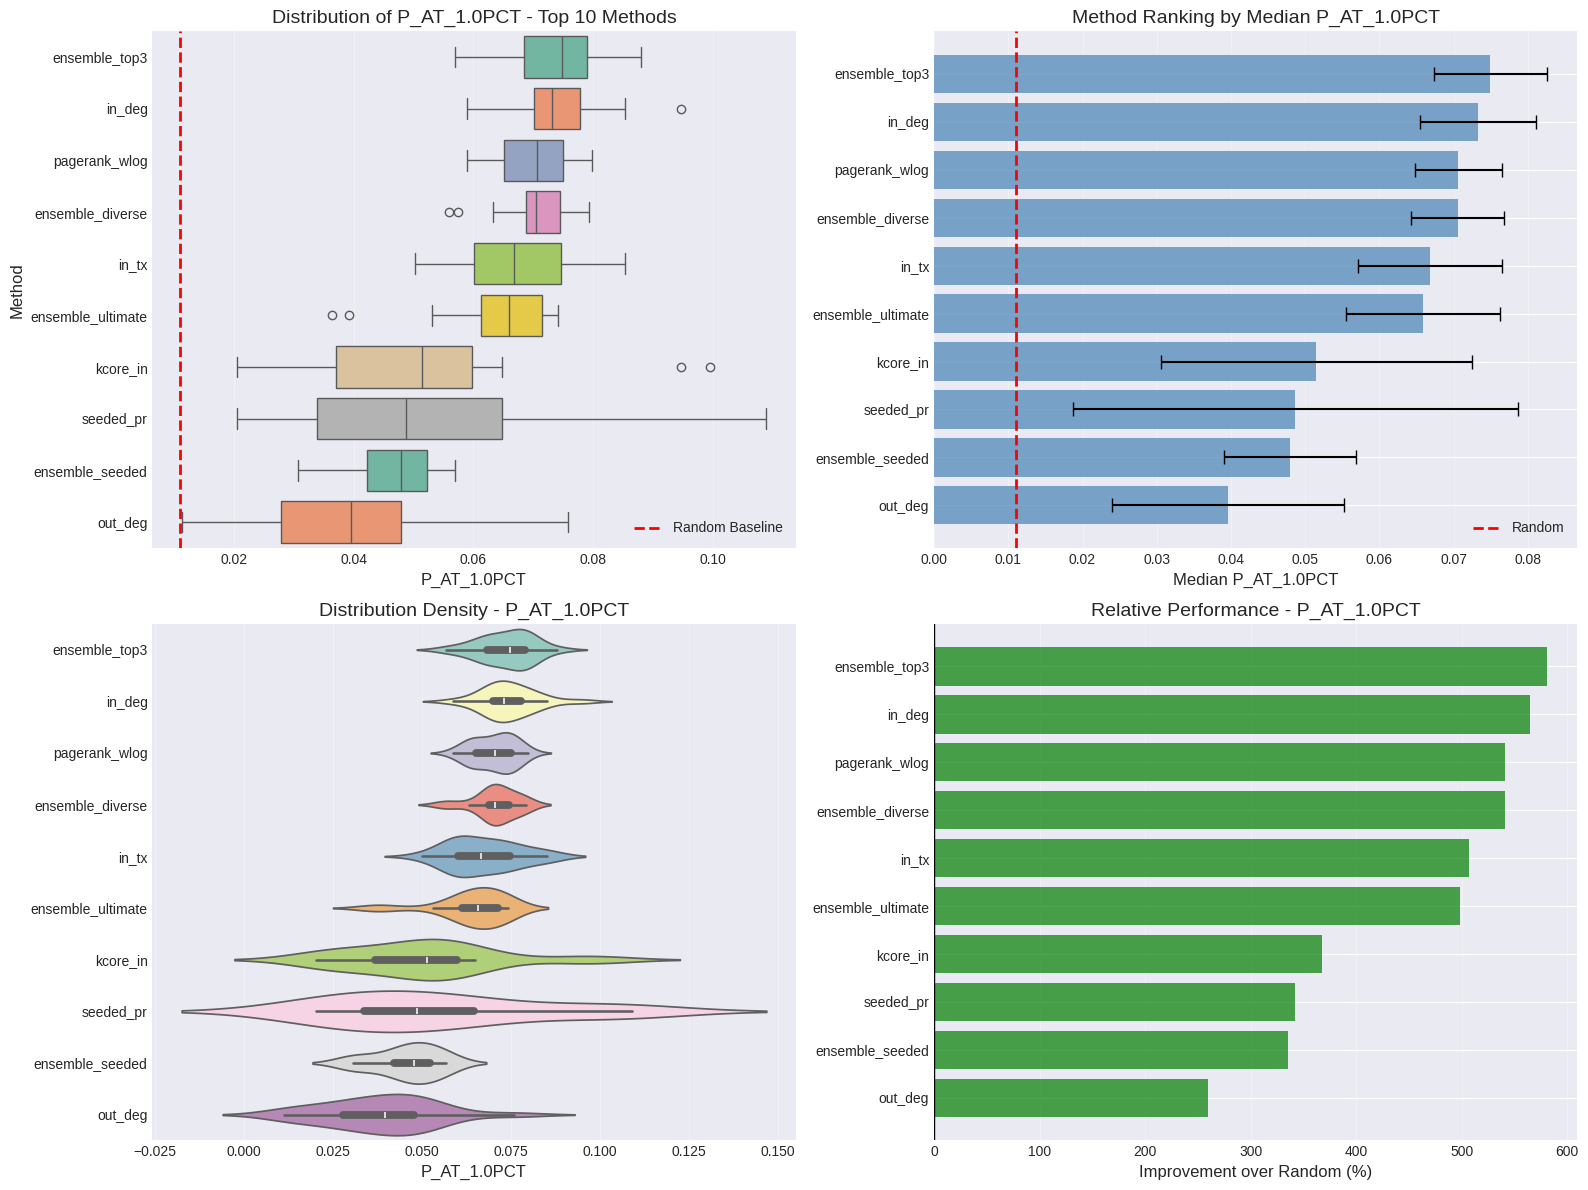


MULTI-METRIC COMPARISON

Top methods by composite score (normalized):
                         ap  p_at_1.0pct  attcov_at_1.0pct  composite_score
method                                                                     
out_deg            0.459035     0.194492          3.012102         1.221876
in_deg             1.971382     1.561960         -0.000592         1.177583
ensemble_top3      1.969633     1.631024         -0.156599         1.148019
ensemble_diverse   1.882025     1.454487         -0.180633         1.051960
pagerank_wlog      2.023769     1.456683         -0.441867         1.012862
seeded_pr         -0.873125     0.564452          2.660806         0.784044
in_tx              0.695161     1.300366         -0.217312         0.592739
ensemble_ultimate  0.395051     1.264401         -0.347018         0.437478
out_tx            -0.650783    -0.453458          1.603983         0.166581
ensemble_seeded   -0.290209     0.535081          0.099729         0.114867


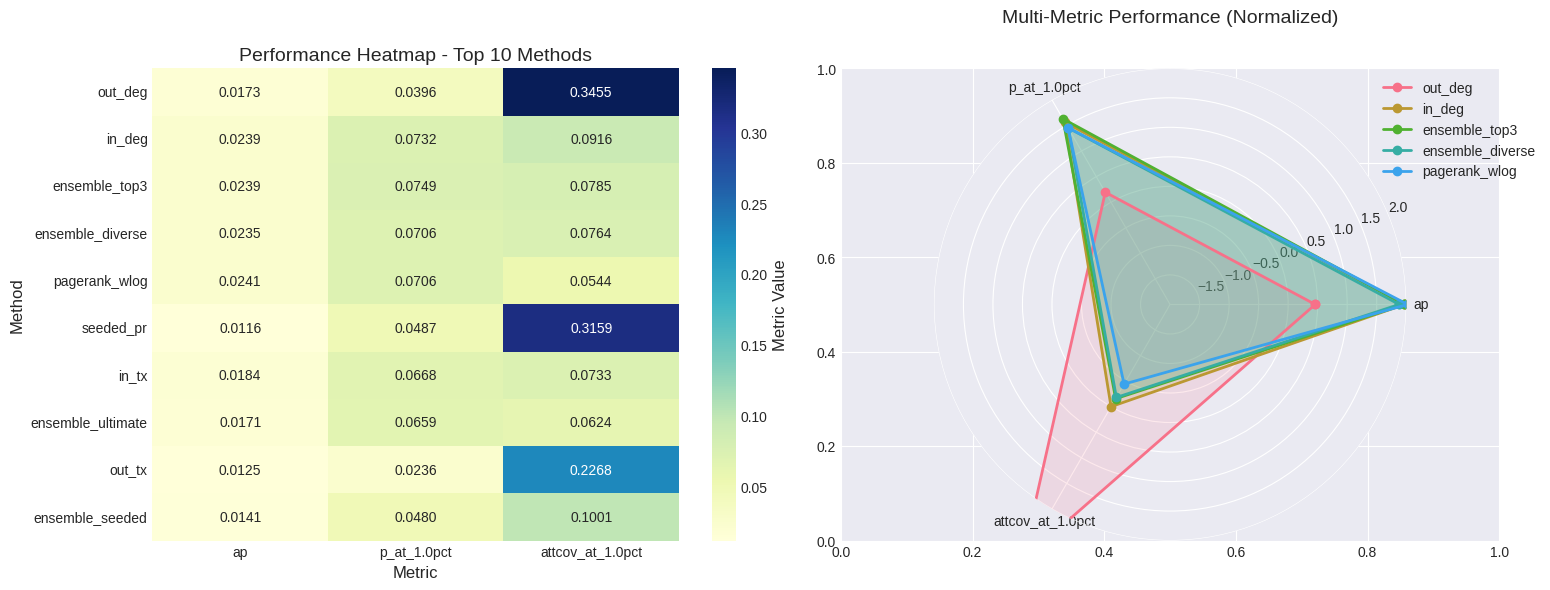


SECTION 2: TEMPORAL ANALYSIS

TEMPORAL TREND ANALYSIS


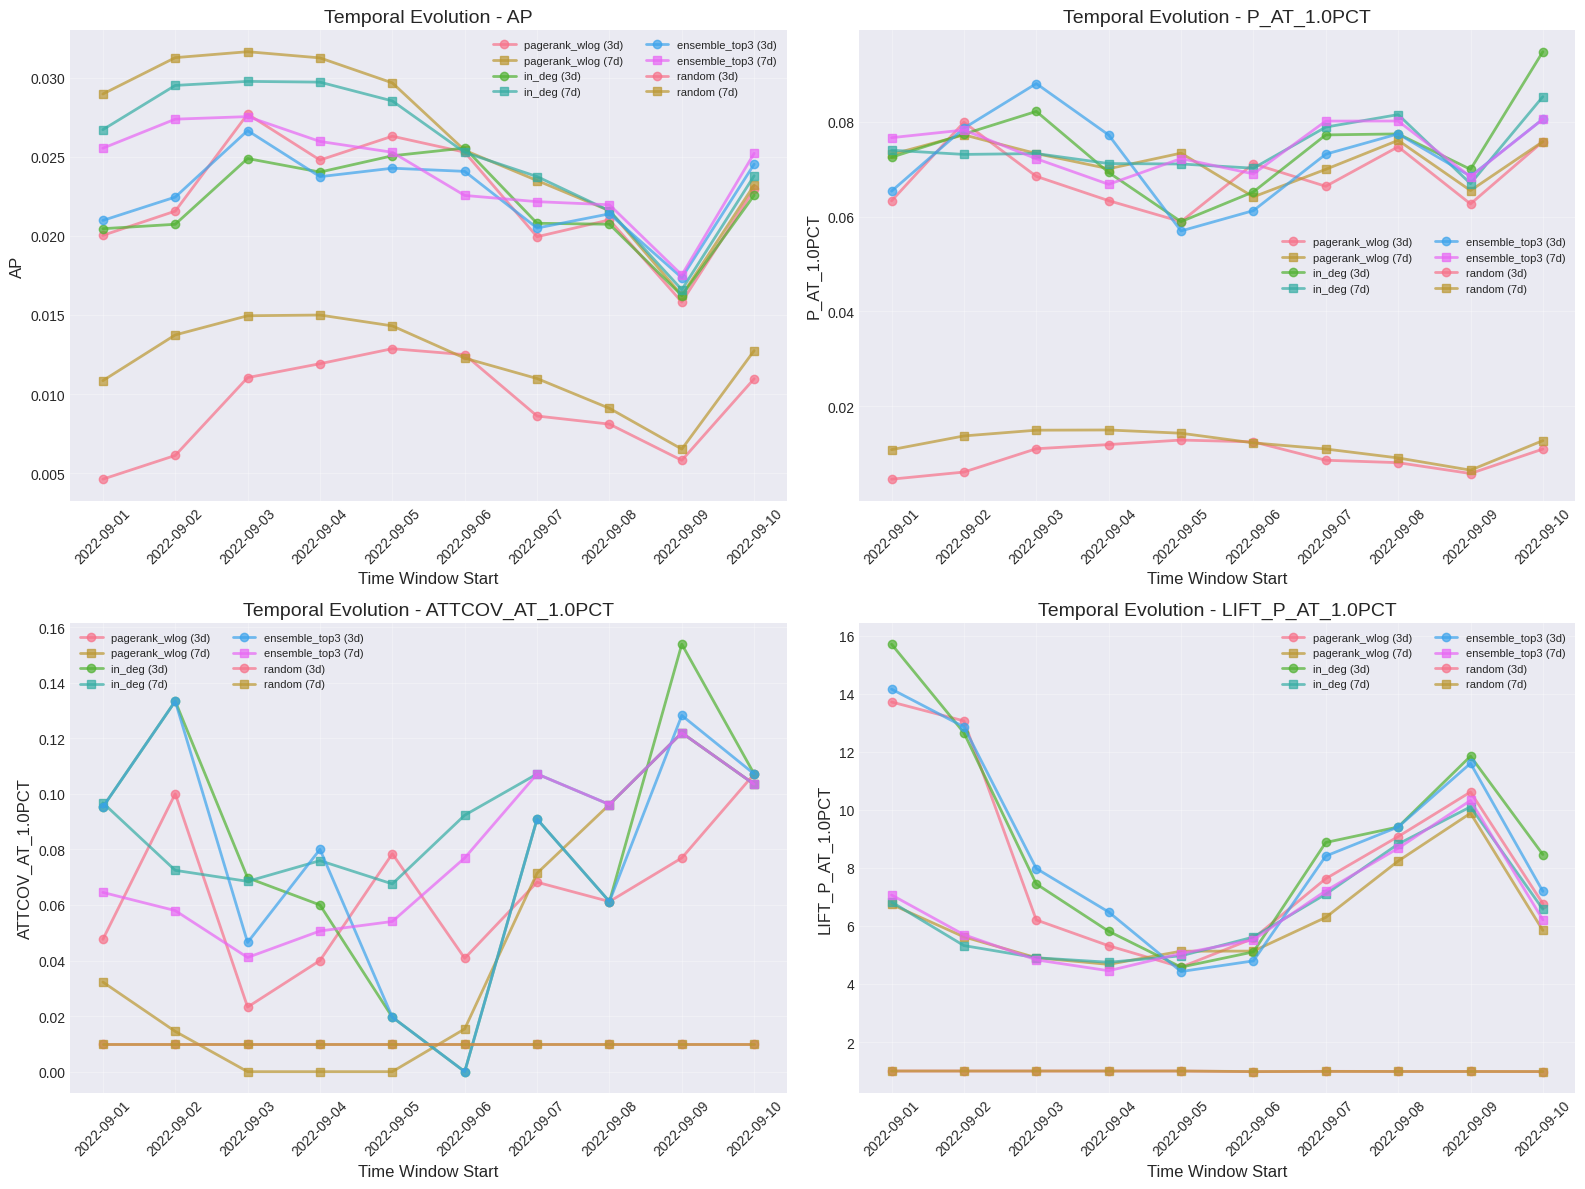


Stability Analysis (Standard Deviation across windows):
--------------------------------------------------------------------------------
method
ensemble_pattern     0.002522
pattern_features     0.002740
ensemble_ultimate    0.002749
ensemble_top3        0.002891
in_tx                0.002940
ensemble_seeded      0.003026
distributor          0.003067
hits_auth            0.003147
random               0.003147
hits_hub             0.003147
Name: ap, dtype: float64

WINDOW SIZE EFFECT ANALYSIS


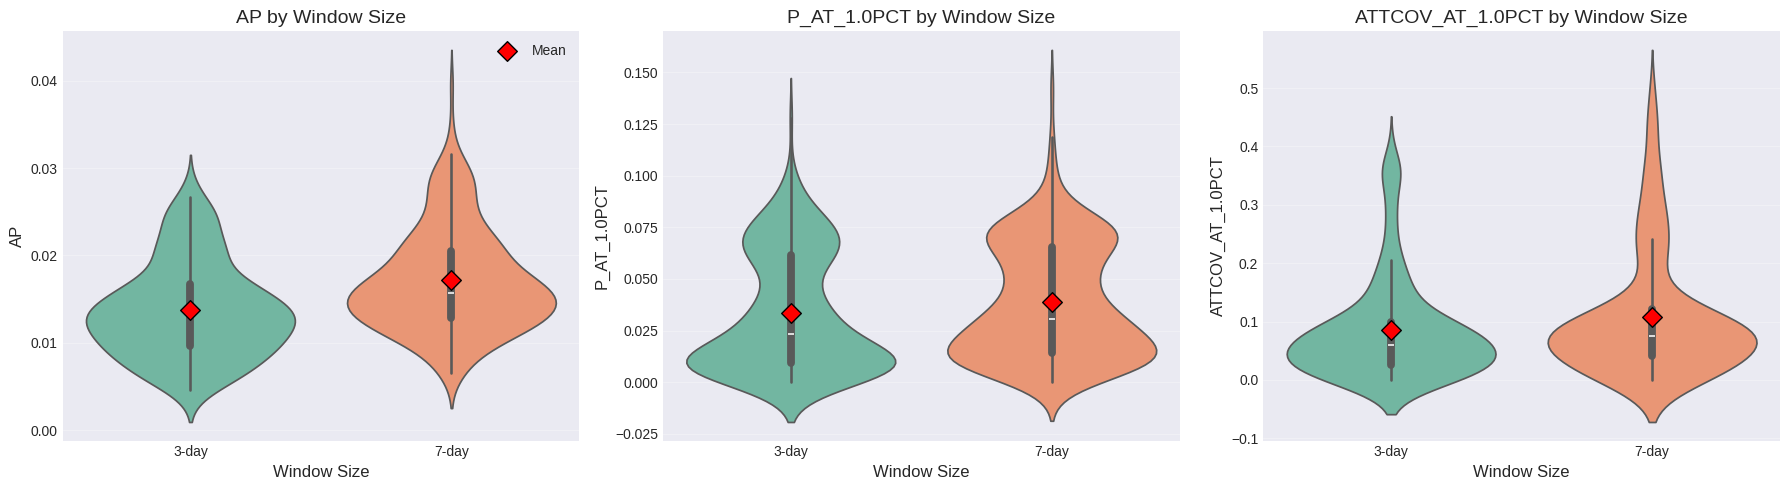


Statistical Significance Tests (Mann-Whitney U):
--------------------------------------------------------------------------------

ap:
  3-day median: 0.013034
  7-day median: 0.015744
  U-statistic: 17570.00
  p-value: 0.0000
  Significant: Yes (α=0.05)

p_at_1.0pct:
  3-day median: 0.023264
  7-day median: 0.030601
  U-statistic: 22339.50
  p-value: 0.0039
  Significant: Yes (α=0.05)

attcov_at_1.0pct:
  3-day median: 0.060612
  7-day median: 0.075949
  U-statistic: 22659.50
  p-value: 0.0078
  Significant: Yes (α=0.05)

SECTION 3: CORRELATION & FEATURE ANALYSIS

CORRELATION ANALYSIS


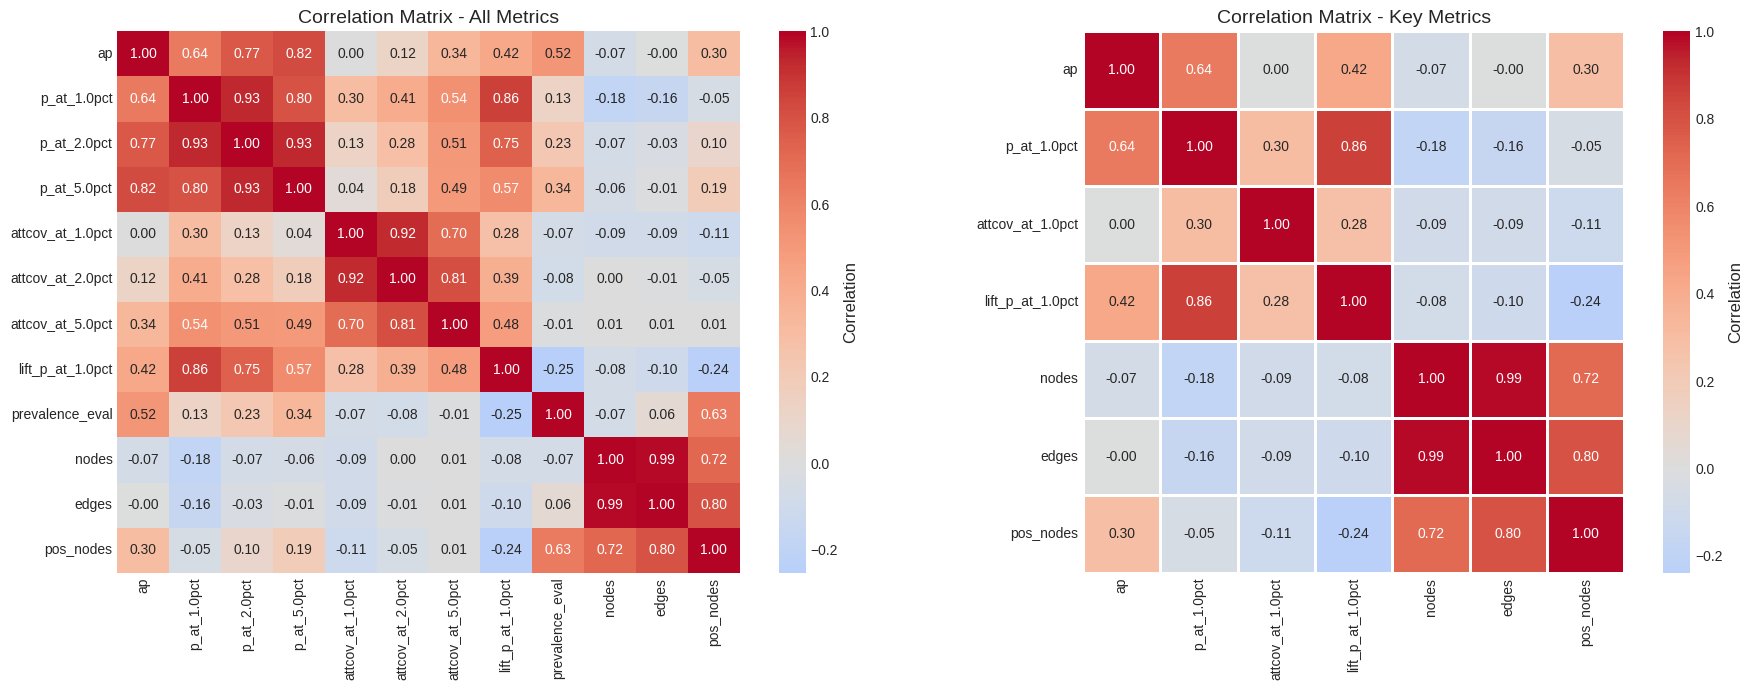


Strongest Positive Correlations:
--------------------------------------------------------------------------------
         metric1          metric2  correlation
           nodes            edges     0.989541
     p_at_2.0pct      p_at_5.0pct     0.929405
     p_at_1.0pct      p_at_2.0pct     0.928550
attcov_at_1.0pct attcov_at_2.0pct     0.924274
     p_at_1.0pct lift_p_at_1.0pct     0.862209
              ap      p_at_5.0pct     0.819413
attcov_at_2.0pct attcov_at_5.0pct     0.812189
     p_at_1.0pct      p_at_5.0pct     0.797904
           edges        pos_nodes     0.797272
              ap      p_at_2.0pct     0.770656

GRAPH STATISTICS ANALYSIS


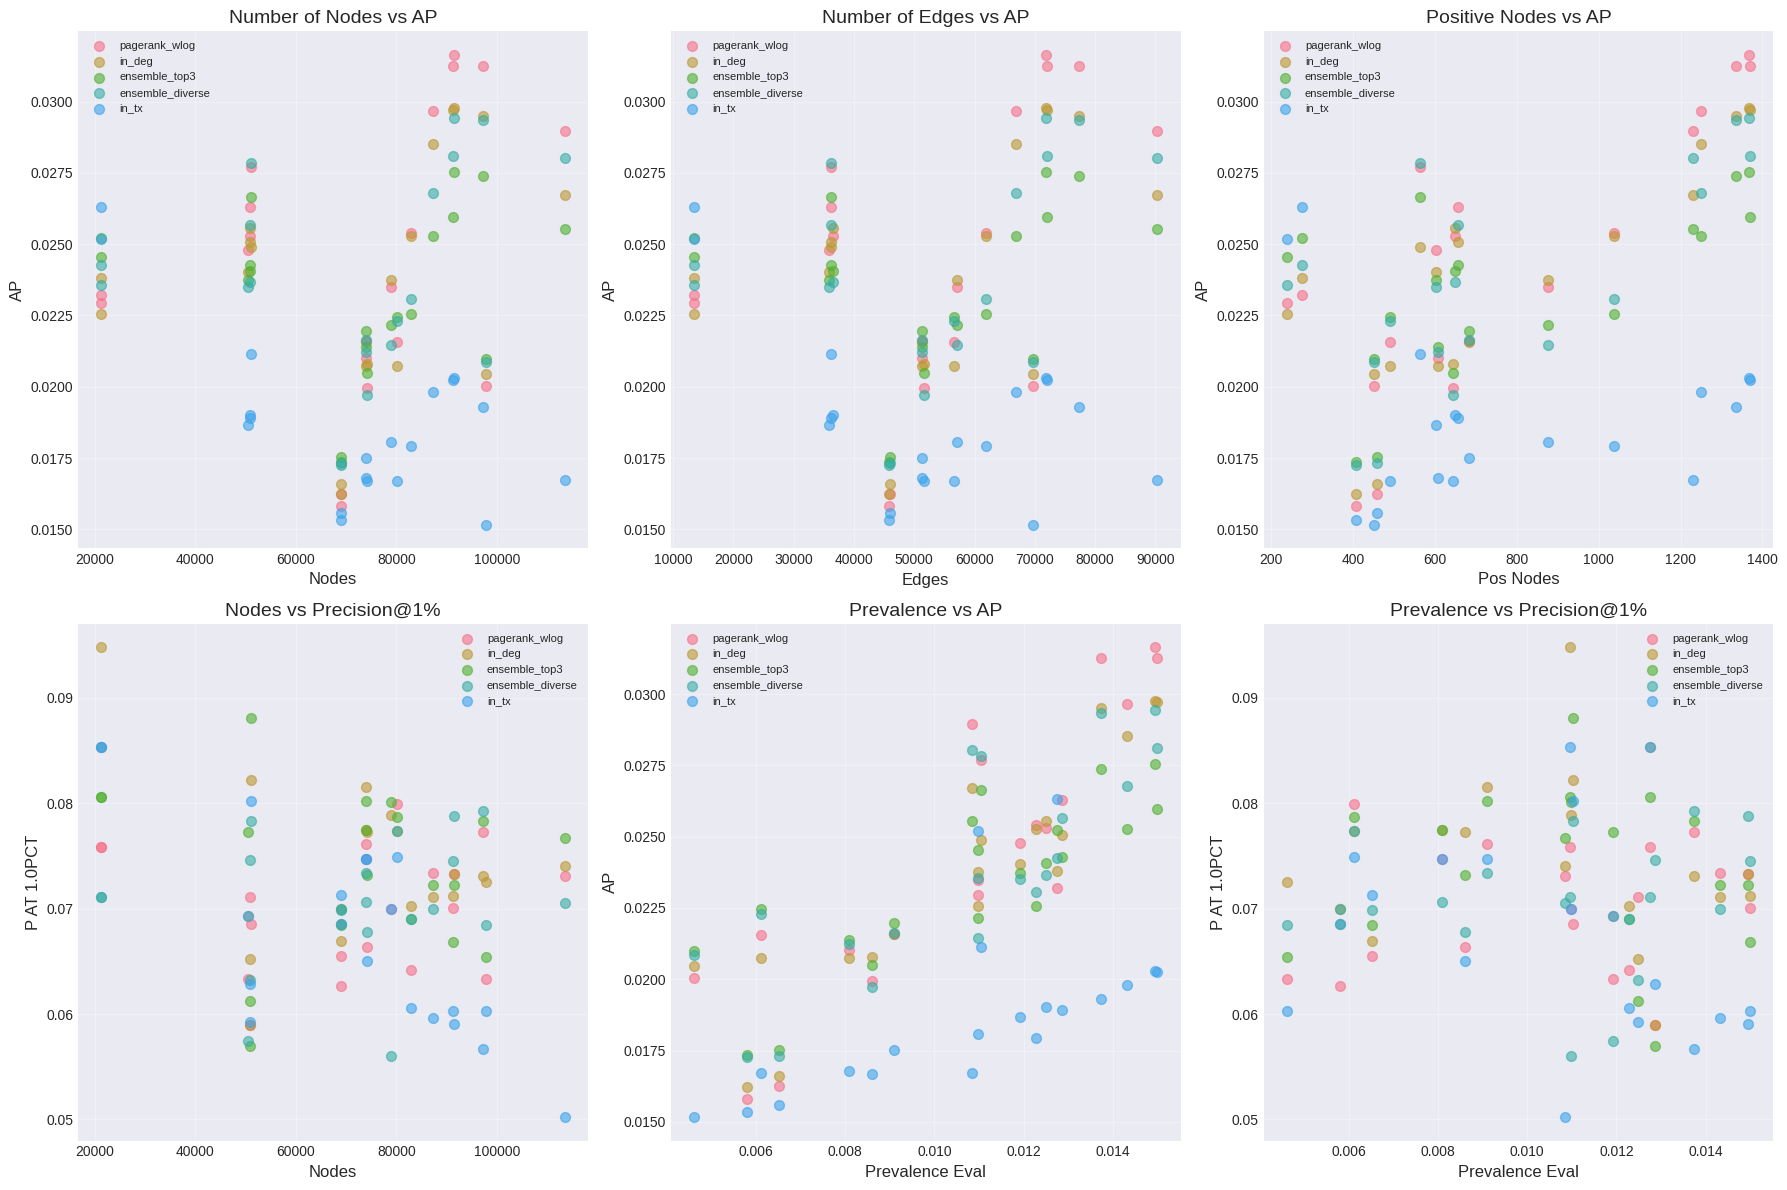


SECTION 4: METHOD COMPARISON

ENSEMBLE METHODS ANALYSIS

Ensemble methods: 5
Individual methods: 18


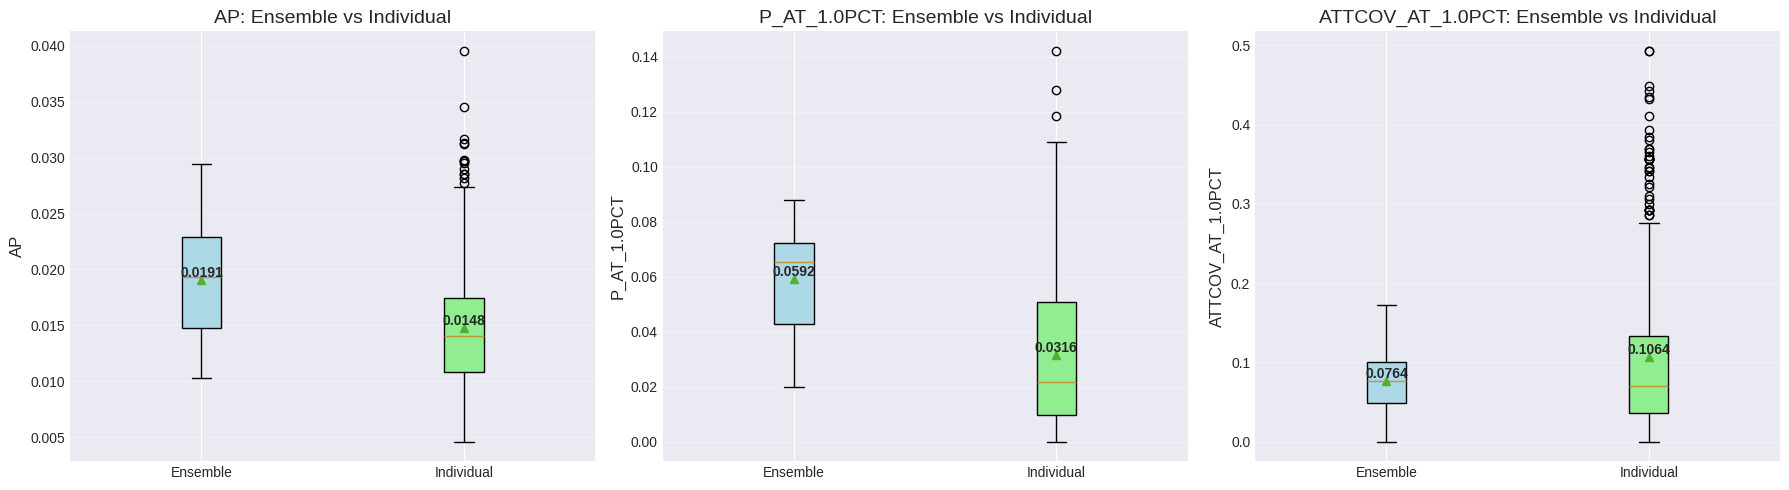


Statistical Tests (Mann-Whitney U):
--------------------------------------------------------------------------------

ap:
  Ensemble median: 0.019364
  Individual median: 0.014073
  p-value: 0.0000
  Significant: Yes

p_at_1.0pct:
  Ensemble median: 0.065286
  Individual median: 0.021654
  p-value: 0.0000
  Significant: Yes

attcov_at_1.0pct:
  Ensemble median: 0.076923
  Individual median: 0.069767
  p-value: 0.7392
  Significant: No

METHOD CATEGORY ANALYSIS


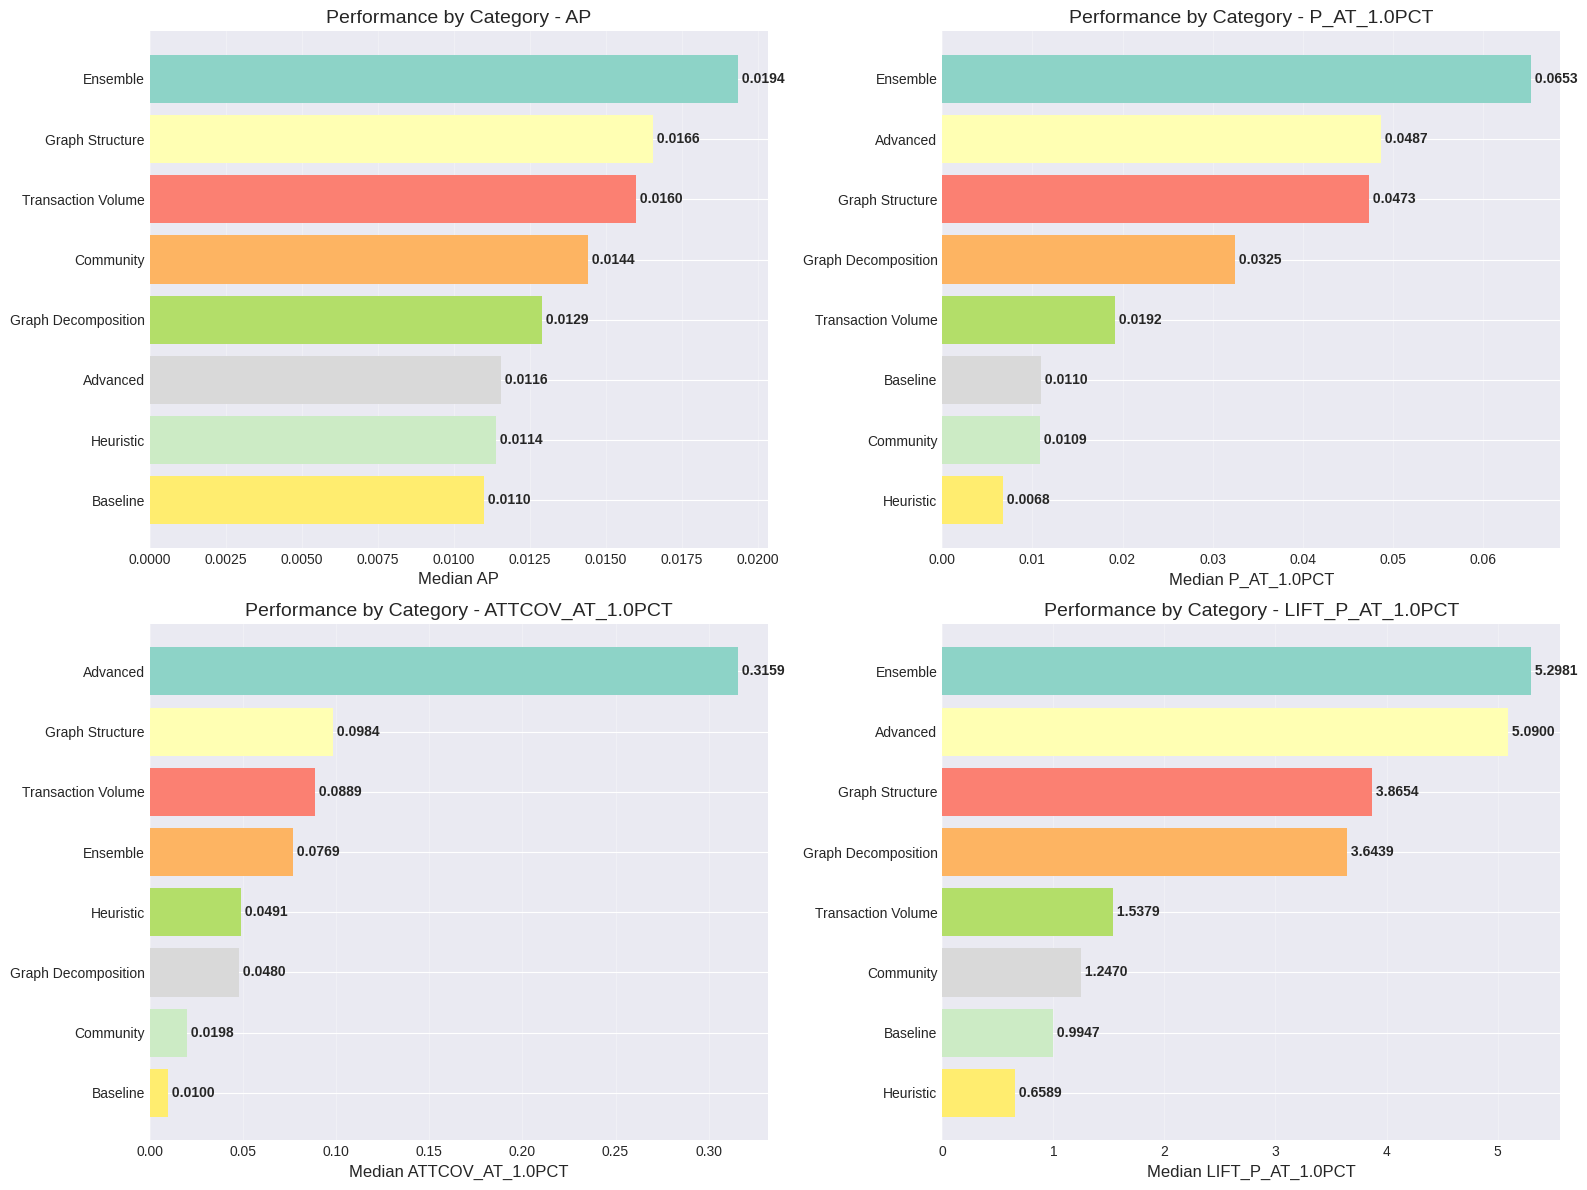


Category Performance Summary:
--------------------------------------------------------------------------------

AP:
                       median      mean       std  count
category                                                
Ensemble             0.019364  0.019051  0.005220     90
Graph Structure      0.016560  0.017681  0.007559    100
Transaction Volume   0.015992  0.015787  0.005307     80
Community            0.014432  0.014195  0.003161     40
Graph Decomposition  0.012900  0.012647  0.003718     60
Advanced             0.011557  0.011480  0.003150     10
Heuristic            0.011379  0.011785  0.003364     60
Baseline             0.011008  0.010648  0.003147     20

P_AT_1.0PCT:
                       median      mean       std  count
category                                                
Ensemble             0.065286  0.059167  0.017141     90
Advanced             0.048673  0.054972  0.029979     10
Graph Structure      0.047304  0.045318  0.028602    100
Graph Decompos

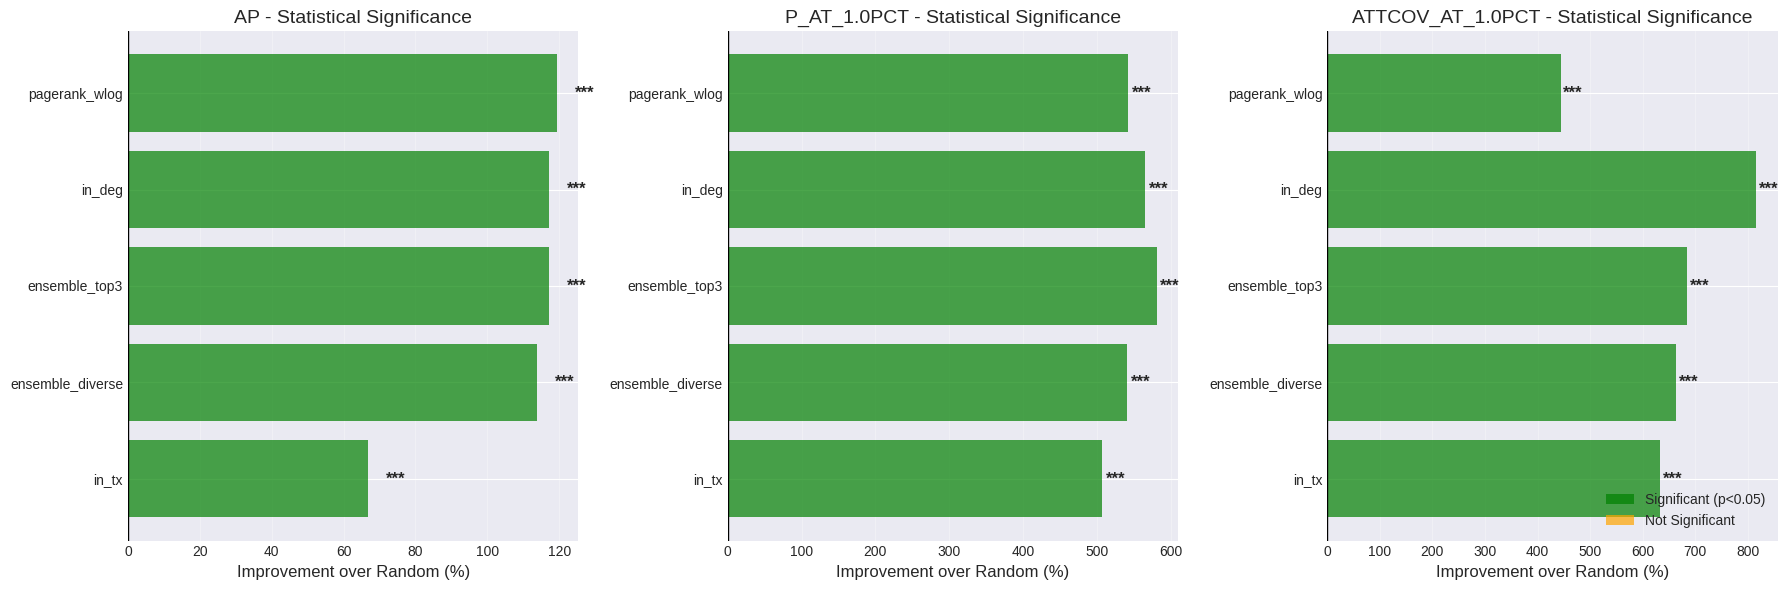


SECTION 6: PRECISION-COVERAGE ANALYSIS

PRECISION-COVERAGE TRADEOFF ANALYSIS


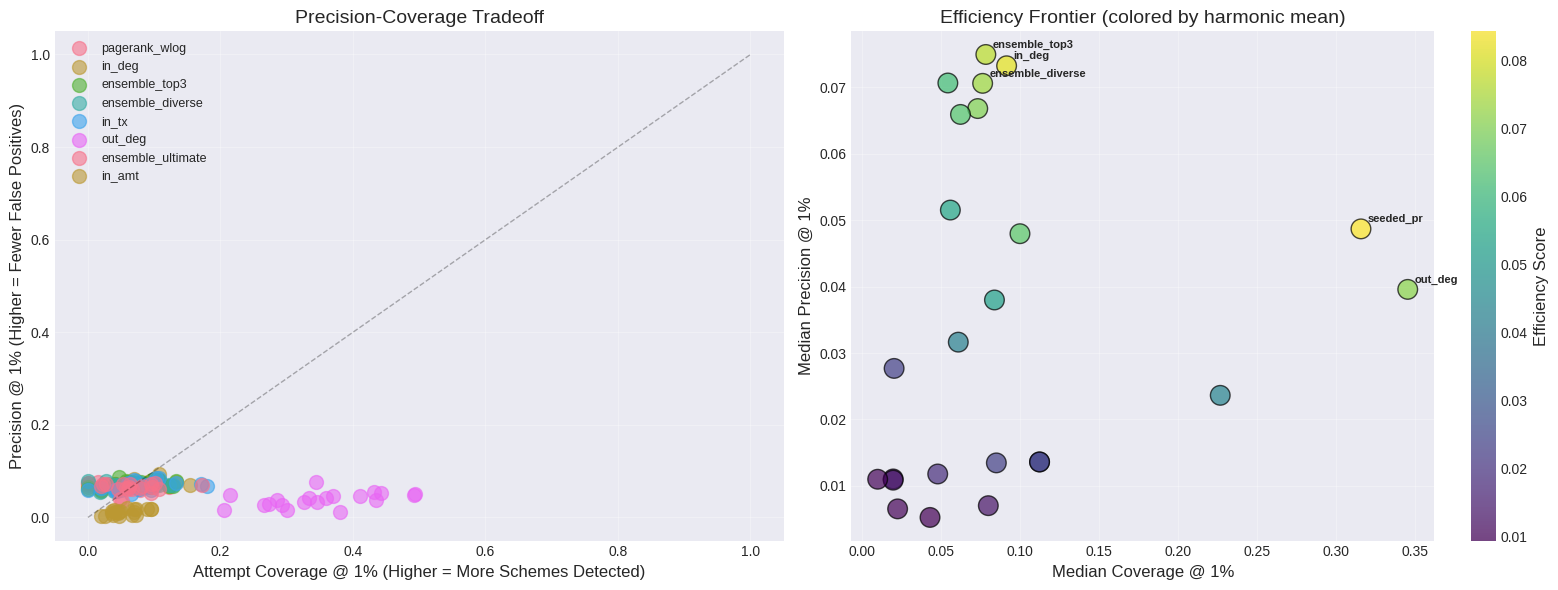


Top 10 Methods by Efficiency (Harmonic Mean):
--------------------------------------------------------------------------------
           method  precision  coverage  efficiency
        seeded_pr   0.048673  0.315887    0.084349
           in_deg   0.073212  0.091608    0.081384
    ensemble_top3   0.074911  0.078462    0.076645
 ensemble_diverse   0.070568  0.076436    0.073385
          out_deg   0.039571  0.345491    0.071010
            in_tx   0.066777  0.073345    0.069907
  ensemble_seeded   0.047950  0.100063    0.064833
ensemble_ultimate   0.065892  0.062415    0.064106
    pagerank_wlog   0.070622  0.054422    0.061473
         kcore_in   0.051505  0.056013    0.053664

SECTION 7: LIFT ANALYSIS

LIFT METRICS ANALYSIS


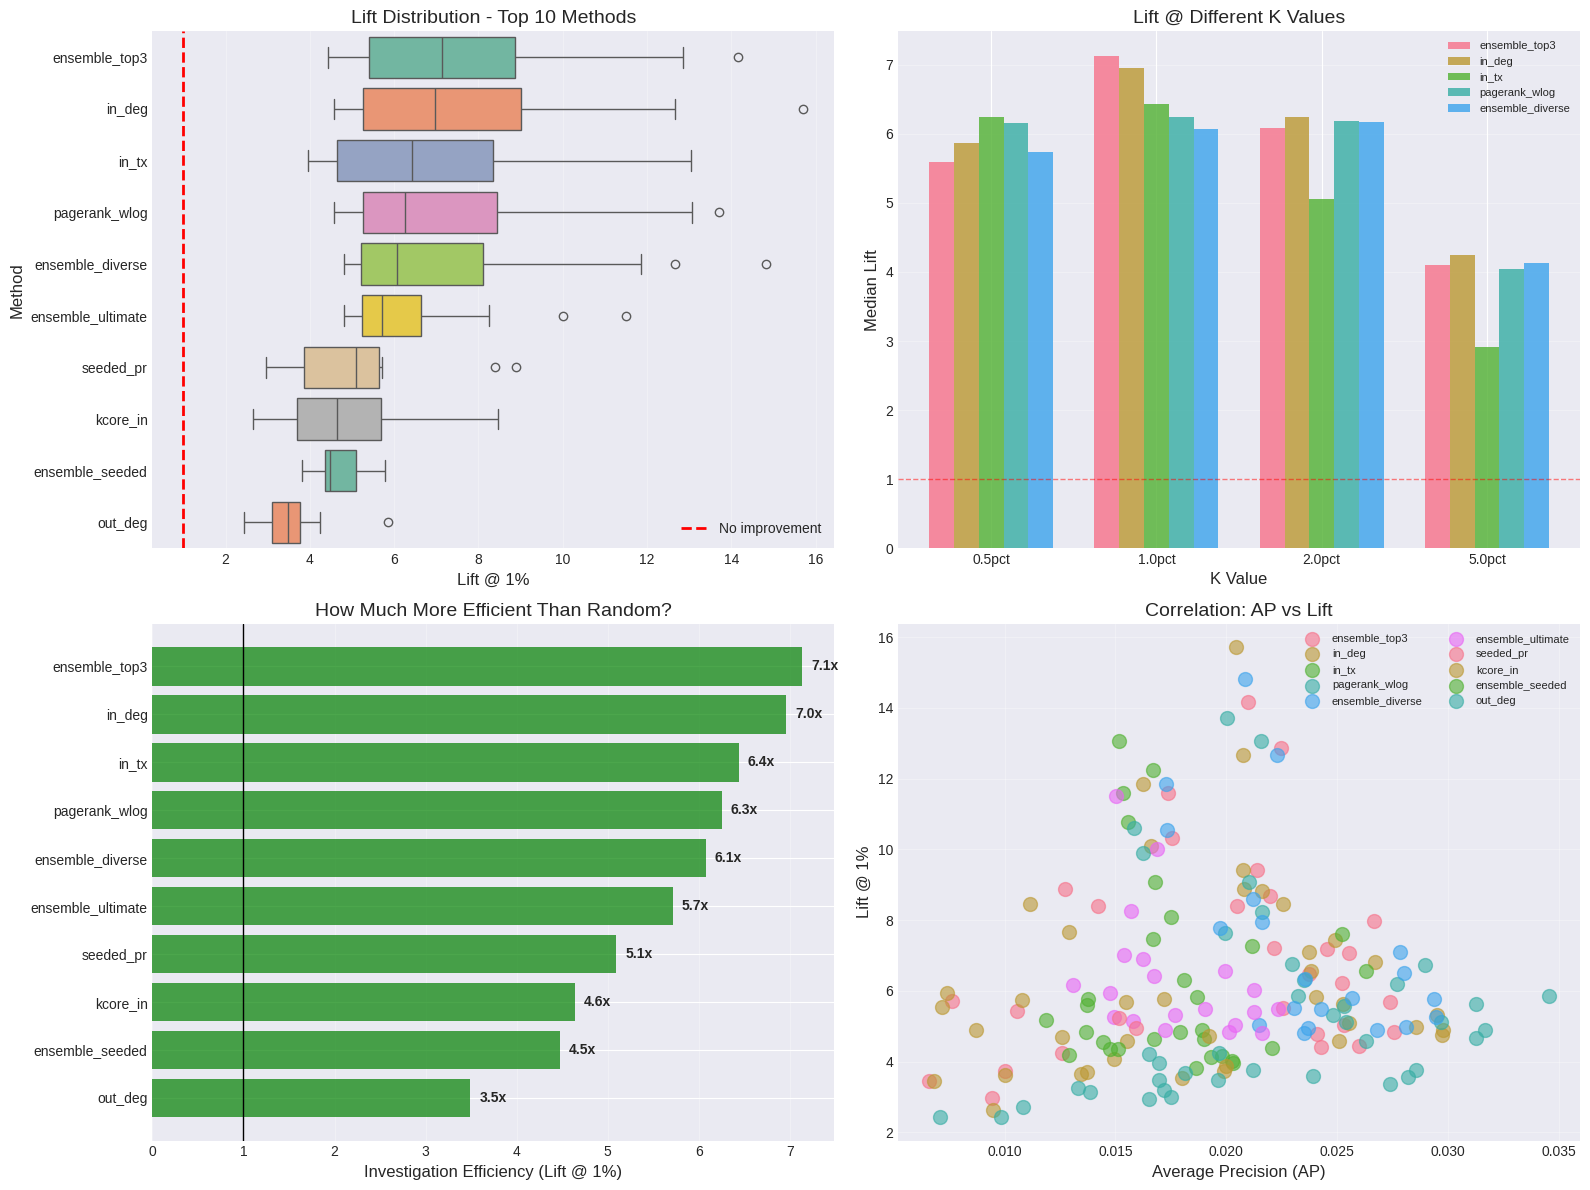


Investigation Efficiency Interpretation:
--------------------------------------------------------------------------------
Lift = How many times more efficient than random investigation

Top 10 Methods:
  out_deg                       :   3.49x  ✅ Good
  ensemble_seeded               :   4.47x  ✅ Good
  kcore_in                      :   4.64x  ✅ Good
  seeded_pr                     :   5.09x  ⭐ Excellent
  ensemble_ultimate             :   5.72x  ⭐ Excellent
  ensemble_diverse              :   6.07x  ⭐ Excellent
  pagerank_wlog                 :   6.25x  ⭐ Excellent
  in_tx                         :   6.44x  ⭐ Excellent
  in_deg                        :   6.96x  ⭐ Excellent
  ensemble_top3                 :   7.13x  ⭐ Excellent

SECTION 8: FINAL SUMMARY

COMPREHENSIVE SUMMARY REPORT

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total measurements: 460
Methods evaluated: 24
Time windows: 20
Window configurations: [3 7]
Date range: 

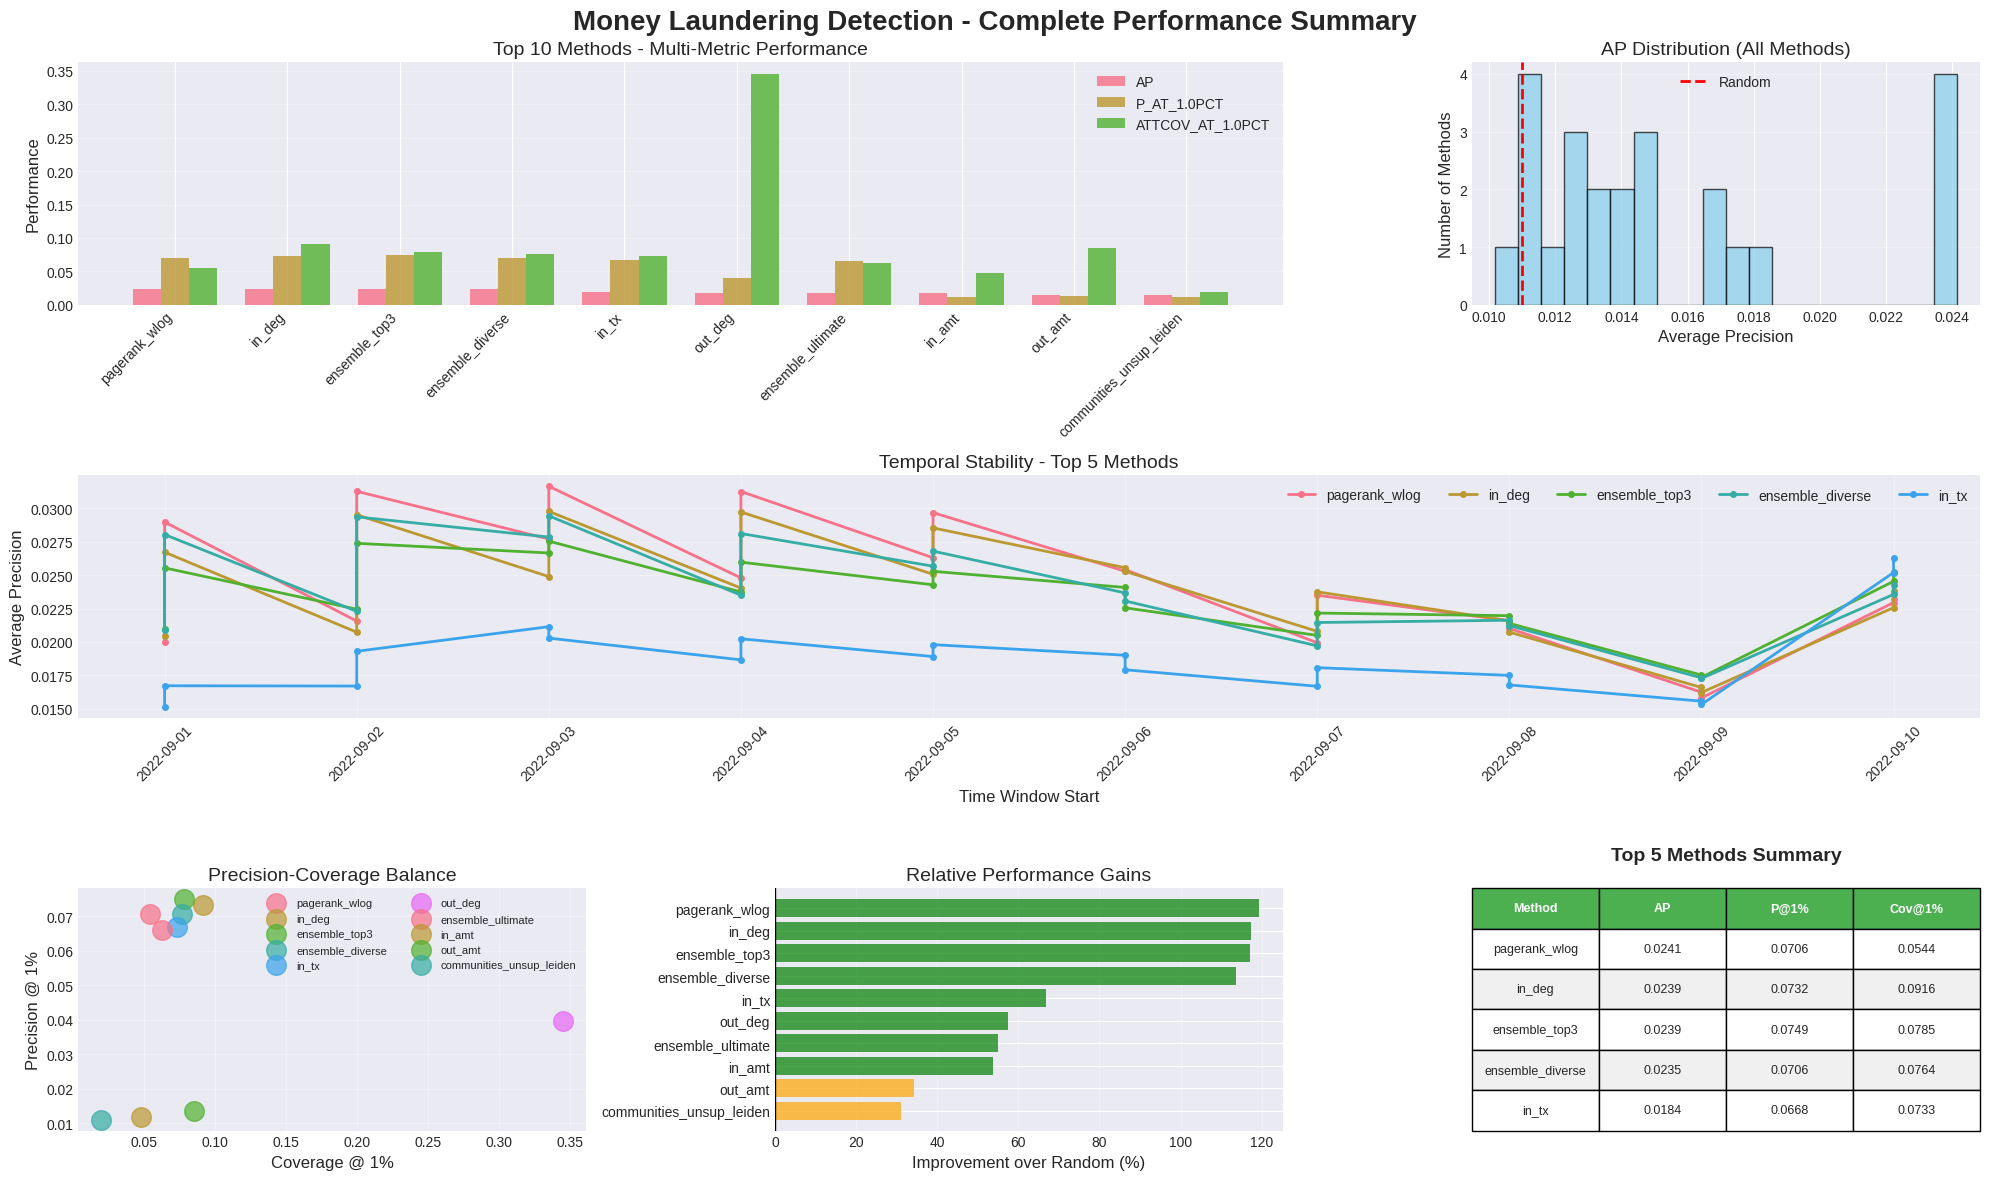


SAVING RESULTS
✓ Saved method statistics to /content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/analysis_plots/method_statistics_ap.csv
✓ Saved efficiency rankings to /content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/analysis_plots/efficiency_rankings.csv
✓ Saved significance tests to /content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/analysis_plots/significance_tests.csv
✓ Saved multi-metric comparison to /content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/analysis_plots/multi_metric_comparison.csv

ANALYSIS COMPLETE!

All plots saved to: /content/drive/MyDrive/AML/processed/LI_Small/US_Dollar/metrics/analysis_plots
Total plots generated: 13

Plot files:
   1. 01_missing_data.png
   2. 02_method_performance_ap.png
   3. 03_multi_metric_comparison.png
   4. 04_temporal_trends.png
   5. 05_window_size_effect.png
   6. 06_correlations.png
   7. 07_graph_statistics.png
   8. 08_ensemble_comparison.png
   9. 09_category_analysis.png
  10.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from scipy.stats import mannwhitneyu, wilcoxon, friedmanchisquare
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

warnings.filterwarnings('ignore')

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# ============================================================================
# CONFIGURATION FOR GOOGLE COLAB
# ============================================================================

# Mount Google Drive (uncomment when running in Colab)
from google.colab import drive
try:
  drive.mount('/content/drive', force_remount=False)
except ValueError:
  print("Drive already mounted")

# Path configuration - MODIFY THIS TO YOUR GOOGLE DRIVE PATH
BASE_PATH = Path('/content/drive/MyDrive/AML/processed/LI_Small/US_Dollar')

CSV_PATH = BASE_PATH / 'metrics' / 'window_metrics.csv'
print("csv path")
print(CSV_PATH)

# Alternative: Use local path if file is uploaded to Colab
# CSV_PATH = 'window_metrics.csv'

# Output directory for saving plots
OUTPUT_DIR = BASE_PATH / 'metrics' / 'analysis_plots'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*80)
print("MONEY LAUNDERING DETECTION - DATA SCIENCE ANALYSIS")
print("="*80)
print(f"\nData path: {CSV_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print()

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

def load_and_prepare_data(csv_path):
    """
    Load and prepare the metrics data for analysis.

    Parameters:
    -----------
    csv_path : Path
        Path to the window_metrics.csv file

    Returns:
    --------
    df : pd.DataFrame
        Prepared dataframe with additional computed columns
    """
    print("Loading data...")
    df = pd.read_csv(csv_path)

    # Convert date columns to datetime
    df['ws'] = pd.to_datetime(df['ws'])
    df['we'] = pd.to_datetime(df['we'])

    # Create additional useful columns
    df['window_duration'] = (df['we'] - df['ws']).dt.days
    df['window_id'] = df.groupby(['window_days', 'ws']).ngroup()

    # Calculate false positive rate at different k values
    for k in ['0.5pct', '1.0pct', '2.0pct', '5.0pct']:
        precision_col = f'p_at_{k}'
        if precision_col in df.columns:
            df[f'fpr_at_{k}'] = 1 - df[precision_col]

    # Calculate F1 score approximation (using prevalence as recall proxy)
    if 'p_at_1.0pct' in df.columns and 'prevalence_eval' in df.columns:
        precision = df['p_at_1.0pct']
        recall = df['prevalence_eval']
        df['f1_approx'] = 2 * (precision * recall) / (precision + recall + 1e-10)

    print(f"✓ Loaded {len(df):,} records")
    print(f"✓ Date range: {df['ws'].min()} to {df['we'].max()}")
    print(f"✓ Methods: {df['method'].nunique()}")
    print(f"✓ Window configurations: {df['window_days'].nunique()}")

    return df

# ============================================================================
# EXPLORATORY DATA ANALYSIS
# ============================================================================

def print_data_summary(df):
    """Print comprehensive data summary statistics."""
    print("\n" + "="*80)
    print("DATA SUMMARY")
    print("="*80)

    print("\n1. Dataset Overview")
    print("-" * 80)
    print(f"Total records: {len(df):,}")
    print(f"Methods analyzed: {df['method'].nunique()}")
    print(f"Time windows: {df['window_days'].nunique()} configurations ({df['window_days'].unique()})")
    print(f"Total unique windows: {df['window_id'].nunique()}")

    print("\n2. Methods Evaluated")
    print("-" * 80)
    methods = sorted(df['method'].unique())
    for i, method in enumerate(methods, 1):
        count = len(df[df['method'] == method])
        print(f"{i:2d}. {method:30s} ({count:3d} records)")

    print("\n3. Key Metrics Available")
    print("-" * 80)
    metrics_info = {
        'ap': 'Average Precision',
        'p_at_1.0pct': 'Precision @ 1%',
        'attcov_at_1.0pct': 'Attempt Coverage @ 1%',
        'lift_p_at_1.0pct': 'Lift @ 1%',
        'prevalence_eval': 'Fraud Prevalence',
        'nodes': 'Graph Nodes',
        'edges': 'Graph Edges',
        'pos_nodes': 'Positive Nodes'
    }

    for col, desc in metrics_info.items():
        if col in df.columns:
            print(f"  • {desc:30s}: {col}")

    print("\n4. Graph Statistics (Average)")
    print("-" * 80)
    print(f"Nodes per window: {df['nodes'].mean():,.0f} (±{df['nodes'].std():,.0f})")
    print(f"Edges per window: {df['edges'].mean():,.0f} (±{df['edges'].std():,.0f})")
    print(f"Positive nodes: {df['pos_nodes'].mean():,.0f} (±{df['pos_nodes'].std():,.0f})")
    print(f"Fraud prevalence: {df['prevalence_eval'].mean()*100:.3f}% (±{df['prevalence_eval'].std()*100:.3f}%)")

    print("\n5. Performance Ranges")
    print("-" * 80)
    for metric in ['ap', 'p_at_1.0pct', 'attcov_at_1.0pct']:
        if metric in df.columns:
            print(f"{metric:20s}: {df[metric].min():.4f} to {df[metric].max():.4f}")

def analyze_missing_data(df):
    """Analyze and visualize missing data patterns."""
    print("\n" + "="*80)
    print("MISSING DATA ANALYSIS")
    print("="*80)

    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)

    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Percentage': missing_pct
    }).sort_values('Percentage', ascending=False)

    missing_df = missing_df[missing_df['Missing_Count'] > 0]

    if len(missing_df) > 0:
        print(f"\nFound {len(missing_df)} columns with missing data:")
        print(missing_df)

        # Visualize
        if len(missing_df) <= 20:
            fig, ax = plt.subplots(figsize=(10, 6))
            missing_df['Percentage'].plot(kind='barh', ax=ax, color='coral')
            ax.set_xlabel('Percentage Missing (%)')
            ax.set_title('Missing Data by Column')
            ax.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.savefig(OUTPUT_DIR / '01_missing_data.png', dpi=300, bbox_inches='tight')
            plt.show()
    else:
        print("\n✓ No missing data found!")

# ============================================================================
# PERFORMANCE ANALYSIS
# ============================================================================

def analyze_method_performance(df, metric='ap', top_n=10):
    """
    Analyze and visualize method performance.

    Parameters:
    -----------
    df : pd.DataFrame
        Metrics dataframe
    metric : str
        Performance metric to analyze
    top_n : int
        Number of top methods to highlight
    """
    print(f"\n{'='*80}")
    print(f"METHOD PERFORMANCE ANALYSIS - {metric.upper()}")
    print("="*80)

    # Calculate statistics by method
    method_stats = df.groupby('method')[metric].agg([
        'mean', 'median', 'std', 'min', 'max', 'count'
    ]).sort_values('median', ascending=False)

    print(f"\nTop {top_n} Methods by Median {metric.upper()}:")
    print("-" * 80)
    print(method_stats.head(top_n).to_string())

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Box plot of top methods
    ax1 = axes[0, 0]
    top_methods = method_stats.head(top_n).index
    df_top = df[df['method'].isin(top_methods)]
    df_top_sorted = df_top.copy()
    df_top_sorted['method'] = pd.Categorical(
        df_top_sorted['method'],
        categories=top_methods,
        ordered=True
    )
    sns.boxplot(data=df_top_sorted, y='method', x=metric, ax=ax1, palette='Set2')
    ax1.set_title(f'Distribution of {metric.upper()} - Top {top_n} Methods')
    ax1.set_xlabel(metric.upper())
    ax1.set_ylabel('Method')
    ax1.axvline(df[df['method']=='random'][metric].median(),
                color='red', linestyle='--', label='Random Baseline', linewidth=2)
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)

    # 2. Bar plot with error bars (median + IQR)
    ax2 = axes[0, 1]
    method_stats_top = method_stats.head(top_n)
    x_pos = np.arange(len(method_stats_top))
    ax2.barh(x_pos, method_stats_top['median'],
             xerr=method_stats_top['std'],
             alpha=0.7, capsize=5, color='steelblue')
    ax2.set_yticks(x_pos)
    ax2.set_yticklabels(method_stats_top.index)
    ax2.set_xlabel(f'Median {metric.upper()}')
    ax2.set_title(f'Method Ranking by Median {metric.upper()}')
    ax2.axvline(df[df['method']=='random'][metric].median(),
                color='red', linestyle='--', label='Random', linewidth=2)
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)
    ax2.invert_yaxis()

    # 3. Violin plot
    ax3 = axes[1, 0]
    sns.violinplot(data=df_top_sorted, y='method', x=metric, ax=ax3, palette='Set3')
    ax3.set_title(f'Distribution Density - {metric.upper()}')
    ax3.set_xlabel(metric.upper())
    ax3.set_ylabel('')
    ax3.grid(axis='x', alpha=0.3)

    # 4. Performance vs Random comparison
    ax4 = axes[1, 1]
    random_median = df[df['method']=='random'][metric].median()
    improvements = ((method_stats_top['median'] - random_median) / random_median * 100)
    colors = ['green' if x > 0 else 'red' for x in improvements]
    ax4.barh(range(len(improvements)), improvements, color=colors, alpha=0.7)
    ax4.set_yticks(range(len(improvements)))
    ax4.set_yticklabels(improvements.index)
    ax4.set_xlabel('Improvement over Random (%)')
    ax4.set_title(f'Relative Performance - {metric.upper()}')
    ax4.axvline(0, color='black', linestyle='-', linewidth=1)
    ax4.grid(axis='x', alpha=0.3)
    ax4.invert_yaxis()

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'02_method_performance_{metric}.png', dpi=300, bbox_inches='tight')
    plt.show()

    return method_stats

def compare_multiple_metrics(df, metrics=['ap', 'p_at_1.0pct', 'attcov_at_1.0pct'], top_n=10):
    """Compare methods across multiple metrics simultaneously."""
    print(f"\n{'='*80}")
    print("MULTI-METRIC COMPARISON")
    print("="*80)

    # Calculate median for each metric and method
    results = {}
    for metric in metrics:
        if metric in df.columns:
            results[metric] = df.groupby('method')[metric].median()

    comparison_df = pd.DataFrame(results)

    # Normalize to 0-100 scale for comparison
    scaler = StandardScaler()
    comparison_normalized = pd.DataFrame(
        scaler.fit_transform(comparison_df),
        index=comparison_df.index,
        columns=comparison_df.columns
    )

    # Calculate composite score
    comparison_normalized['composite_score'] = comparison_normalized.mean(axis=1)
    comparison_sorted = comparison_normalized.sort_values('composite_score', ascending=False)

    print("\nTop methods by composite score (normalized):")
    print(comparison_sorted.head(top_n))

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Heatmap
    ax1 = axes[0]
    top_methods = comparison_sorted.head(top_n).index
    sns.heatmap(comparison_df.loc[top_methods], annot=True, fmt='.4f',
                cmap='YlGnBu', ax=ax1, cbar_kws={'label': 'Metric Value'})
    ax1.set_title(f'Performance Heatmap - Top {top_n} Methods')
    ax1.set_xlabel('Metric')
    ax1.set_ylabel('Method')

    # Radar/Spider chart
    ax2 = axes[1]
    top_5 = comparison_sorted.head(5).drop('composite_score', axis=1)

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    ax2 = plt.subplot(122, projection='polar')

    for idx, method in enumerate(top_5.index):
        values = top_5.loc[method].values.tolist()
        values += values[:1]  # Complete the circle
        ax2.plot(angles, values, 'o-', linewidth=2, label=method)
        ax2.fill(angles, values, alpha=0.15)

    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(metrics)
    ax2.set_ylim(-2, 2)
    ax2.set_title('Multi-Metric Performance (Normalized)', y=1.08)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '03_multi_metric_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    return comparison_df, comparison_normalized

# ============================================================================
# TEMPORAL ANALYSIS
# ============================================================================

def analyze_temporal_trends(df, methods=['pagerank_wlog', 'in_deg', 'ensemble_top3', 'random']):
    """Analyze how method performance changes over time windows."""
    print(f"\n{'='*80}")
    print("TEMPORAL TREND ANALYSIS")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    metrics_to_plot = ['ap', 'p_at_1.0pct', 'attcov_at_1.0pct', 'lift_p_at_1.0pct']

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]

        for method in methods:
            method_data = df[df['method'] == method].sort_values('ws')

            # Separate by window size
            for window_days in sorted(df['window_days'].unique()):
                window_data = method_data[method_data['window_days'] == window_days]
                if not window_data.empty:
                    label = f"{method} ({window_days}d)"
                    marker = 'o' if window_days == 3 else 's'
                    ax.plot(window_data['ws'], window_data[metric],
                           marker=marker, label=label, alpha=0.7, linewidth=2)

        ax.set_xlabel('Time Window Start')
        ax.set_ylabel(metric.upper())
        ax.set_title(f'Temporal Evolution - {metric.upper()}')
        ax.legend(fontsize=8, ncol=2)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '04_temporal_trends.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Stability analysis
    print("\nStability Analysis (Standard Deviation across windows):")
    print("-" * 80)
    stability = df.groupby('method')['ap'].std().sort_values()
    print(stability.head(10))

    return stability

def analyze_window_size_effect(df):
    """Compare performance between different window sizes."""
    print(f"\n{'='*80}")
    print("WINDOW SIZE EFFECT ANALYSIS")
    print("="*80)

    # Statistical comparison
    metrics = ['ap', 'p_at_1.0pct', 'attcov_at_1.0pct']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        # Create comparison data
        window_comparison = []
        for window_days in sorted(df['window_days'].unique()):
            window_data = df[df['window_days'] == window_days]
            window_comparison.append({
                'window_days': f"{window_days}-day",
                'median': window_data[metric].median(),
                'mean': window_data[metric].mean(),
                'std': window_data[metric].std()
            })

        comp_df = pd.DataFrame(window_comparison)

        # Violin plot by window size
        df_plot = df[['window_days', metric]].copy()
        df_plot['window_days'] = df_plot['window_days'].astype(str) + '-day'

        sns.violinplot(data=df_plot, x='window_days', y=metric, ax=ax, palette='Set2')
        ax.set_xlabel('Window Size')
        ax.set_ylabel(metric.upper())
        ax.set_title(f'{metric.upper()} by Window Size')
        ax.grid(axis='y', alpha=0.3)

        # Add mean markers
        for i, row in comp_df.iterrows():
            ax.scatter(i, row['mean'], color='red', s=100, zorder=10,
                      marker='D', edgecolors='black', label='Mean' if i == 0 else '')

        if idx == 0:
            ax.legend()

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '05_window_size_effect.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Statistical tests
    print("\nStatistical Significance Tests (Mann-Whitney U):")
    print("-" * 80)

    window_sizes = sorted(df['window_days'].unique())
    if len(window_sizes) == 2:
        for metric in metrics:
            data1 = df[df['window_days'] == window_sizes[0]][metric].dropna()
            data2 = df[df['window_days'] == window_sizes[1]][metric].dropna()

            statistic, pvalue = mannwhitneyu(data1, data2, alternative='two-sided')

            print(f"\n{metric}:")
            print(f"  {window_sizes[0]}-day median: {data1.median():.6f}")
            print(f"  {window_sizes[1]}-day median: {data2.median():.6f}")
            print(f"  U-statistic: {statistic:.2f}")
            print(f"  p-value: {pvalue:.4f}")
            print(f"  Significant: {'Yes' if pvalue < 0.05 else 'No'} (α=0.05)")

# ============================================================================
# CORRELATION AND FEATURE ANALYSIS
# ============================================================================

def analyze_correlations(df):
    """Analyze correlations between different metrics."""
    print(f"\n{'='*80}")
    print("CORRELATION ANALYSIS")
    print("="*80)

    # Select numeric columns for correlation
    numeric_cols = [
        'ap', 'p_at_1.0pct', 'p_at_2.0pct', 'p_at_5.0pct',
        'attcov_at_1.0pct', 'attcov_at_2.0pct', 'attcov_at_5.0pct',
        'lift_p_at_1.0pct', 'prevalence_eval', 'nodes', 'edges', 'pos_nodes'
    ]

    # Filter existing columns
    numeric_cols = [col for col in numeric_cols if col in df.columns]

    corr_matrix = df[numeric_cols].corr()

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Full correlation heatmap
    ax1 = axes[0]
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, ax=ax1, cbar_kws={'label': 'Correlation'})
    ax1.set_title('Correlation Matrix - All Metrics')

    # Focus on key metrics
    key_metrics = ['ap', 'p_at_1.0pct', 'attcov_at_1.0pct', 'lift_p_at_1.0pct',
                   'nodes', 'edges', 'pos_nodes']
    key_metrics = [col for col in key_metrics if col in df.columns]

    ax2 = axes[1]
    key_corr = df[key_metrics].corr()
    sns.heatmap(key_corr, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, ax=ax2, cbar_kws={'label': 'Correlation'},
                square=True, linewidths=1)
    ax2.set_title('Correlation Matrix - Key Metrics')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '06_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print strongest correlations
    print("\nStrongest Positive Correlations:")
    print("-" * 80)
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append({
                'metric1': corr_matrix.columns[i],
                'metric2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

    corr_df = pd.DataFrame(corr_pairs).sort_values('correlation', ascending=False)
    print(corr_df.head(10).to_string(index=False))

    return corr_matrix

def analyze_graph_statistics(df):
    """Analyze relationship between graph properties and performance."""
    print(f"\n{'='*80}")
    print("GRAPH STATISTICS ANALYSIS")
    print("="*80)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    top_methods = df.groupby('method')['ap'].median().nlargest(5).index

    # Scatter plots
    scatter_configs = [
        ('nodes', 'ap', 'Number of Nodes vs AP'),
        ('edges', 'ap', 'Number of Edges vs AP'),
        ('pos_nodes', 'ap', 'Positive Nodes vs AP'),
        ('nodes', 'p_at_1.0pct', 'Nodes vs Precision@1%'),
        ('prevalence_eval', 'ap', 'Prevalence vs AP'),
        ('prevalence_eval', 'p_at_1.0pct', 'Prevalence vs Precision@1%')
    ]

    for idx, (x_col, y_col, title) in enumerate(scatter_configs):
        ax = axes[idx // 3, idx % 3]

        for method in top_methods:
            method_data = df[df['method'] == method]
            ax.scatter(method_data[x_col], method_data[y_col],
                      label=method, alpha=0.6, s=50)

        ax.set_xlabel(x_col.replace('_', ' ').title())
        ax.set_ylabel(y_col.replace('_', ' ').upper())
        ax.set_title(title)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '07_graph_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# ENSEMBLE AND METHOD COMPARISON
# ============================================================================

def analyze_ensemble_methods(df):
    """Analyze ensemble methods vs individual methods."""
    print(f"\n{'='*80}")
    print("ENSEMBLE METHODS ANALYSIS")
    print("="*80)

    # Identify ensemble vs individual methods
    ensemble_methods = [m for m in df['method'].unique() if 'ensemble' in m.lower()]
    individual_methods = [m for m in df['method'].unique()
                         if 'ensemble' not in m.lower() and m != 'random']

    print(f"\nEnsemble methods: {len(ensemble_methods)}")
    print(f"Individual methods: {len(individual_methods)}")

    # Performance comparison
    metrics = ['ap', 'p_at_1.0pct', 'attcov_at_1.0pct']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        # Prepare data
        ensemble_data = df[df['method'].isin(ensemble_methods)]
        individual_data = df[df['method'].isin(individual_methods)]

        plot_data = pd.DataFrame({
            'Ensemble': ensemble_data[metric],
            'Individual': individual_data[metric]
        })

        # Box plot
        bp = ax.boxplot([ensemble_data[metric].dropna(),
                         individual_data[metric].dropna()],
                        labels=['Ensemble', 'Individual'],
                        patch_artist=True,
                        showmeans=True)

        # Color boxes
        colors = ['lightblue', 'lightgreen']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        ax.set_ylabel(metric.upper())
        ax.set_title(f'{metric.upper()}: Ensemble vs Individual')
        ax.grid(axis='y', alpha=0.3)

        # Add mean values as text
        ensemble_mean = ensemble_data[metric].mean()
        individual_mean = individual_data[metric].mean()
        ax.text(1, ensemble_mean, f'{ensemble_mean:.4f}',
               ha='center', va='bottom', fontweight='bold')
        ax.text(2, individual_mean, f'{individual_mean:.4f}',
               ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '08_ensemble_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Statistical test
    print("\nStatistical Tests (Mann-Whitney U):")
    print("-" * 80)

    for metric in metrics:
        ensemble_vals = df[df['method'].isin(ensemble_methods)][metric].dropna()
        individual_vals = df[df['method'].isin(individual_methods)][metric].dropna()

        if len(ensemble_vals) > 0 and len(individual_vals) > 0:
            statistic, pvalue = mannwhitneyu(ensemble_vals, individual_vals)

            print(f"\n{metric}:")
            print(f"  Ensemble median: {ensemble_vals.median():.6f}")
            print(f"  Individual median: {individual_vals.median():.6f}")
            print(f"  p-value: {pvalue:.4f}")
            print(f"  Significant: {'Yes' if pvalue < 0.05 else 'No'}")

def analyze_method_categories(df):
    """Categorize and analyze methods by type."""
    print(f"\n{'='*80}")
    print("METHOD CATEGORY ANALYSIS")
    print("="*80)

    # Define categories
    categories = {
        'Graph Structure': ['pagerank_wlog', 'in_deg', 'out_deg', 'hits_hub', 'hits_auth'],
        'Graph Decomposition': ['kcore_in', 'kcore_out', 'kcore_und'],
        'Transaction Volume': ['in_tx', 'out_tx', 'in_amt', 'out_amt'],
        'Heuristic': ['collector', 'distributor', 'pattern_features'],
        'Community': ['communities_unsup_louvain', 'communities_unsup_leiden'],
        'Ensemble': ['ensemble_top3', 'ensemble_ultimate', 'ensemble_diverse',
                     'ensemble_pattern', 'ensemble_seeded'],
        'Advanced': ['seeded_pr'],
        'Baseline': ['random']
    }

    # Add category column
    def get_category(method):
        for cat, methods in categories.items():
            if method in methods:
                return cat
        return 'Other'

    df['category'] = df['method'].apply(get_category)

    # Performance by category
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    metrics = ['ap', 'p_at_1.0pct', 'attcov_at_1.0pct', 'lift_p_at_1.0pct']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]

        category_stats = df.groupby('category')[metric].median().sort_values(ascending=False)

        colors = plt.cm.Set3(np.linspace(0, 1, len(category_stats)))
        bars = ax.barh(range(len(category_stats)), category_stats.values, color=colors)
        ax.set_yticks(range(len(category_stats)))
        ax.set_yticklabels(category_stats.index)
        ax.set_xlabel(f'Median {metric.upper()}')
        ax.set_title(f'Performance by Category - {metric.upper()}')
        ax.grid(axis='x', alpha=0.3)
        ax.invert_yaxis()

        # Add values on bars
        for i, (cat, val) in enumerate(category_stats.items()):
            ax.text(val, i, f' {val:.4f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '09_category_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print category summary
    print("\nCategory Performance Summary:")
    print("-" * 80)
    for metric in ['ap', 'p_at_1.0pct']:
        print(f"\n{metric.upper()}:")
        cat_stats = df.groupby('category')[metric].agg(['median', 'mean', 'std', 'count'])
        print(cat_stats.sort_values('median', ascending=False).to_string())

# ============================================================================
# STATISTICAL SIGNIFICANCE TESTING
# ============================================================================

def perform_statistical_tests(df, top_n=5):
    """Perform comprehensive statistical significance tests."""
    print(f"\n{'='*80}")
    print("STATISTICAL SIGNIFICANCE TESTING")
    print("="*80)

    # Get top methods
    top_methods = df.groupby('method')['ap'].median().nlargest(top_n).index.tolist()

    if 'random' not in top_methods:
        top_methods.append('random')

    print(f"\nComparing top {top_n} methods against random baseline")
    print(f"Methods: {', '.join(top_methods)}")

    # Pairwise comparisons
    print("\n" + "-" * 80)
    print("PAIRWISE COMPARISONS (Mann-Whitney U Test)")
    print("-" * 80)

    metrics = ['ap', 'p_at_1.0pct', 'attcov_at_1.0pct']

    results = []

    for metric in metrics:
        print(f"\n{metric.upper()}:")

        random_data = df[df['method'] == 'random'][metric].dropna()

        for method in top_methods:
            if method == 'random':
                continue

            method_data = df[df['method'] == method][metric].dropna()

            if len(method_data) > 0:
                statistic, pvalue = mannwhitneyu(method_data, random_data,
                                                 alternative='greater')

                improvement = ((method_data.median() - random_data.median()) /
                              random_data.median() * 100)

                results.append({
                    'metric': metric,
                    'method': method,
                    'method_median': method_data.median(),
                    'random_median': random_data.median(),
                    'improvement_%': improvement,
                    'p_value': pvalue,
                    'significant': pvalue < 0.05
                })

                sig_marker = '***' if pvalue < 0.001 else '**' if pvalue < 0.01 else '*' if pvalue < 0.05 else ''

                print(f"  {method:30s}: p={pvalue:.6f} {sig_marker:3s} "
                      f"(improvement: {improvement:+.1f}%)")

    results_df = pd.DataFrame(results)

    # Visualize significance
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        metric_results = results_df[results_df['metric'] == metric]

        # Bar plot with significance markers
        colors = ['green' if sig else 'orange'
                 for sig in metric_results['significant']]

        bars = ax.barh(range(len(metric_results)),
                      metric_results['improvement_%'],
                      color=colors, alpha=0.7)

        ax.set_yticks(range(len(metric_results)))
        ax.set_yticklabels(metric_results['method'])
        ax.set_xlabel('Improvement over Random (%)')
        ax.set_title(f'{metric.upper()} - Statistical Significance')
        ax.axvline(0, color='black', linestyle='-', linewidth=1)
        ax.grid(axis='x', alpha=0.3)
        ax.invert_yaxis()

        # Add p-value annotations
        for i, row in metric_results.iterrows():
            sig_text = '***' if row['p_value'] < 0.001 else \
                      '**' if row['p_value'] < 0.01 else \
                      '*' if row['p_value'] < 0.05 else 'ns'
            x_pos = row['improvement_%'] + (5 if row['improvement_%'] > 0 else -5)
            ax.text(x_pos, i - metric_results.index[0], sig_text,
                   va='center', ha='left' if row['improvement_%'] > 0 else 'right',
                   fontweight='bold', fontsize=12)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='Significant (p<0.05)'),
        Patch(facecolor='orange', alpha=0.7, label='Not Significant')
    ]
    axes[2].legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '10_statistical_significance.png', dpi=300, bbox_inches='tight')
    plt.show()

    return results_df

# ============================================================================
# PRECISION-RECALL ANALYSIS
# ============================================================================

def analyze_precision_coverage_tradeoff(df):
    """Analyze the tradeoff between precision and coverage."""
    print(f"\n{'='*80}")
    print("PRECISION-COVERAGE TRADEOFF ANALYSIS")
    print("="*80)

    top_methods = df.groupby('method')['ap'].median().nlargest(8).index

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Precision vs Coverage scatter
    ax1 = axes[0]

    for method in top_methods:
        method_data = df[df['method'] == method]
        ax1.scatter(method_data['attcov_at_1.0pct'],
                   method_data['p_at_1.0pct'],
                   label=method, s=100, alpha=0.6)

    ax1.set_xlabel('Attempt Coverage @ 1% (Higher = More Schemes Detected)')
    ax1.set_ylabel('Precision @ 1% (Higher = Fewer False Positives)')
    ax1.set_title('Precision-Coverage Tradeoff')
    ax1.legend(fontsize=9, loc='best')
    ax1.grid(True, alpha=0.3)

    # Add diagonal reference lines
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)

    # 2. Efficiency frontier
    ax2 = axes[1]

    # Calculate aggregate score (harmonic mean of precision and coverage)
    efficiency_data = []
    for method in df['method'].unique():
        method_data = df[df['method'] == method]
        precision = method_data['p_at_1.0pct'].median()
        coverage = method_data['attcov_at_1.0pct'].median()

        if precision > 0 and coverage > 0:
            harmonic_mean = 2 * (precision * coverage) / (precision + coverage)
            efficiency_data.append({
                'method': method,
                'precision': precision,
                'coverage': coverage,
                'efficiency': harmonic_mean
            })

    efficiency_df = pd.DataFrame(efficiency_data).sort_values('efficiency', ascending=False)

    # Color by efficiency
    scatter = ax2.scatter(efficiency_df['coverage'],
                         efficiency_df['precision'],
                         c=efficiency_df['efficiency'],
                         s=200, alpha=0.7, cmap='viridis',
                         edgecolors='black', linewidth=1)

    # Annotate top methods
    for i, row in efficiency_df.head(5).iterrows():
        ax2.annotate(row['method'],
                    (row['coverage'], row['precision']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, fontweight='bold')

    ax2.set_xlabel('Median Coverage @ 1%')
    ax2.set_ylabel('Median Precision @ 1%')
    ax2.set_title('Efficiency Frontier (colored by harmonic mean)')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Efficiency Score')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '11_precision_coverage_tradeoff.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nTop 10 Methods by Efficiency (Harmonic Mean):")
    print("-" * 80)
    print(efficiency_df.head(10).to_string(index=False))

    return efficiency_df

# ============================================================================
# LIFT ANALYSIS
# ============================================================================

def analyze_lift_metrics(df):
    """Analyze lift metrics in detail."""
    print(f"\n{'='*80}")
    print("LIFT METRICS ANALYSIS")
    print("="*80)

    lift_cols = [col for col in df.columns if 'lift' in col.lower()]

    if not lift_cols:
        print("No lift metrics found!")
        return

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Get top methods
    top_methods = df.groupby('method')['lift_p_at_1.0pct'].median().nlargest(10).index

    # 1. Lift distribution
    ax1 = axes[0, 0]
    df_top = df[df['method'].isin(top_methods)]
    sns.boxplot(data=df_top, y='method', x='lift_p_at_1.0pct',
               ax=ax1, palette='Set2', order=top_methods)
    ax1.set_xlabel('Lift @ 1%')
    ax1.set_ylabel('Method')
    ax1.set_title('Lift Distribution - Top 10 Methods')
    ax1.axvline(1.0, color='red', linestyle='--', label='No improvement', linewidth=2)
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)

    # 2. Lift across different k values
    ax2 = axes[0, 1]
    k_values = ['0.5pct', '1.0pct', '2.0pct', '5.0pct']
    lift_k_cols = [f'lift_p_at_{k}' for k in k_values if f'lift_p_at_{k}' in df.columns]

    top_5 = top_methods[:5]
    x_pos = np.arange(len(lift_k_cols))
    width = 0.15

    for i, method in enumerate(top_5):
        method_data = df[df['method'] == method]
        lifts = [method_data[col].median() for col in lift_k_cols]
        ax2.bar(x_pos + i * width, lifts, width, label=method, alpha=0.8)

    ax2.set_xlabel('K Value')
    ax2.set_ylabel('Median Lift')
    ax2.set_title('Lift @ Different K Values')
    ax2.set_xticks(x_pos + width * 2)
    ax2.set_xticklabels(k_values)
    ax2.legend(fontsize=8)
    ax2.axhline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax2.grid(axis='y', alpha=0.3)

    # 3. Investigation efficiency
    ax3 = axes[1, 0]
    efficiency_data = []
    for method in top_methods:
        method_data = df[df['method'] == method]
        lift = method_data['lift_p_at_1.0pct'].median()
        efficiency_data.append({'method': method, 'lift': lift})

    eff_df = pd.DataFrame(efficiency_data).sort_values('lift', ascending=True)

    colors = ['green' if lift > 3 else 'orange' if lift > 2 else 'red'
             for lift in eff_df['lift']]

    ax3.barh(range(len(eff_df)), eff_df['lift'], color=colors, alpha=0.7)
    ax3.set_yticks(range(len(eff_df)))
    ax3.set_yticklabels(eff_df['method'])
    ax3.set_xlabel('Investigation Efficiency (Lift @ 1%)')
    ax3.set_title('How Much More Efficient Than Random?')
    ax3.axvline(1.0, color='black', linestyle='-', linewidth=1)
    ax3.grid(axis='x', alpha=0.3)

    # Add labels
    for i, lift in enumerate(eff_df['lift']):
        ax3.text(lift + 0.1, i, f'{lift:.1f}x', va='center', fontweight='bold')

    # 4. Lift vs AP correlation
    ax4 = axes[1, 1]

    for method in top_methods:
        method_data = df[df['method'] == method]
        ax4.scatter(method_data['ap'], method_data['lift_p_at_1.0pct'],
                   label=method, s=100, alpha=0.6)

    ax4.set_xlabel('Average Precision (AP)')
    ax4.set_ylabel('Lift @ 1%')
    ax4.set_title('Correlation: AP vs Lift')
    ax4.legend(fontsize=8, ncol=2)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '12_lift_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print efficiency interpretation
    print("\nInvestigation Efficiency Interpretation:")
    print("-" * 80)
    print("Lift = How many times more efficient than random investigation")
    print("\nTop 10 Methods:")
    for i, row in eff_df.tail(10).iterrows():
        efficiency_class = ("⭐ Excellent" if row['lift'] > 5 else
                          "✅ Good" if row['lift'] > 3 else
                          "⚠️  Moderate" if row['lift'] > 2 else
                          "❌ Poor")
        print(f"  {row['method']:30s}: {row['lift']:6.2f}x  {efficiency_class}")

# ============================================================================
# COMPREHENSIVE SUMMARY REPORT
# ============================================================================

def generate_summary_report(df, method_stats, efficiency_df):
    """Generate a comprehensive summary report."""
    print(f"\n{'='*80}")
    print("COMPREHENSIVE SUMMARY REPORT")
    print("="*80)

    # Overall statistics
    print("\n1. DATASET OVERVIEW")
    print("-" * 80)
    print(f"Total measurements: {len(df):,}")
    print(f"Methods evaluated: {df['method'].nunique()}")
    print(f"Time windows: {df['window_id'].nunique()}")
    print(f"Window configurations: {df['window_days'].unique()}")
    print(f"Date range: {df['ws'].min().date()} to {df['we'].max().date()}")

    # Best performing methods
    print("\n2. TOP PERFORMING METHODS")
    print("-" * 80)

    print("\nBy Average Precision (AP):")
    top_ap = method_stats.nlargest(5, 'median')[['median', 'mean', 'std']]
    for method, row in top_ap.iterrows():
        print(f"  {method:30s}: {row['median']:.6f} (±{row['std']:.6f})")

    print("\nBy Precision @ 1%:")
    p1_stats = df.groupby('method')['p_at_1.0pct'].agg(['median', 'mean', 'std'])
    top_p1 = p1_stats.nlargest(5, 'median')
    for method, row in top_p1.iterrows():
        print(f"  {method:30s}: {row['median']:.6f} (±{row['std']:.6f})")

    print("\nBy Efficiency (Precision-Coverage Balance):")
    for i, row in efficiency_df.head(5).iterrows():
        print(f"  {row['method']:30s}: {row['efficiency']:.6f} "
              f"(P={row['precision']:.4f}, C={row['coverage']:.4f})")

    # Improvement over baseline
    print("\n3. IMPROVEMENT OVER RANDOM BASELINE")
    print("-" * 80)
    random_ap = df[df['method'] == 'random']['ap'].median()
    random_p1 = df[df['method'] == 'random']['p_at_1.0pct'].median()

    best_method = method_stats.nlargest(1, 'median').index[0]
    best_ap = method_stats.loc[best_method, 'median']
    best_p1 = df[df['method'] == best_method]['p_at_1.0pct'].median()

    ap_improvement = ((best_ap - random_ap) / random_ap) * 100
    p1_improvement = ((best_p1 - random_p1) / random_p1) * 100

    print(f"Best method: {best_method}")
    print(f"  AP improvement: {ap_improvement:+.1f}%")
    print(f"  P@1% improvement: {p1_improvement:+.1f}%")
    print(f"  Investigation efficiency: {best_p1/random_p1:.1f}x better")

    # Window size effect
    print("\n4. WINDOW SIZE ANALYSIS")
    print("-" * 80)
    for window_days in sorted(df['window_days'].unique()):
        window_data = df[df['window_days'] == window_days]
        print(f"\n{window_days}-day windows:")
        print(f"  Median AP: {window_data['ap'].median():.6f}")
        print(f"  Median P@1%: {window_data['p_at_1.0pct'].median():.6f}")
        print(f"  Median Coverage@1%: {window_data['attcov_at_1.0pct'].median():.6f}")

    # Method categories
    print("\n5. PERFORMANCE BY METHOD CATEGORY")
    print("-" * 80)

    if 'category' in df.columns:
        cat_performance = df.groupby('category')['ap'].median().sort_values(ascending=False)
        for category, ap in cat_performance.items():
            print(f"  {category:25s}: {ap:.6f}")

    # Recommendations
    print("\n6. RECOMMENDATIONS")
    print("-" * 80)
    print("\n✅ DEPLOY IMMEDIATELY:")
    for method in top_ap.head(3).index:
        ap_val = method_stats.loc[method, 'median']
        print(f"  • {method:30s} (AP: {ap_val:.6f})")

    print("\n⚠️  REQUIRES IMPROVEMENT:")
    worst_methods = method_stats[method_stats['median'] < random_ap].sort_values('median')
    for method, row in worst_methods.head(3).iterrows():
        if method != 'random':
            print(f"  • {method:30s} (AP: {row['median']:.6f})")

    print("\n7. KEY INSIGHTS")
    print("-" * 80)

    # Statistical insights
    ap_range = df['ap'].max() - df['ap'].min()
    p1_range = df['p_at_1.0pct'].max() - df['p_at_1.0pct'].min()

    print(f"  • Performance range: {ap_range:.6f} (AP), {p1_range:.6f} (P@1%)")
    print(f"  • Best method is {ap_improvement:.0f}% better than random")
    print(f"  • Top method achieves {best_p1*100:.2f}% precision at 1%")

    # Stability
    most_stable = method_stats.nsmallest(5, 'std')['std']
    print(f"  • Most stable methods have std < {most_stable.max():.6f}")

    # Coverage
    max_coverage = df['attcov_at_1.0pct'].max()
    print(f"  • Best coverage achieves {max_coverage*100:.1f}% scheme detection at 1%")

def create_final_summary_plot(df, method_stats):
    """Create a final comprehensive summary visualization."""
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 3, figure=fig)

    # Title
    fig.suptitle('Money Laundering Detection - Complete Performance Summary',
                 fontsize=20, fontweight='bold')

    top_10 = method_stats.nlargest(10, 'median').index

    # 1. Overall rankings
    ax1 = fig.add_subplot(gs[0, :2])
    metrics = ['ap', 'p_at_1.0pct', 'attcov_at_1.0pct']

    x = np.arange(len(top_10))
    width = 0.25

    for i, metric in enumerate(metrics):
        values = [df[df['method'] == m][metric].median() for m in top_10]
        ax1.bar(x + i * width, values, width, label=metric.upper(), alpha=0.8)

    ax1.set_xticks(x + width)
    ax1.set_xticklabels(top_10, rotation=45, ha='right')
    ax1.set_ylabel('Performance')
    ax1.set_title('Top 10 Methods - Multi-Metric Performance')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # 2. Performance distribution
    ax2 = fig.add_subplot(gs[0, 2])
    all_methods_ap = [df[df['method'] == m]['ap'].median()
                     for m in df['method'].unique()]
    ax2.hist(all_methods_ap, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.axvline(df[df['method']=='random']['ap'].median(),
               color='red', linestyle='--', linewidth=2, label='Random')
    ax2.set_xlabel('Average Precision')
    ax2.set_ylabel('Number of Methods')
    ax2.set_title('AP Distribution (All Methods)')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # 3. Temporal consistency
    ax3 = fig.add_subplot(gs[1, :])
    top_5 = top_10[:5]

    for method in top_5:
        method_data = df[df['method'] == method].sort_values('ws')
        ax3.plot(method_data['ws'], method_data['ap'],
                marker='o', label=method, linewidth=2, markersize=4)

    ax3.set_xlabel('Time Window Start')
    ax3.set_ylabel('Average Precision')
    ax3.set_title('Temporal Stability - Top 5 Methods')
    ax3.legend(ncol=5)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)

    # 4. Precision vs Coverage
    ax4 = fig.add_subplot(gs[2, 0])

    for method in top_10:
        method_data = df[df['method'] == method]
        ax4.scatter(method_data['attcov_at_1.0pct'].median(),
                   method_data['p_at_1.0pct'].median(),
                   s=200, alpha=0.7, label=method)

    ax4.set_xlabel('Coverage @ 1%')
    ax4.set_ylabel('Precision @ 1%')
    ax4.set_title('Precision-Coverage Balance')
    ax4.legend(fontsize=8, ncol=2)
    ax4.grid(True, alpha=0.3)

    # 5. Improvement over random
    ax5 = fig.add_subplot(gs[2, 1])

    random_ap = df[df['method']=='random']['ap'].median()
    improvements = []

    for method in top_10:
        method_ap = df[df['method']==method]['ap'].median()
        improvement = ((method_ap - random_ap) / random_ap) * 100
        improvements.append(improvement)

    colors = ['green' if x > 50 else 'orange' if x > 20 else 'yellow'
             for x in improvements]
    ax5.barh(range(len(top_10)), improvements, color=colors, alpha=0.7)
    ax5.set_yticks(range(len(top_10)))
    ax5.set_yticklabels(top_10)
    ax5.set_xlabel('Improvement over Random (%)')
    ax5.set_title('Relative Performance Gains')
    ax5.axvline(0, color='black', linestyle='-', linewidth=1)
    ax5.grid(axis='x', alpha=0.3)
    ax5.invert_yaxis()

    # 6. Summary statistics table
    ax6 = fig.add_subplot(gs[2, 2])
    ax6.axis('tight')
    ax6.axis('off')

    summary_data = []
    for method in top_10[:5]:
        method_data = df[df['method'] == method]
        summary_data.append([
            method[:20],
            f"{method_data['ap'].median():.4f}",
            f"{method_data['p_at_1.0pct'].median():.4f}",
            f"{method_data['attcov_at_1.0pct'].median():.4f}"
        ])

    table = ax6.table(cellText=summary_data,
                     colLabels=['Method', 'AP', 'P@1%', 'Cov@1%'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # Style table
    for i in range(len(summary_data) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

    ax6.set_title('Top 5 Methods Summary', fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '13_final_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function."""

    print("\n" + "="*80)
    print("STARTING COMPREHENSIVE ANALYSIS")
    print("="*80)

    # Load data
    try:
        df = load_and_prepare_data(CSV_PATH)
    except FileNotFoundError:
        print(f"\n❌ ERROR: Could not find {CSV_PATH}")
        print("\nPlease ensure:")
        print("1. Google Drive is mounted (uncomment drive.mount line)")
        print("2. Path is correct for your setup")
        print("3. File exists at the specified location")
        return

    # 1. Data Summary
    print_data_summary(df)
    analyze_missing_data(df)

    # 2. Performance Analysis
    print("\n" + "="*80)
    print("SECTION 1: PERFORMANCE ANALYSIS")
    print("="*80)

    method_stats_ap = analyze_method_performance(df, metric='ap', top_n=10)
    method_stats_p1 = analyze_method_performance(df, metric='p_at_1.0pct', top_n=10)

    comparison_df, comparison_normalized = compare_multiple_metrics(
        df,
        metrics=['ap', 'p_at_1.0pct', 'attcov_at_1.0pct'],
        top_n=10
    )

    # 3. Temporal Analysis
    print("\n" + "="*80)
    print("SECTION 2: TEMPORAL ANALYSIS")
    print("="*80)

    stability = analyze_temporal_trends(
        df,
        methods=['pagerank_wlog', 'in_deg', 'ensemble_top3', 'random']
    )

    analyze_window_size_effect(df)

    # 4. Correlations
    print("\n" + "="*80)
    print("SECTION 3: CORRELATION & FEATURE ANALYSIS")
    print("="*80)

    corr_matrix = analyze_correlations(df)
    analyze_graph_statistics(df)

    # 5. Method Comparisons
    print("\n" + "="*80)
    print("SECTION 4: METHOD COMPARISON")
    print("="*80)

    analyze_ensemble_methods(df)
    analyze_method_categories(df)

    # 6. Statistical Testing
    print("\n" + "="*80)
    print("SECTION 5: STATISTICAL TESTING")
    print("="*80)

    significance_results = perform_statistical_tests(df, top_n=5)

    # 7. Precision-Coverage Analysis
    print("\n" + "="*80)
    print("SECTION 6: PRECISION-COVERAGE ANALYSIS")
    print("="*80)

    efficiency_df = analyze_precision_coverage_tradeoff(df)

    # 8. Lift Analysis
    print("\n" + "="*80)
    print("SECTION 7: LIFT ANALYSIS")
    print("="*80)

    analyze_lift_metrics(df)

    # 9. Final Summary
    print("\n" + "="*80)
    print("SECTION 8: FINAL SUMMARY")
    print("="*80)

    generate_summary_report(df, method_stats_ap, efficiency_df)
    create_final_summary_plot(df, method_stats_ap)

    # Save summary statistics to CSV
    print("\n" + "="*80)
    print("SAVING RESULTS")
    print("="*80)

    # Save method statistics
    method_stats_ap.to_csv(OUTPUT_DIR / 'method_statistics_ap.csv')
    print(f"✓ Saved method statistics to {OUTPUT_DIR / 'method_statistics_ap.csv'}")

    # Save efficiency rankings
    efficiency_df.to_csv(OUTPUT_DIR / 'efficiency_rankings.csv', index=False)
    print(f"✓ Saved efficiency rankings to {OUTPUT_DIR / 'efficiency_rankings.csv'}")

    # Save significance test results
    if significance_results is not None:
        significance_results.to_csv(OUTPUT_DIR / 'significance_tests.csv', index=False)
        print(f"✓ Saved significance tests to {OUTPUT_DIR / 'significance_tests.csv'}")

    # Save comparison matrix
    comparison_df.to_csv(OUTPUT_DIR / 'multi_metric_comparison.csv')
    print(f"✓ Saved multi-metric comparison to {OUTPUT_DIR / 'multi_metric_comparison.csv'}")

    print("\n" + "="*80)
    print("ANALYSIS COMPLETE!")
    print("="*80)
    print(f"\nAll plots saved to: {OUTPUT_DIR}")
    print(f"Total plots generated: 13")
    print("\nPlot files:")
    for i, name in enumerate([
        '01_missing_data.png',
        '02_method_performance_ap.png',
        '03_multi_metric_comparison.png',
        '04_temporal_trends.png',
        '05_window_size_effect.png',
        '06_correlations.png',
        '07_graph_statistics.png',
        '08_ensemble_comparison.png',
        '09_category_analysis.png',
        '10_statistical_significance.png',
        '11_precision_coverage_tradeoff.png',
        '12_lift_analysis.png',
        '13_final_summary.png'
    ], 1):
        print(f"  {i:2d}. {name}")

    print("\n✅ Ready for final project presentation!")

if __name__ == "__main__":
    main()
